In [18]:
import json
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import scipy
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

hospitales =json.load(open("SoloHospitales.json"))

def degreesToRadians(degrees):
  return degrees * math.pi / 180

def distanceInKmBetweenEarthCoordinates(pos1, pos2):
  earthRadiusKm = 6371
  dLon = degreesToRadians(pos2[1]-pos1[1])
  dLat = degreesToRadians(pos2[0]-pos1[0])

  lat1 = degreesToRadians(pos1[0])
  lat2 = degreesToRadians(pos2[0])

  a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2); 
  c = 2 * math.asin(math.sqrt(a)); 
  return earthRadiusKm * c

#https://rbrundritt.wordpress.com/2008/10/14/conversion-between-spherical-and-cartesian-coordinates-systems/
def gps_to_cartesians(pos):
    earthRadiusKm = 6371
    x = earthRadiusKm * math.cos(degreesToRadians(pos[1])) * math.cos(degreesToRadians(pos[0]))
    y = earthRadiusKm * math.cos(degreesToRadians(pos[1])) * math.sin(degreesToRadians(pos[0]))
    z = earthRadiusKm * math.sin(degreesToRadians(pos[1]))
    return [x,y,z]

   
plt.style.use('ggplot')
data={"id":[],"nombre":[],"latitud":[],"longitud":[],"cartesianas":[]}

for i in range(0,len(hospitales)):
    data["id"].append(i)
    data["nombre"].append(hospitales[i]["nombre"])
    data["latitud"].append(hospitales[i]["coordenadas"][0])
    data["longitud"].append(hospitales[i]["coordenadas"][1])
    data["cartesianas"].append(gps_to_cartesians(hospitales[i]["coordenadas"]))
df = pd.DataFrame(data,columns=["id","nombre","latitud","longitud","cartesianas"])  


In [19]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering Euclidean - Este si esta bien')
    plt.show()
    
def plot_elbow_normalized(kmean, X,name):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center) for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering - %s - Ni se pa khe' %name)
    plt.show()    
    
def min_max(l):
    l_min = min(l)
    l_max = max(l)
    return [(i - l_min) / (l_max - l_min) for i in l]

df['longitud_std'] = stats.zscore(df['longitud'])
df['latitud_std'] = stats.zscore(df['latitud'])
df['longitud_norm'] = min_max(df['longitud'])
df['latitud_norm'] = min_max(df['latitud'])

X = df[['latitud', 'longitud']].values
X_std = df[['latitud_std', 'longitud_std']].values
X_norm = df[['latitud_norm', 'longitud_norm']].values
Ks = range(1, 25)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]
kmean_std = [KMeans(n_clusters=i).fit(X_std) for i in Ks]
kmean_norm = [KMeans(n_clusters=i).fit(X_norm) for i in Ks]


for k in range(3,10):
    est = kmean[k-1]
    est_std = kmean_std[k-1]
    est_norm = kmean_norm[k-1]

    df['cluster_%d' %k] = est.predict(X).tolist()
    df['cluster_std_%d' %k] = est_norm.predict(X_std).tolist()
    df['cluster_norm_%d' %k] = est_norm.predict(X_norm).tolist()
k=9
est = kmean[k-1]
est_std = kmean_std[k-1]
est_norm = kmean_norm[k-1]
centers =   est.cluster_centers_
centers_std =   est_std.cluster_centers_
centers_norm =   est_norm.cluster_centers_

data={"id":[],"nombre":[],"latitud":[],"longitud":[],"cartesianas":[],'latitud_std':[],'longitud_std':[],'latitud_norm':[],'longitud_norm':[]}
for i in range(0,len(centers)):
    data["id"].append(len(df)+i)
    data["nombre"].append("centro %d" %(i+1))
    data["latitud"].append(centers[i][0])
    data["longitud"].append(centers[i][1])
    data["latitud_std"].append(centers_std[i][0])
    data["longitud_std"].append(centers_std[i][1])
    data["latitud_norm"].append(centers_norm[i][0])
    data["longitud_norm"].append(centers_norm[i][1])
    data["cartesianas"].append(gps_to_cartesians(centers[i]))
df2 = pd.DataFrame(data,columns=["id","nombre","latitud","longitud","latitud_std","longitud_std","latitud_norm","longitud_norm","cartesianas"])  
df3 = df.append(df2)

df3.to_csv("data.csv")
#plot_elbow(kmean, X)
#plot_elbow_normalized(kmean_std,X_std,"standarized")
#plot_elbow_normalized(kmean_norm,X_norm,"normalized")



In [20]:
centers =   est.cluster_centers_
centers_std =   est_std.cluster_centers_
centers_norm =   est_norm.cluster_centers_

In [21]:
def plot_stations_individuals(ax, stns,n,name):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitud'])
    lon = list(stns['longitud'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])    
    ax.grid(False)
 
    df = stns.loc[stns[name] == n]        
    ax.scatter(df['longitud'],df['latitud'] , marker = 'P', edgecolor='gray', zorder=2, alpha=1.0, s=15) 

def plot_stations_individuals_std(ax, stns,n,name):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitud_std'])
    lon = list(stns['longitud_std'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])    
    ax.grid(False)
 
    df = stns.loc[stns[name] == n]        
    ax.scatter(df['longitud_std'],df['latitud_std'] , marker = 'P', edgecolor='gray', zorder=2, alpha=1.0, s=15)     
    
def plot_stations_individuals_norm(ax, stns,n,name):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitud_norm'])
    lon = list(stns['longitud_norm'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])    
    ax.grid(False)
 
    df = stns.loc[stns[name] == n]        
    ax.scatter(df['longitud_norm'],df['latitud_norm'] , marker = 'P', edgecolor='gray', zorder=2, alpha=1.0, s=15) 


In [22]:
df

,id,nombre,latitud,longitud,cartesianas,longitud_std,latitud_std,longitud_norm,latitud_norm,cluster_3,...,cluster_norm_6,cluster_7,cluster_std_7,cluster_norm_7,cluster_8,cluster_std_8,cluster_norm_8,cluster_9,cluster_std_9,cluster_norm_9
0,0,Hospital San Francisco de Quito (IESS),-0.089744,-78.476564,"[1272.725091398756, -1.993506938579349, -6242....",0.634827,1.955767,0.599642,1.000000,2,...,3,2,5,4,1,5,0,6,7,5
1,1,Hospital General Docente de Calderón,-0.092109,-78.436695,"[1277.0685641687626, -2.053023987289783, -6241...",1.935130,1.916158,0.907347,0.990445,2,...,3,2,5,5,1,5,5,6,7,7
2,2,Hospital Comprehensive Care for the Elderly,-0.128392,-78.501136,"[1270.046139591068, -2.8460043354064806, -6243...",-0.166574,1.308501,0.409998,0.843852,2,...,5,2,4,4,2,0,0,0,4,4
3,3,Hospital Pablo Arturo Suarez,-0.127657,-78.497466,"[1270.446066956595, -2.8306029399003845, -6243...",-0.046880,1.320810,0.438322,0.846822,2,...,5,2,4,4,2,0,0,0,4,4
4,4,Unidad Metropolitana de Salud Norte,-0.114467,-78.490987,"[1271.1526380822124, -2.5395452133714893, -624...",0.164429,1.541713,0.488327,0.900113,2,...,5,2,4,4,2,0,0,0,4,4
5,5,COMMUNITY HOSPITAL SAN JOSE OBRERO,-0.124464,-78.471611,"[1273.2632907444513, -2.765922600999515, -6242...",0.796366,1.374286,0.637869,0.859722,2,...,3,2,5,4,2,5,0,0,7,5
6,6,Specialty Center Ponceano Committee Pueblo (IESS),-0.119849,-78.477588,"[1272.6122998381293, -2.662002948037121, -6242...",0.601429,1.451577,0.591739,0.878368,2,...,3,2,5,4,2,5,0,0,7,5
7,7,NORTHOSPITAL,-0.129542,-78.493586,"[1270.8687404491957, -2.873355774130557, -6242...",0.079664,1.289241,0.468268,0.839206,2,...,5,2,4,4,2,0,0,0,4,4
8,8,IESS Cotocollao,-0.137769,-78.492986,"[1270.933690613275, -3.055994744500065, -6242....",0.099233,1.151458,0.472899,0.805967,2,...,5,2,4,4,2,0,0,0,4,4
9,9,Solca Hospital,-0.136678,-78.468931,"[1273.5546604094682, -3.038046354069183, -6242...",0.883772,1.169729,0.658553,0.810375,2,...,3,2,5,4,2,5,0,0,7,5


<Figure size 2700x2250 with 0 Axes>

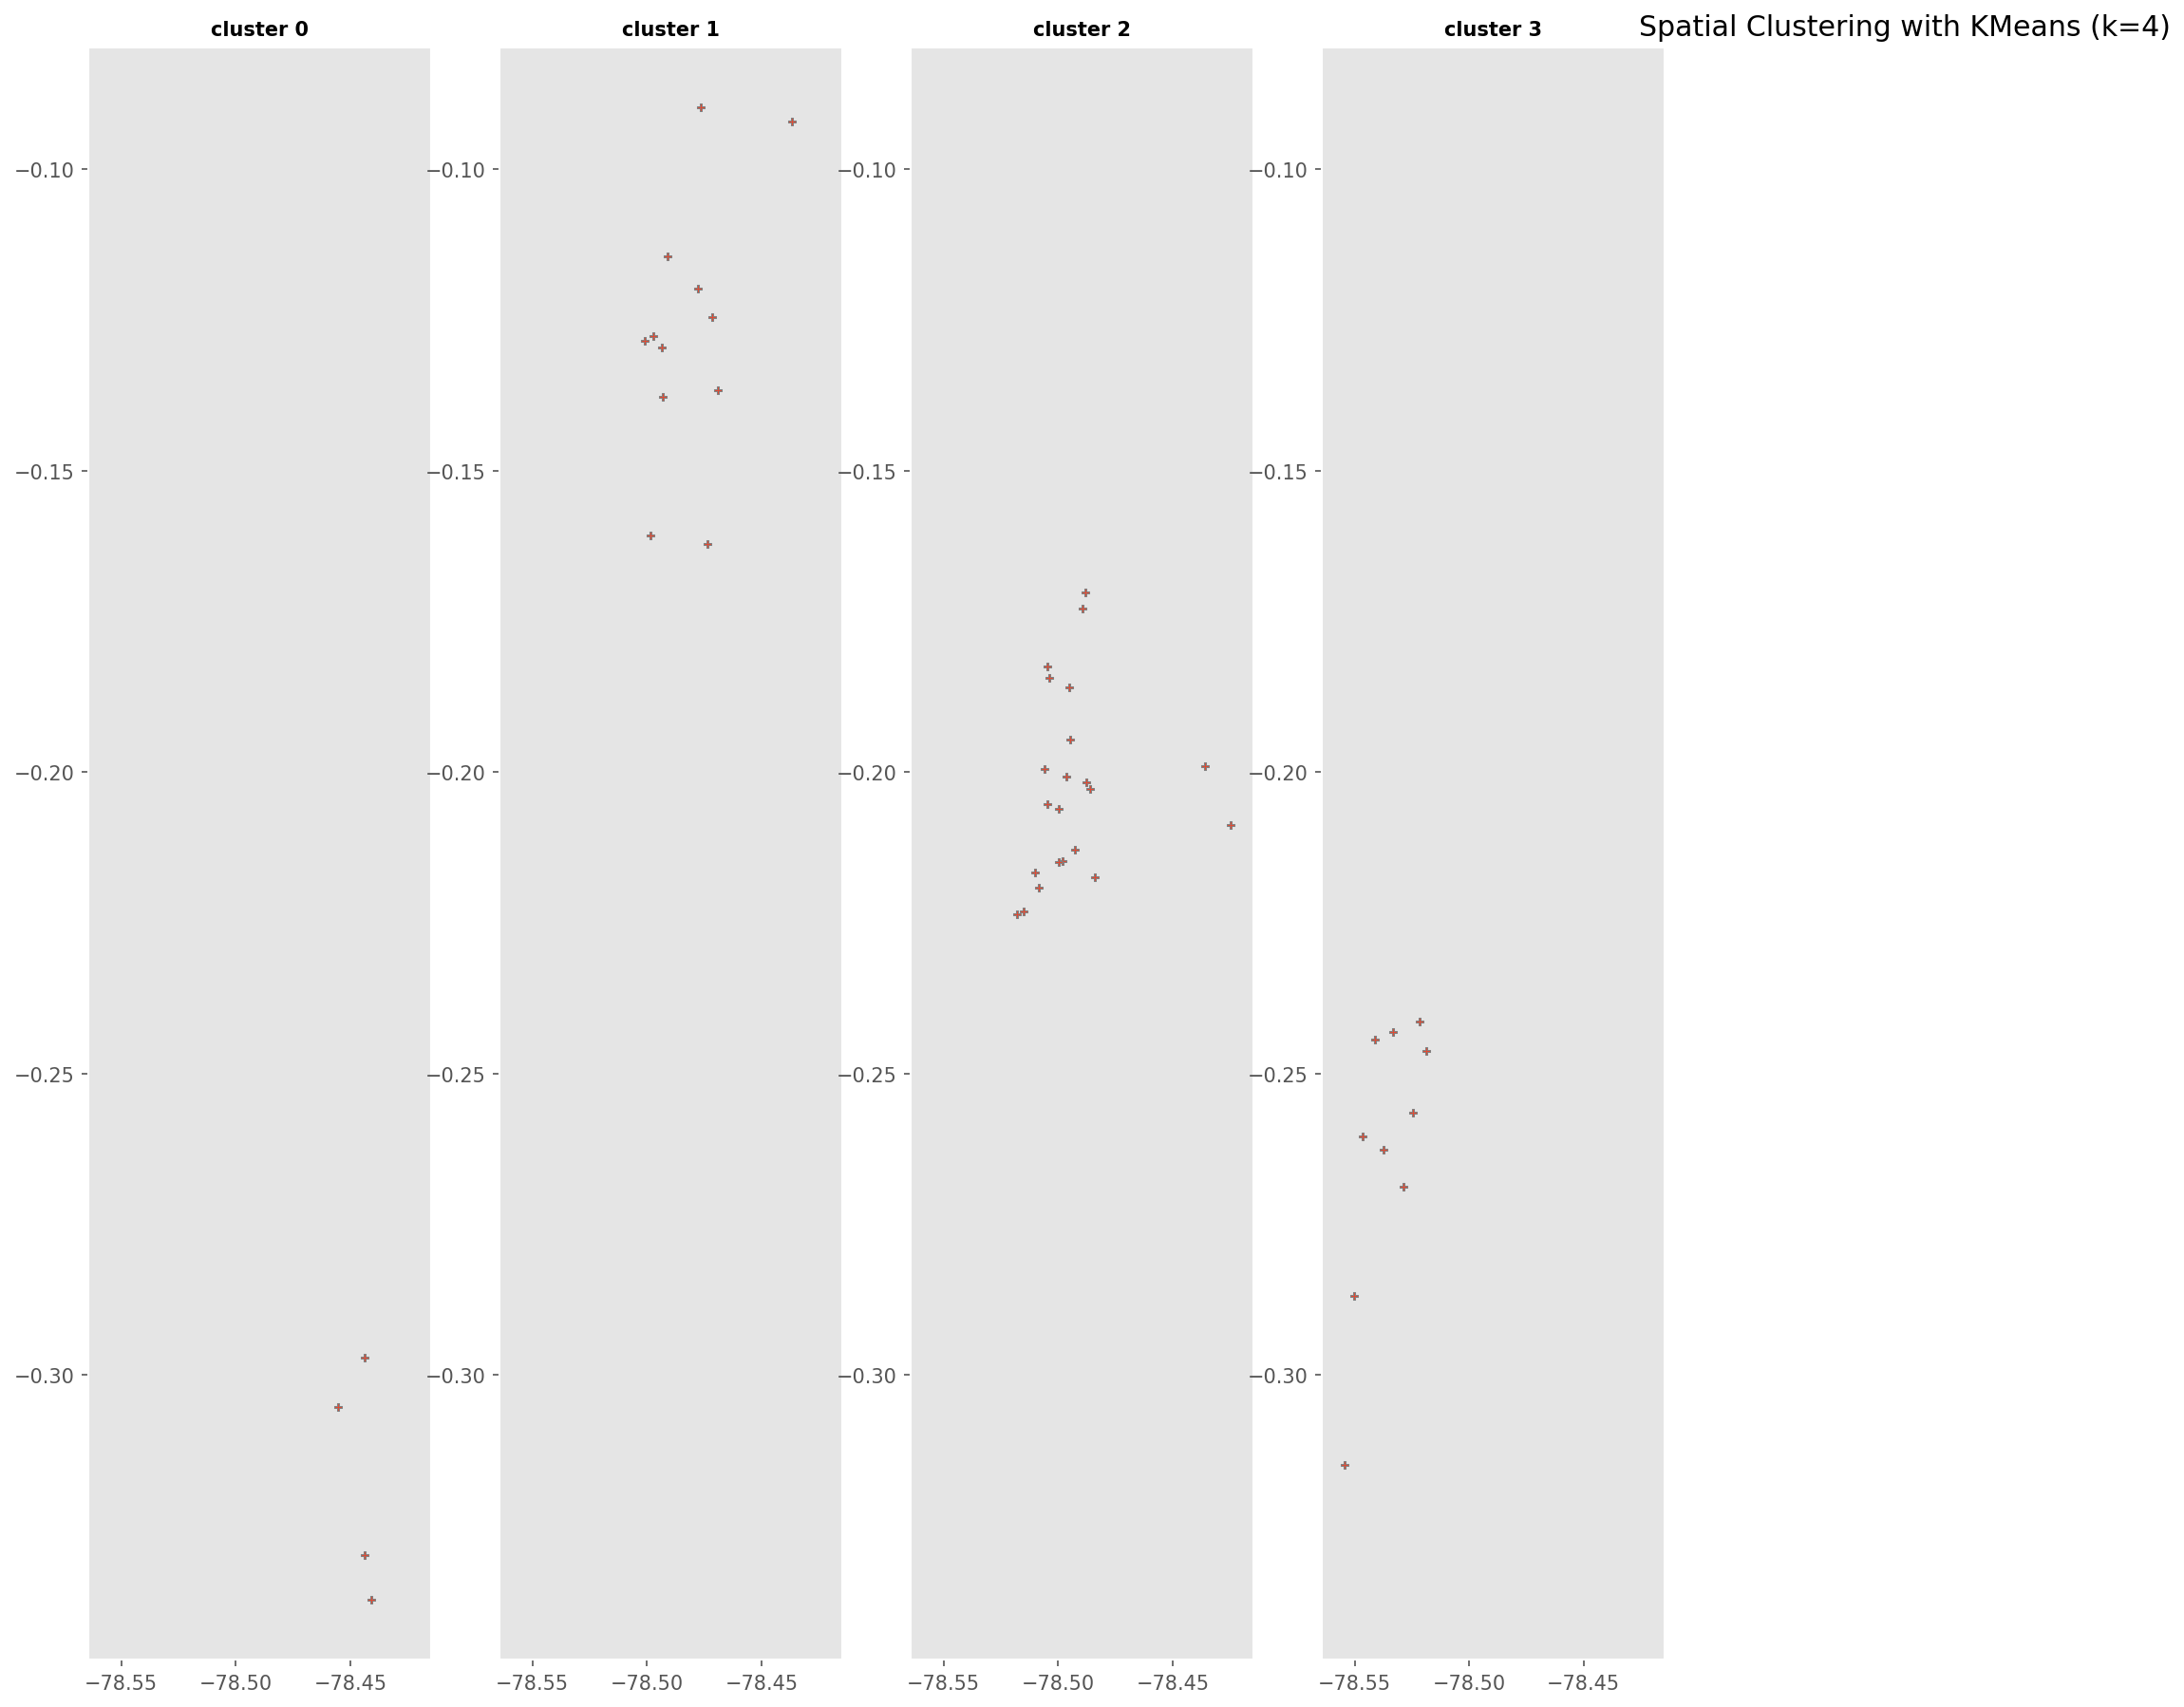

<Figure size 2700x2250 with 0 Axes>

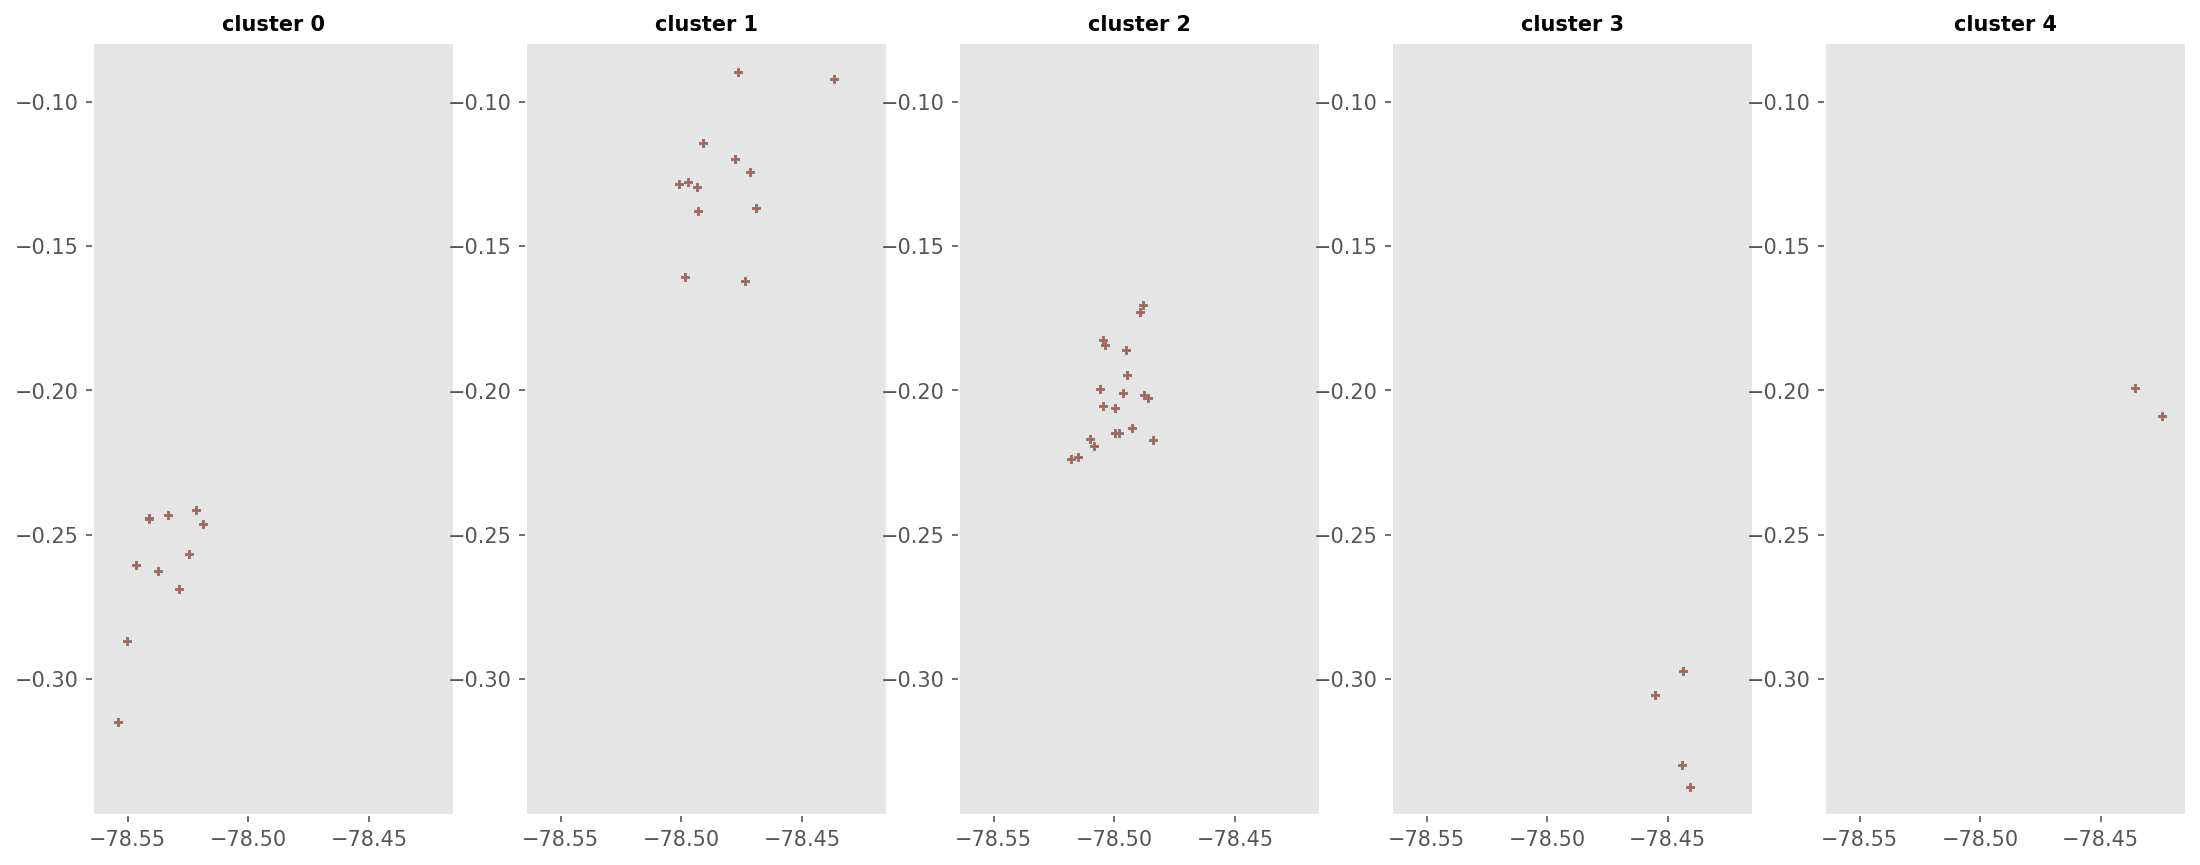

<Figure size 2700x2250 with 0 Axes>

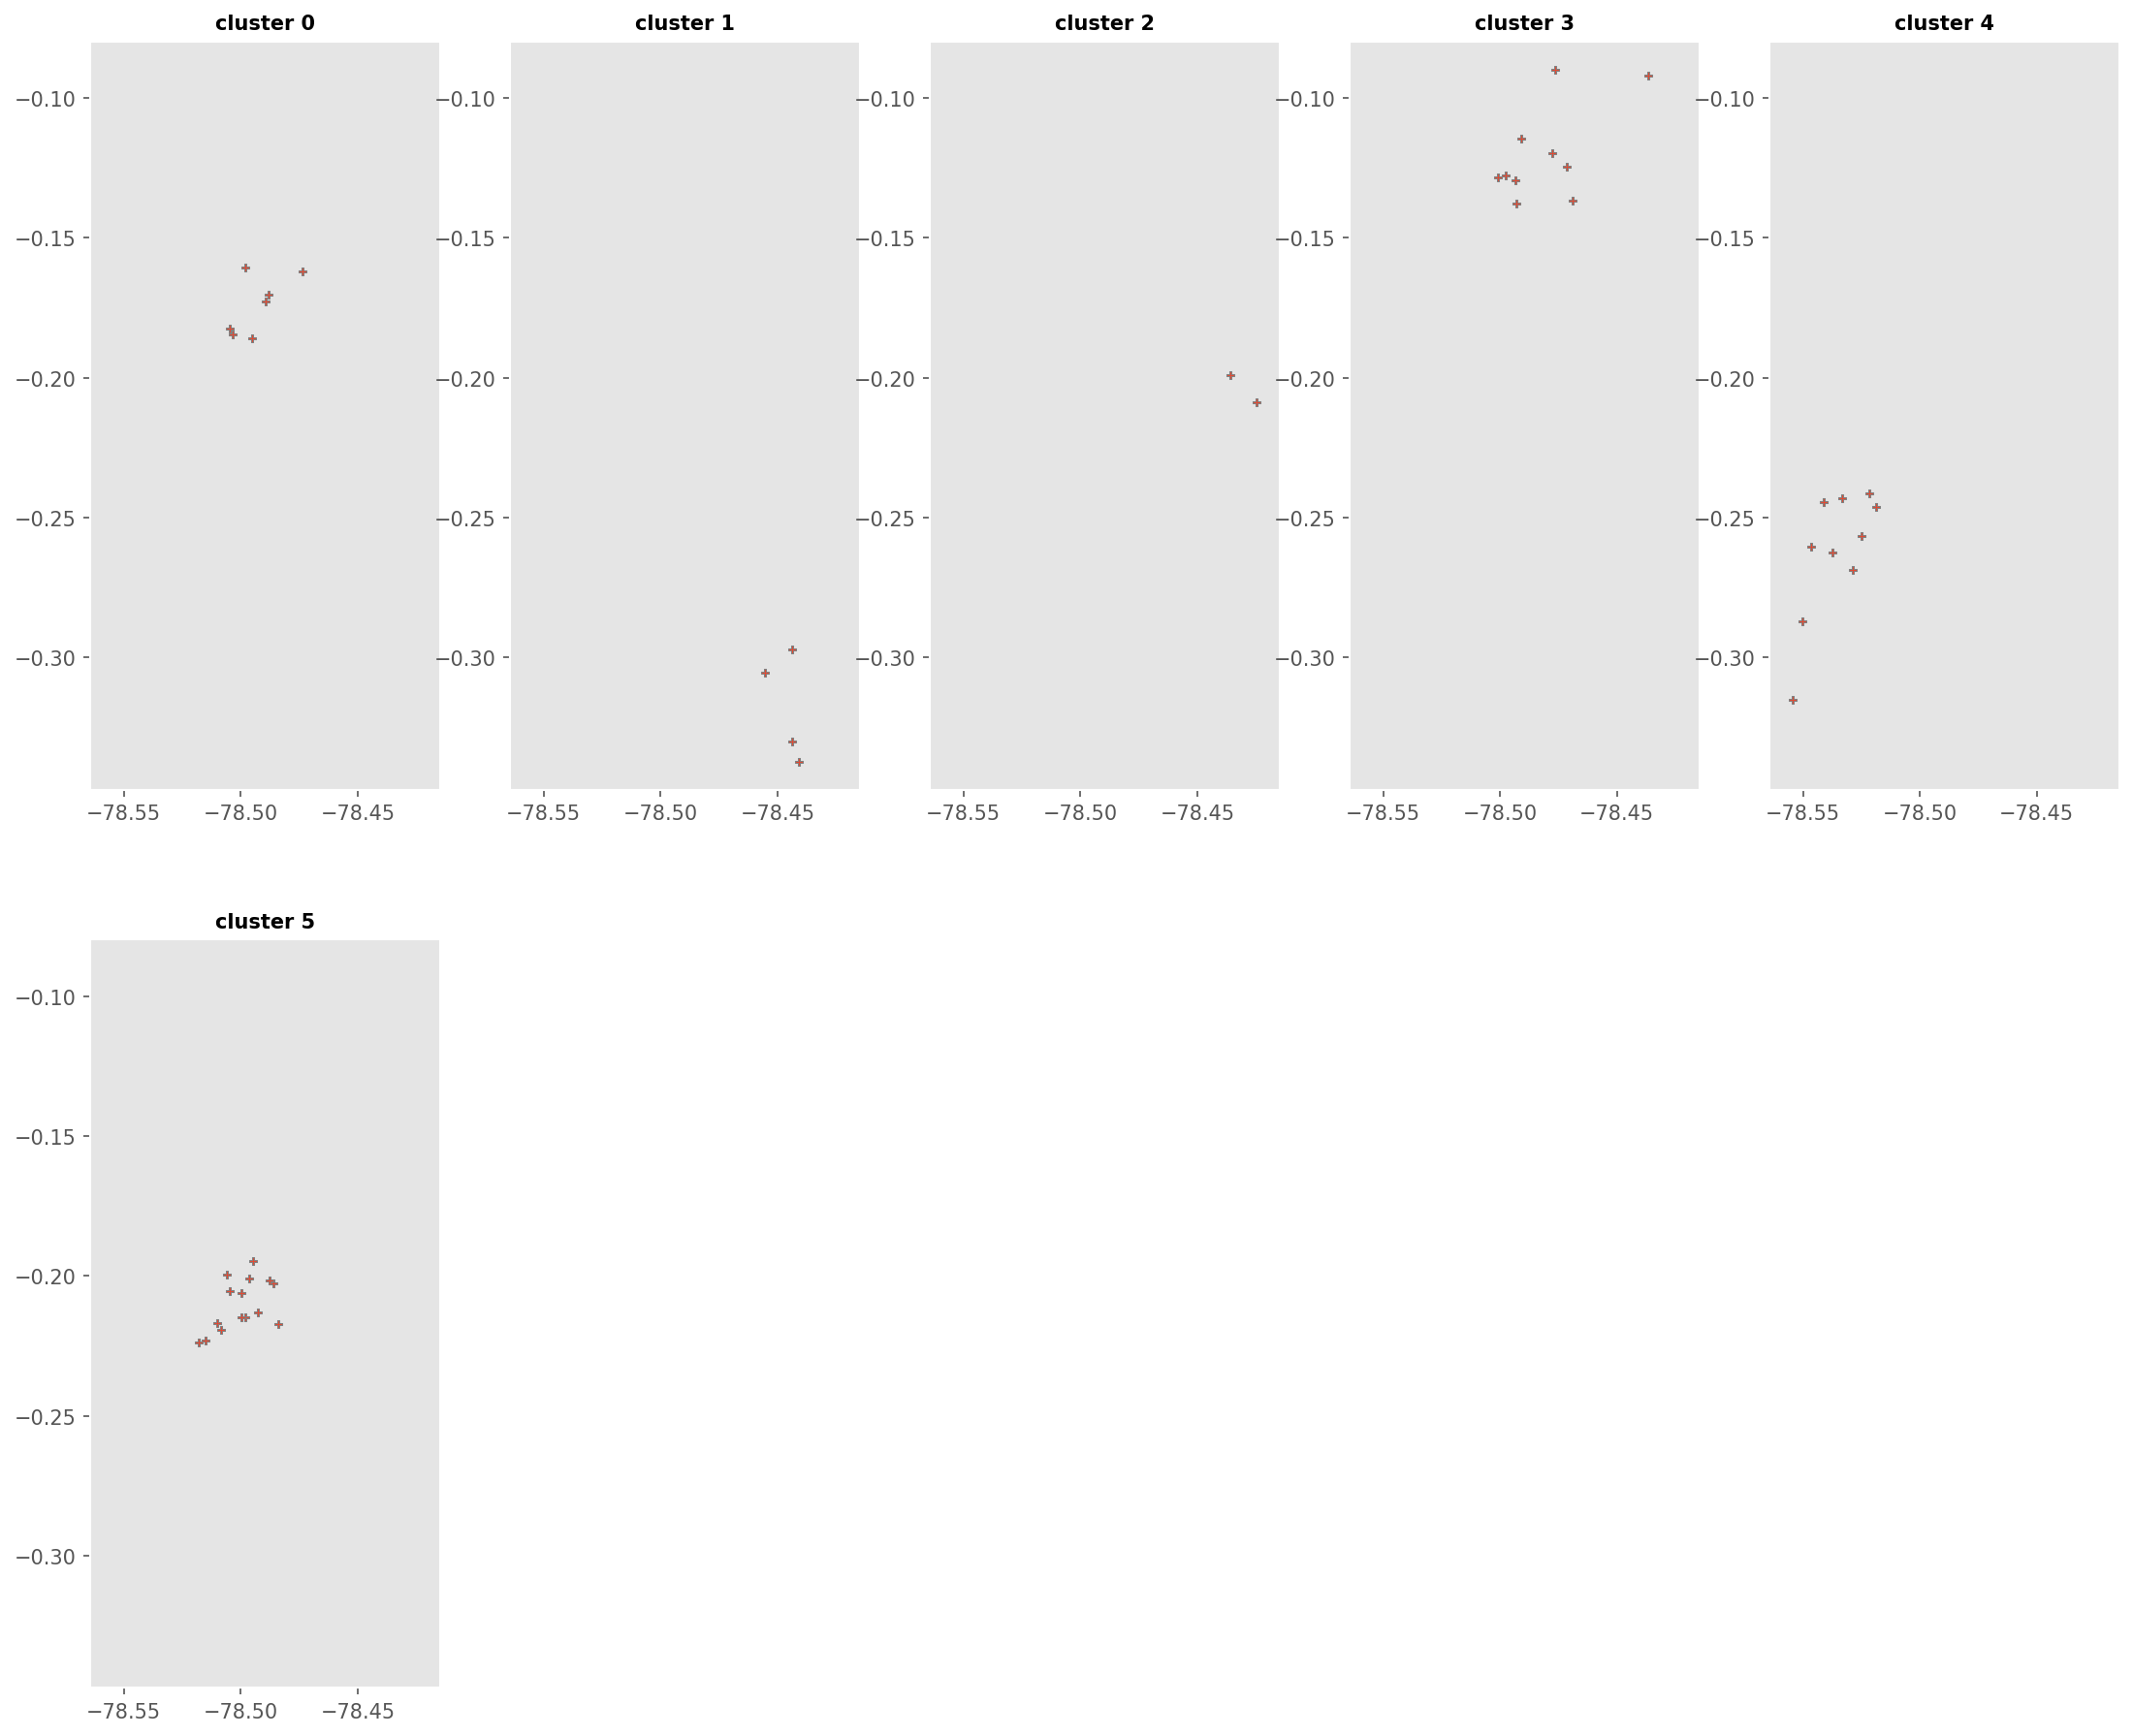

<Figure size 2700x2250 with 0 Axes>

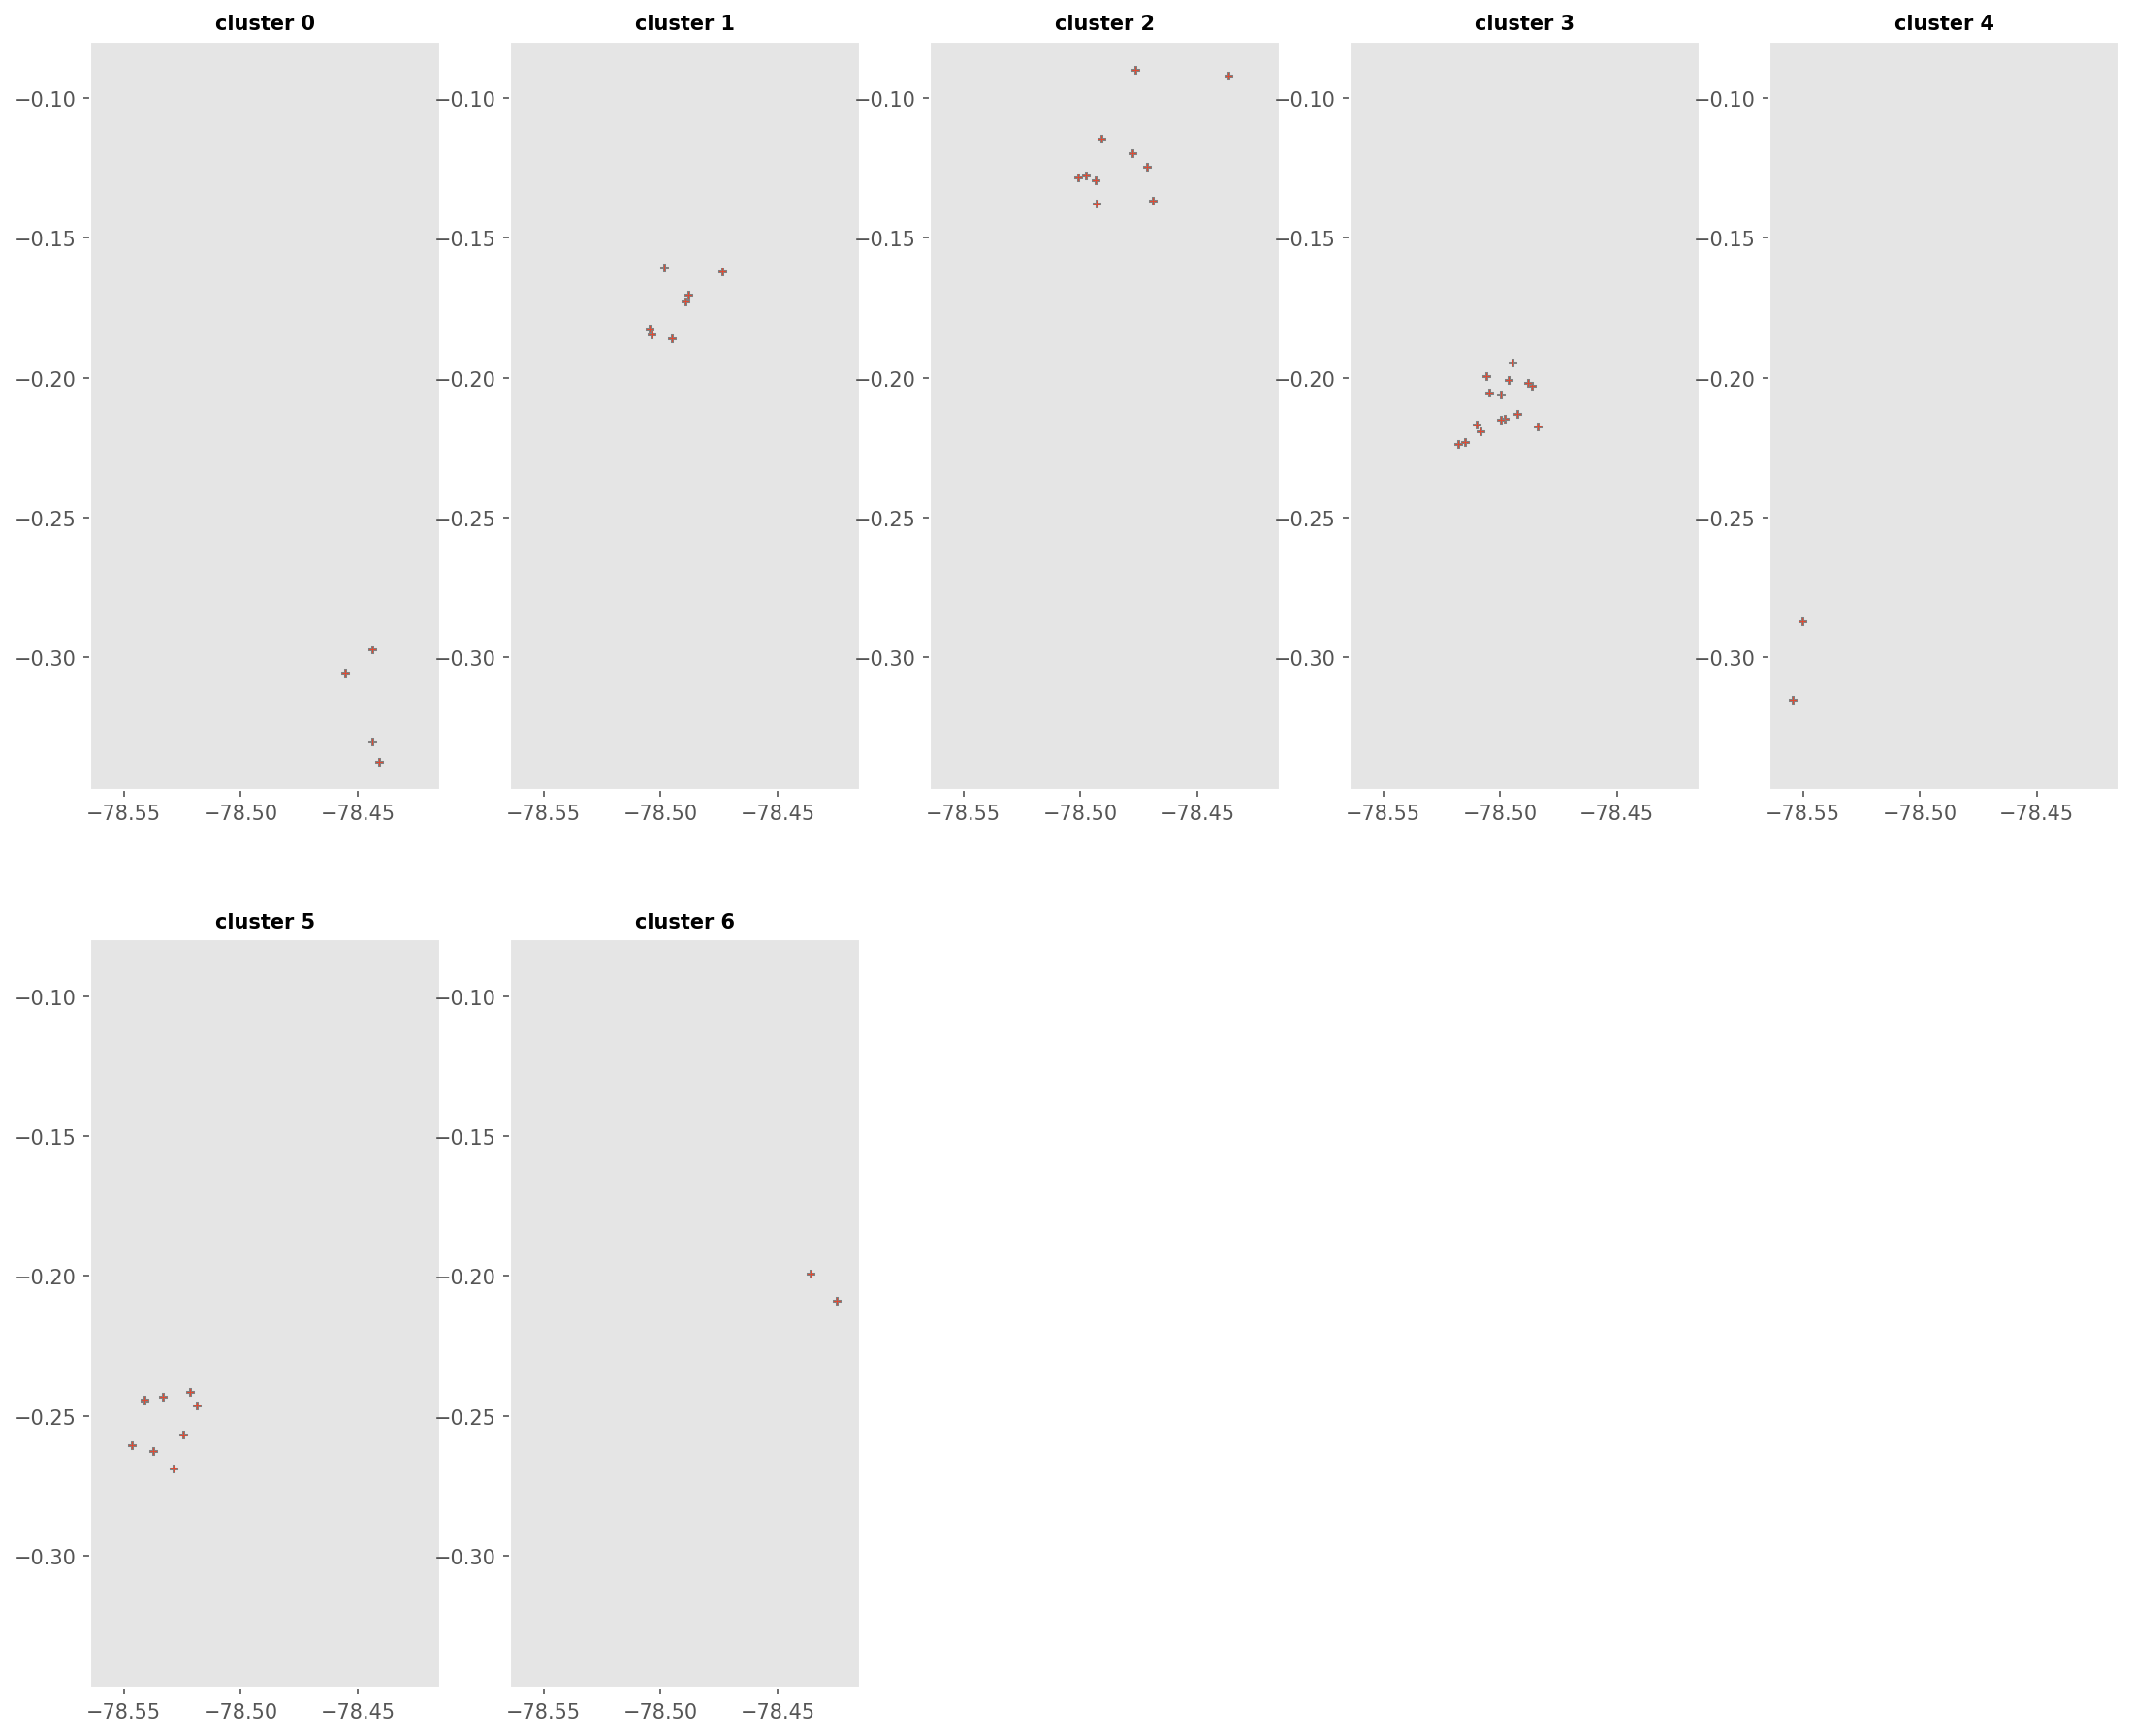

<Figure size 2700x2250 with 0 Axes>

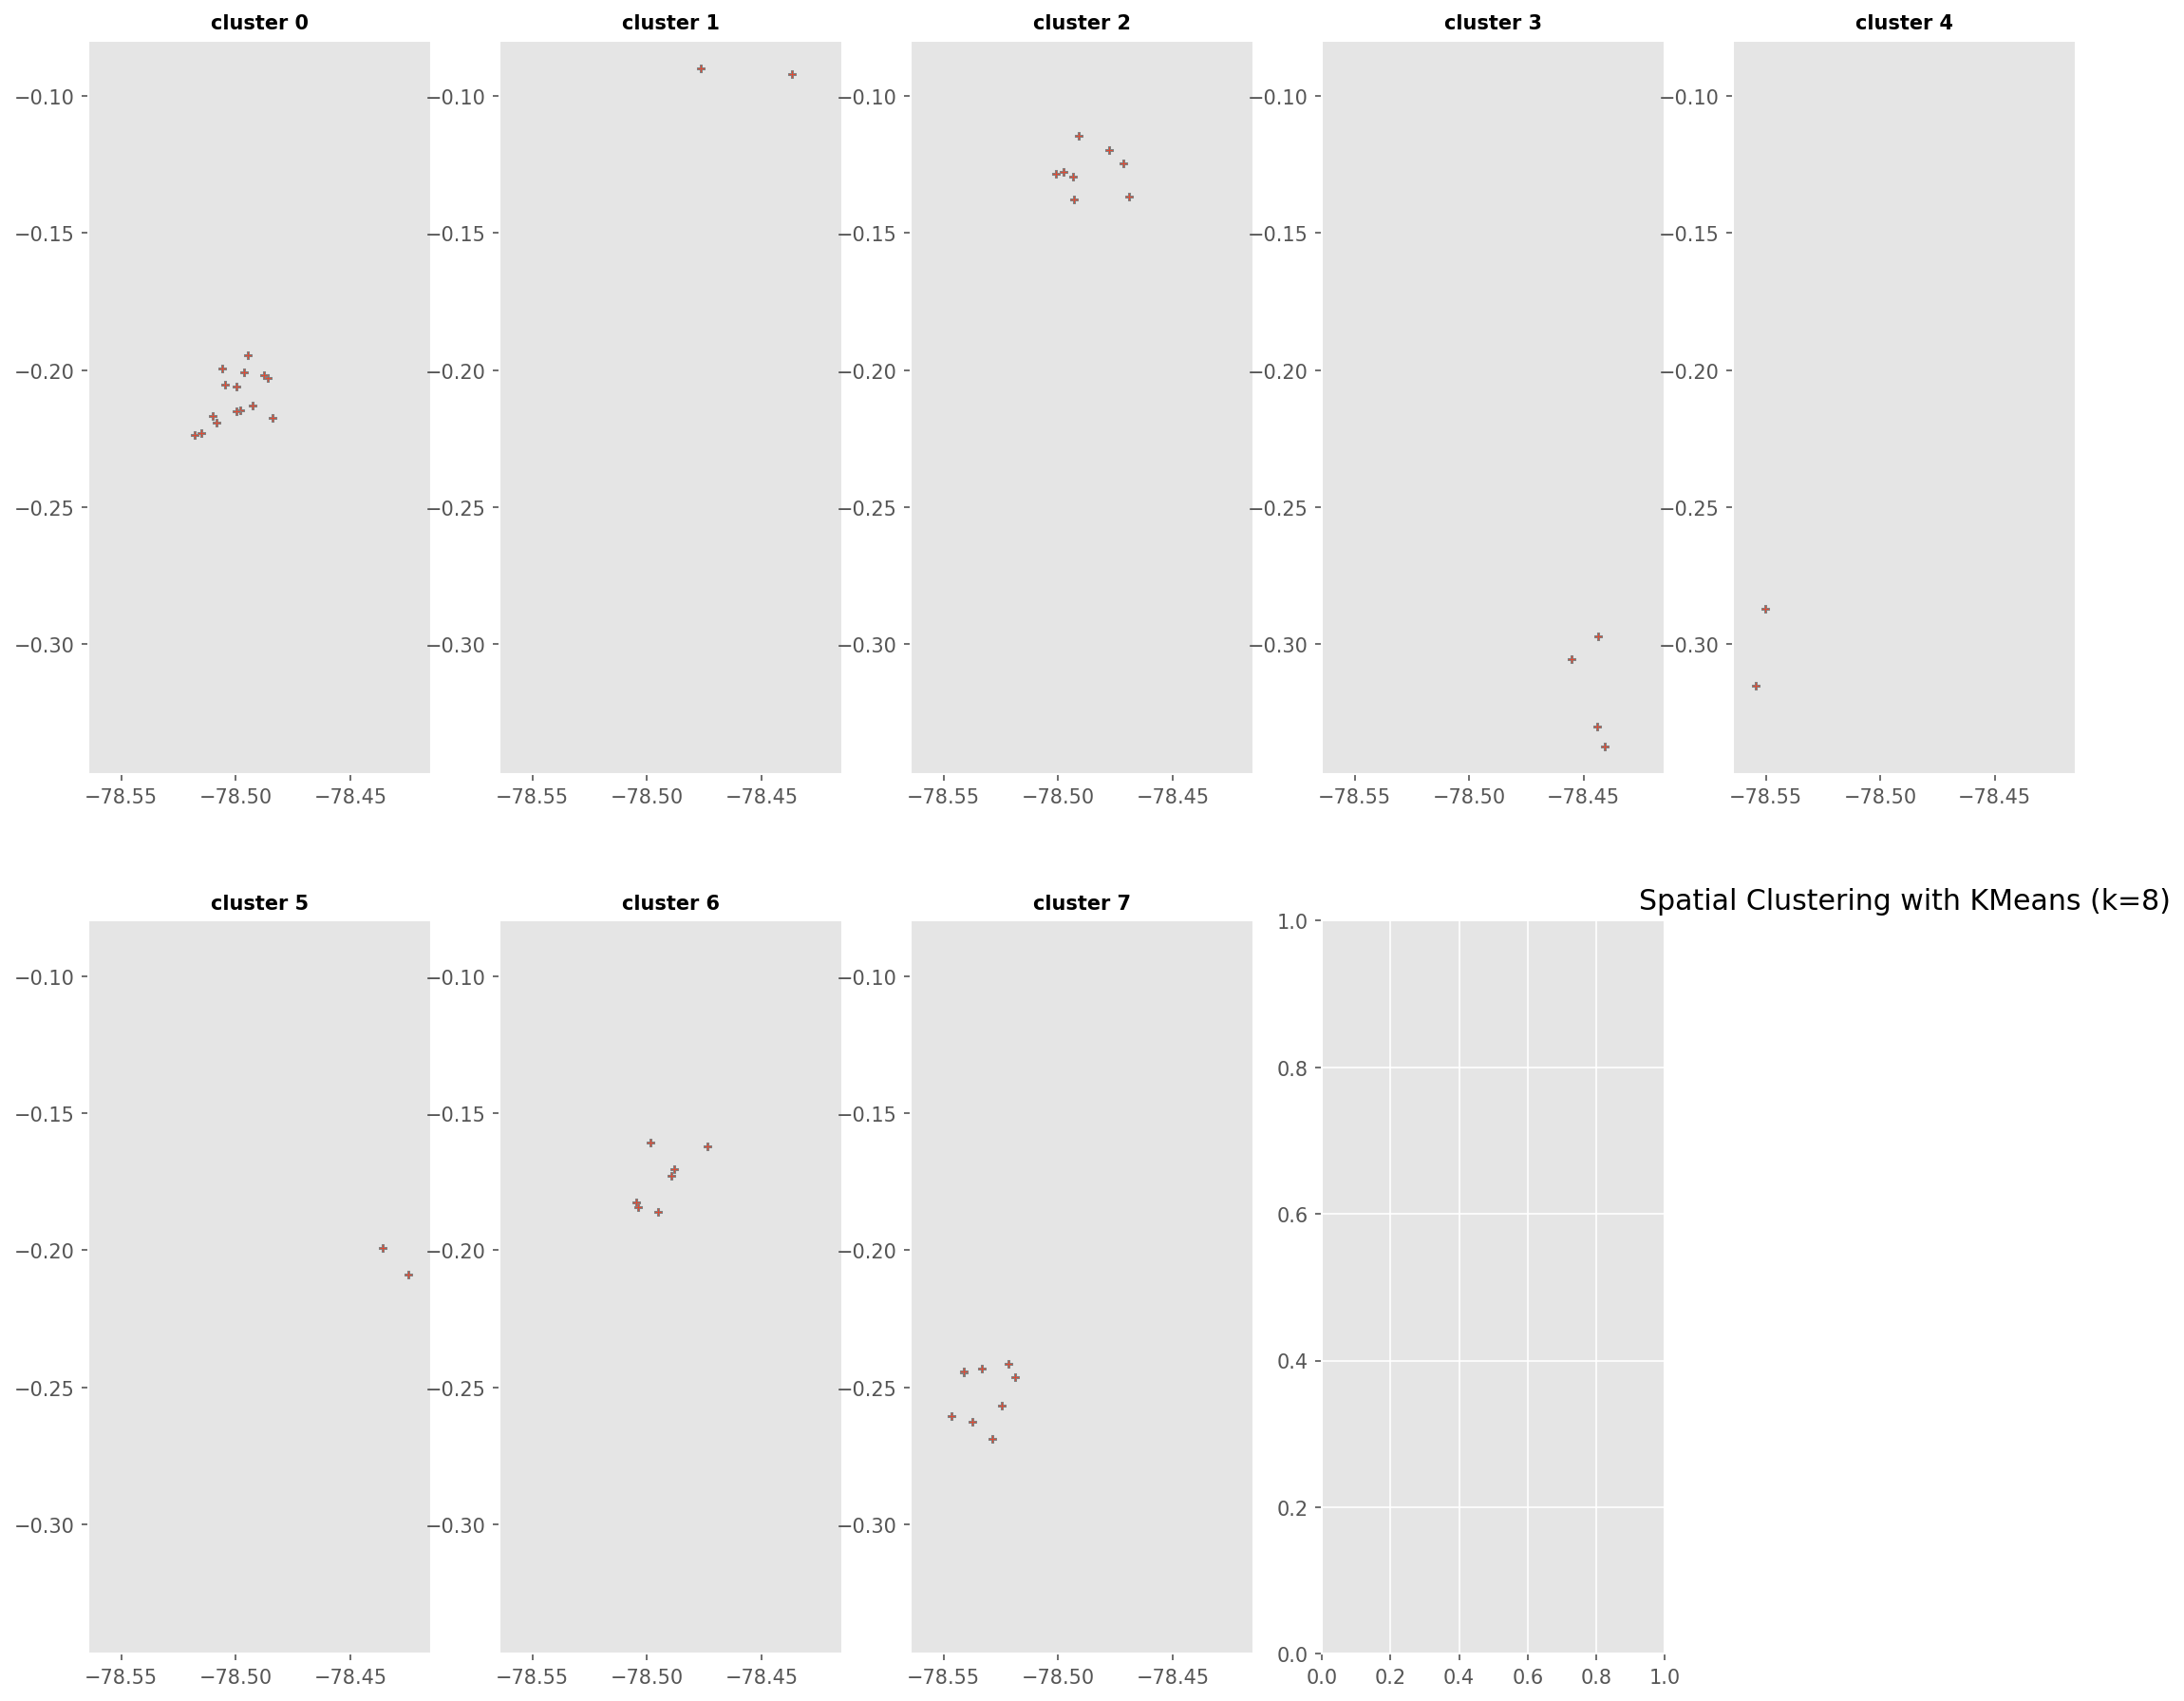

<Figure size 2700x2250 with 0 Axes>

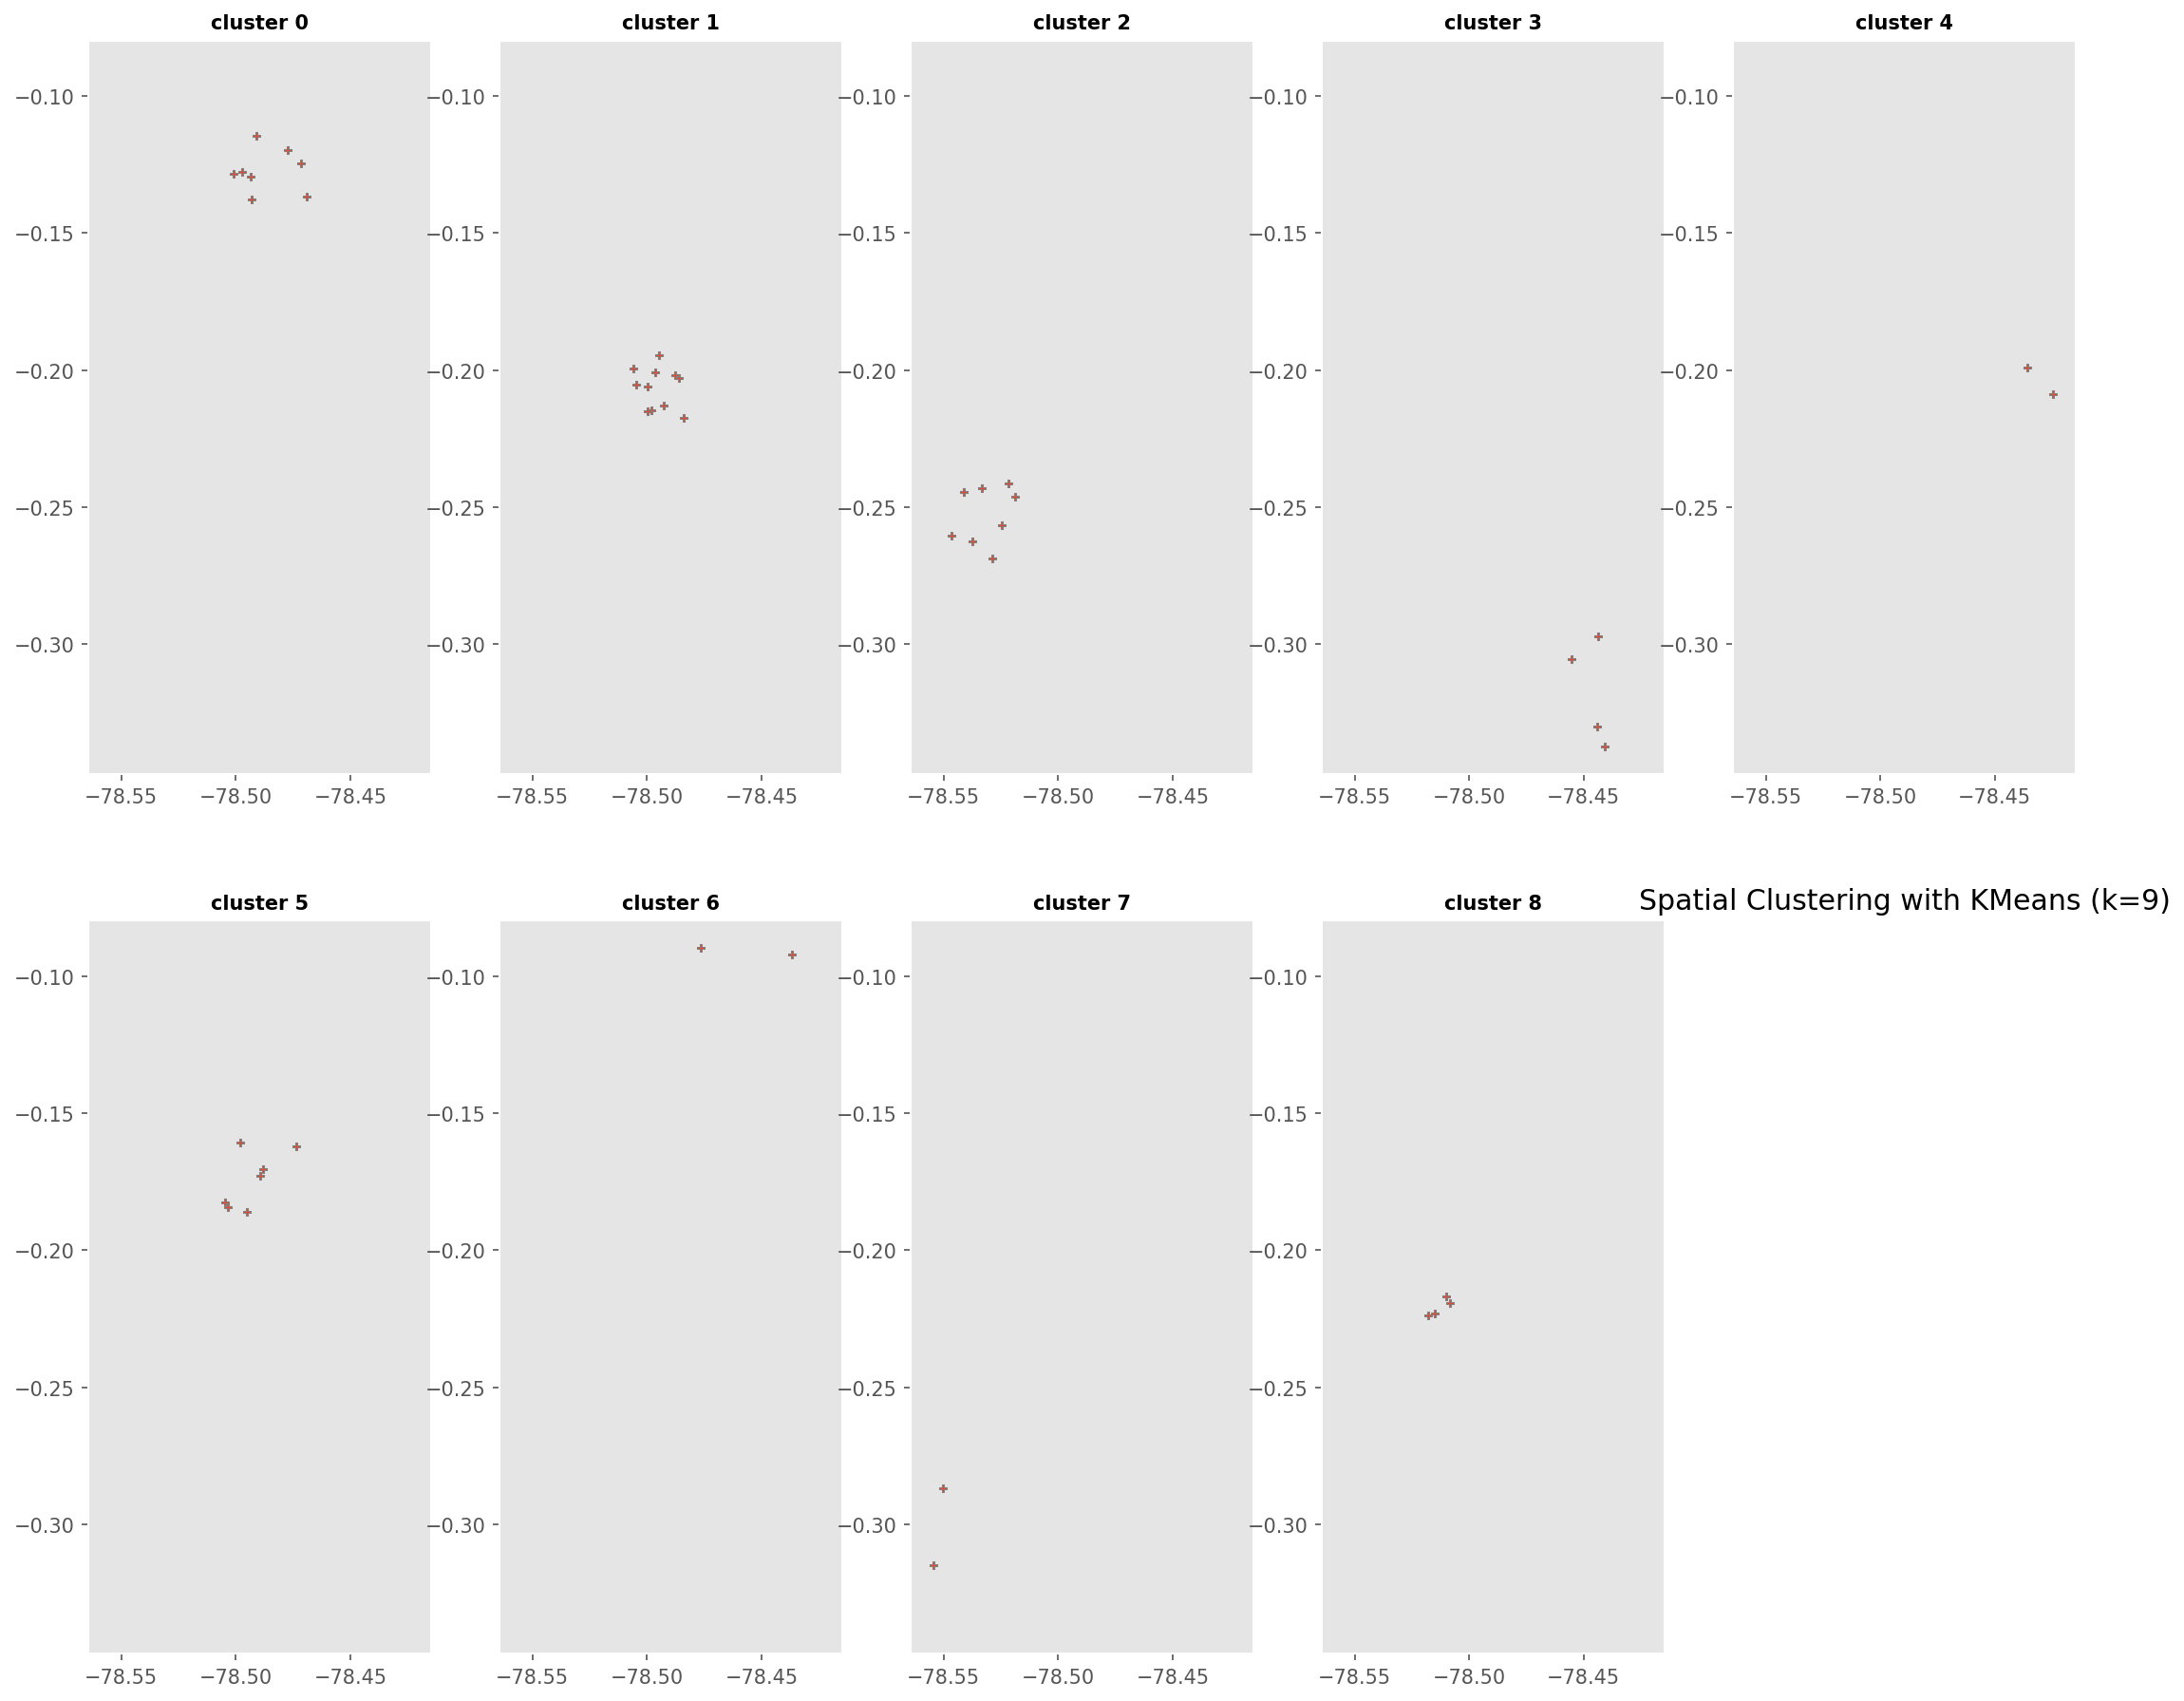

In [23]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [18,15]

k = [4,5,6,7,8, 9] #### cantidad de cluster
n = len(k)
#plt.subplots(nrows=3, ncols=3, figsize=(18,15))


for i in range(n):
    num = k[i]
    est = kmean[k[i]-1]
    center =  [ est.cluster_centers_[0], est.cluster_centers_[1]]
    df['cluster'] = est.predict(X).tolist()
    font = {'weight' : 'bold','size'   : 10}
    cl = len(list(df['cluster_%d' %num].unique()))
    plt.figure()
    plt.subplots(nrows=cl//4, ncols=5, figsize=(18,15))
    plt.axis('off')
    plt.grid(False)
    plt.title("Spatial Clustering with KMeans (k={})".format(k[i]))
    for nc in range(cl):
        ax = plt.subplot(cl//5+1, 5, nc+1)
        ax.set_title("cluster %d" %nc, **font)
        plot_stations_individuals(ax, df,nc,'cluster_%d' %num)


    


<Figure size 2700x2250 with 0 Axes>

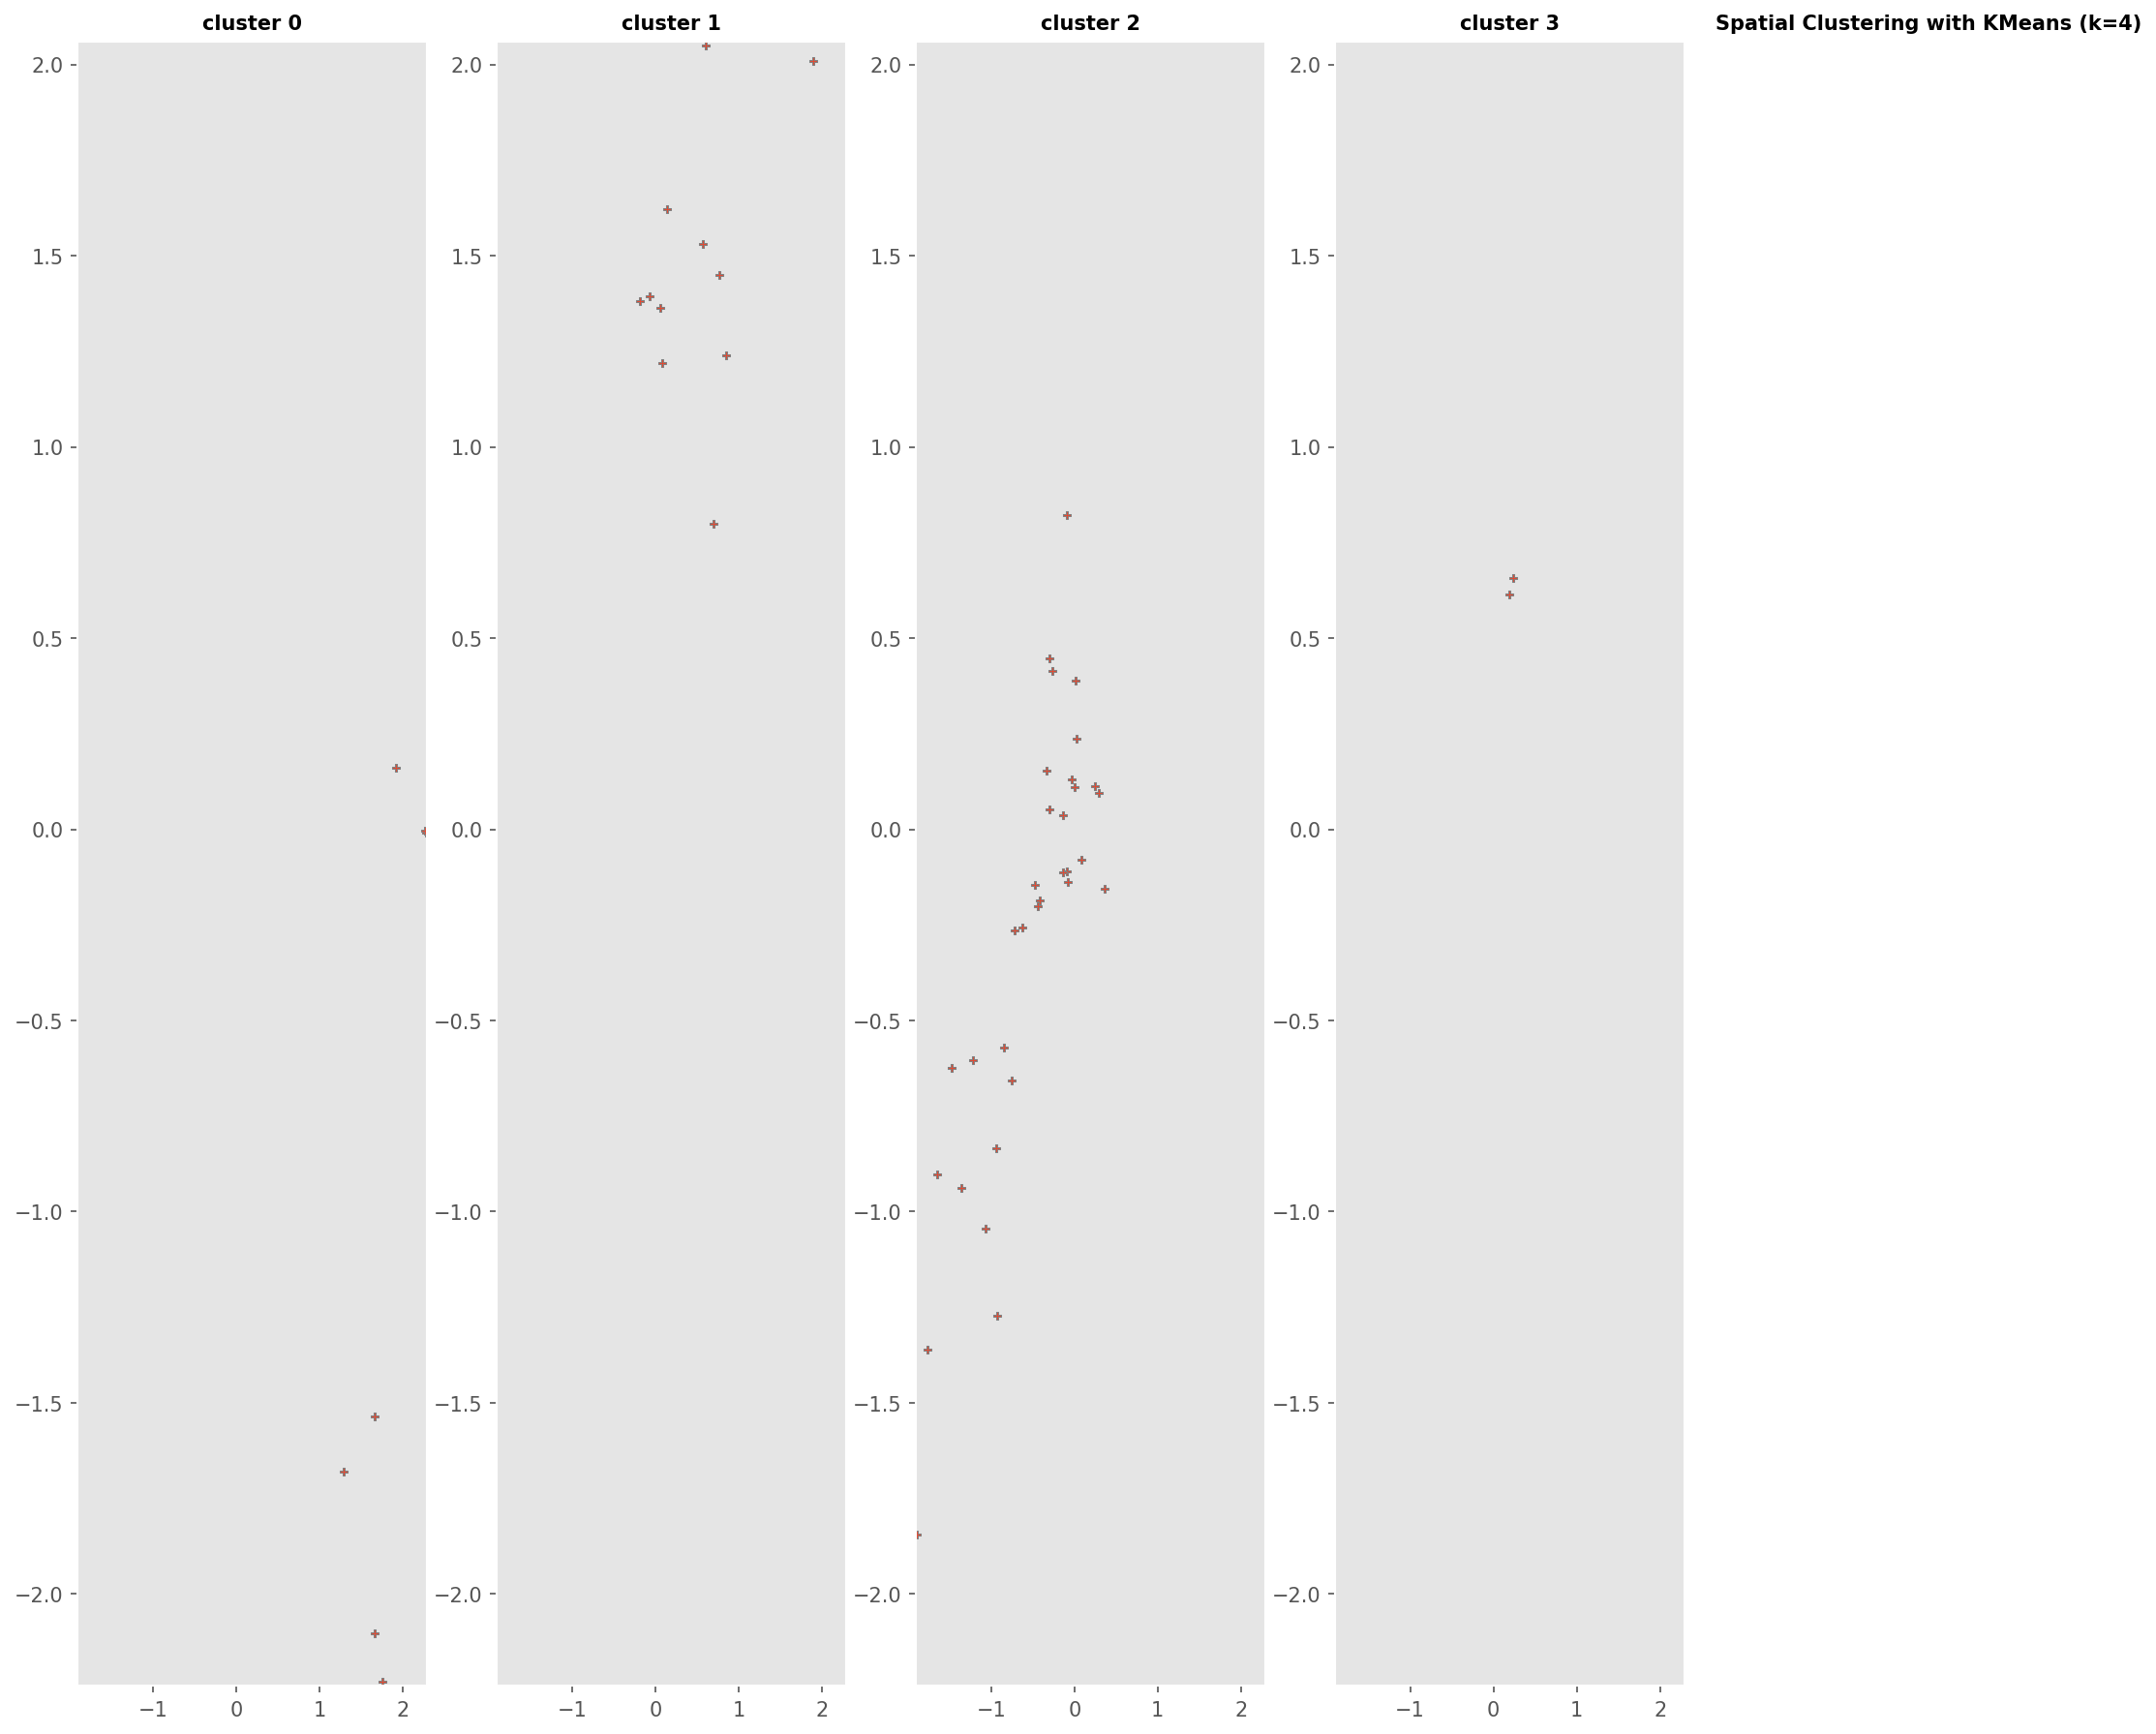

<Figure size 2700x2250 with 0 Axes>

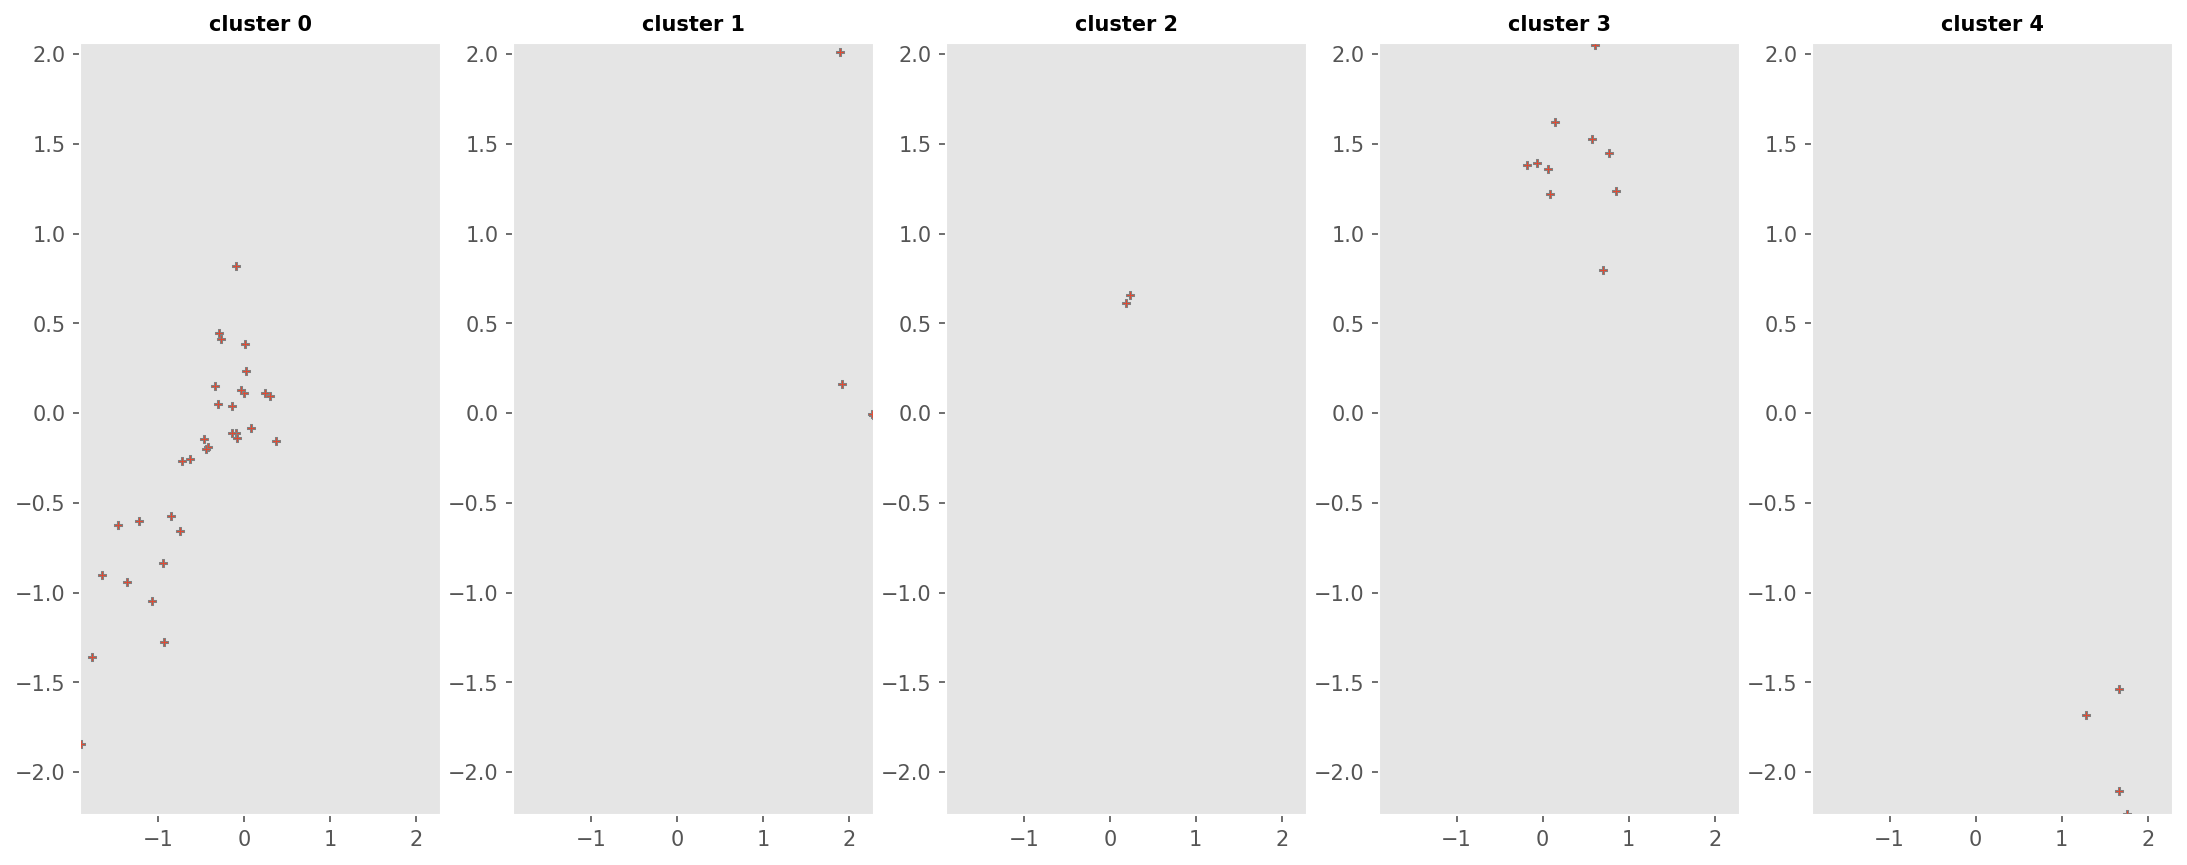

<Figure size 2700x2250 with 0 Axes>

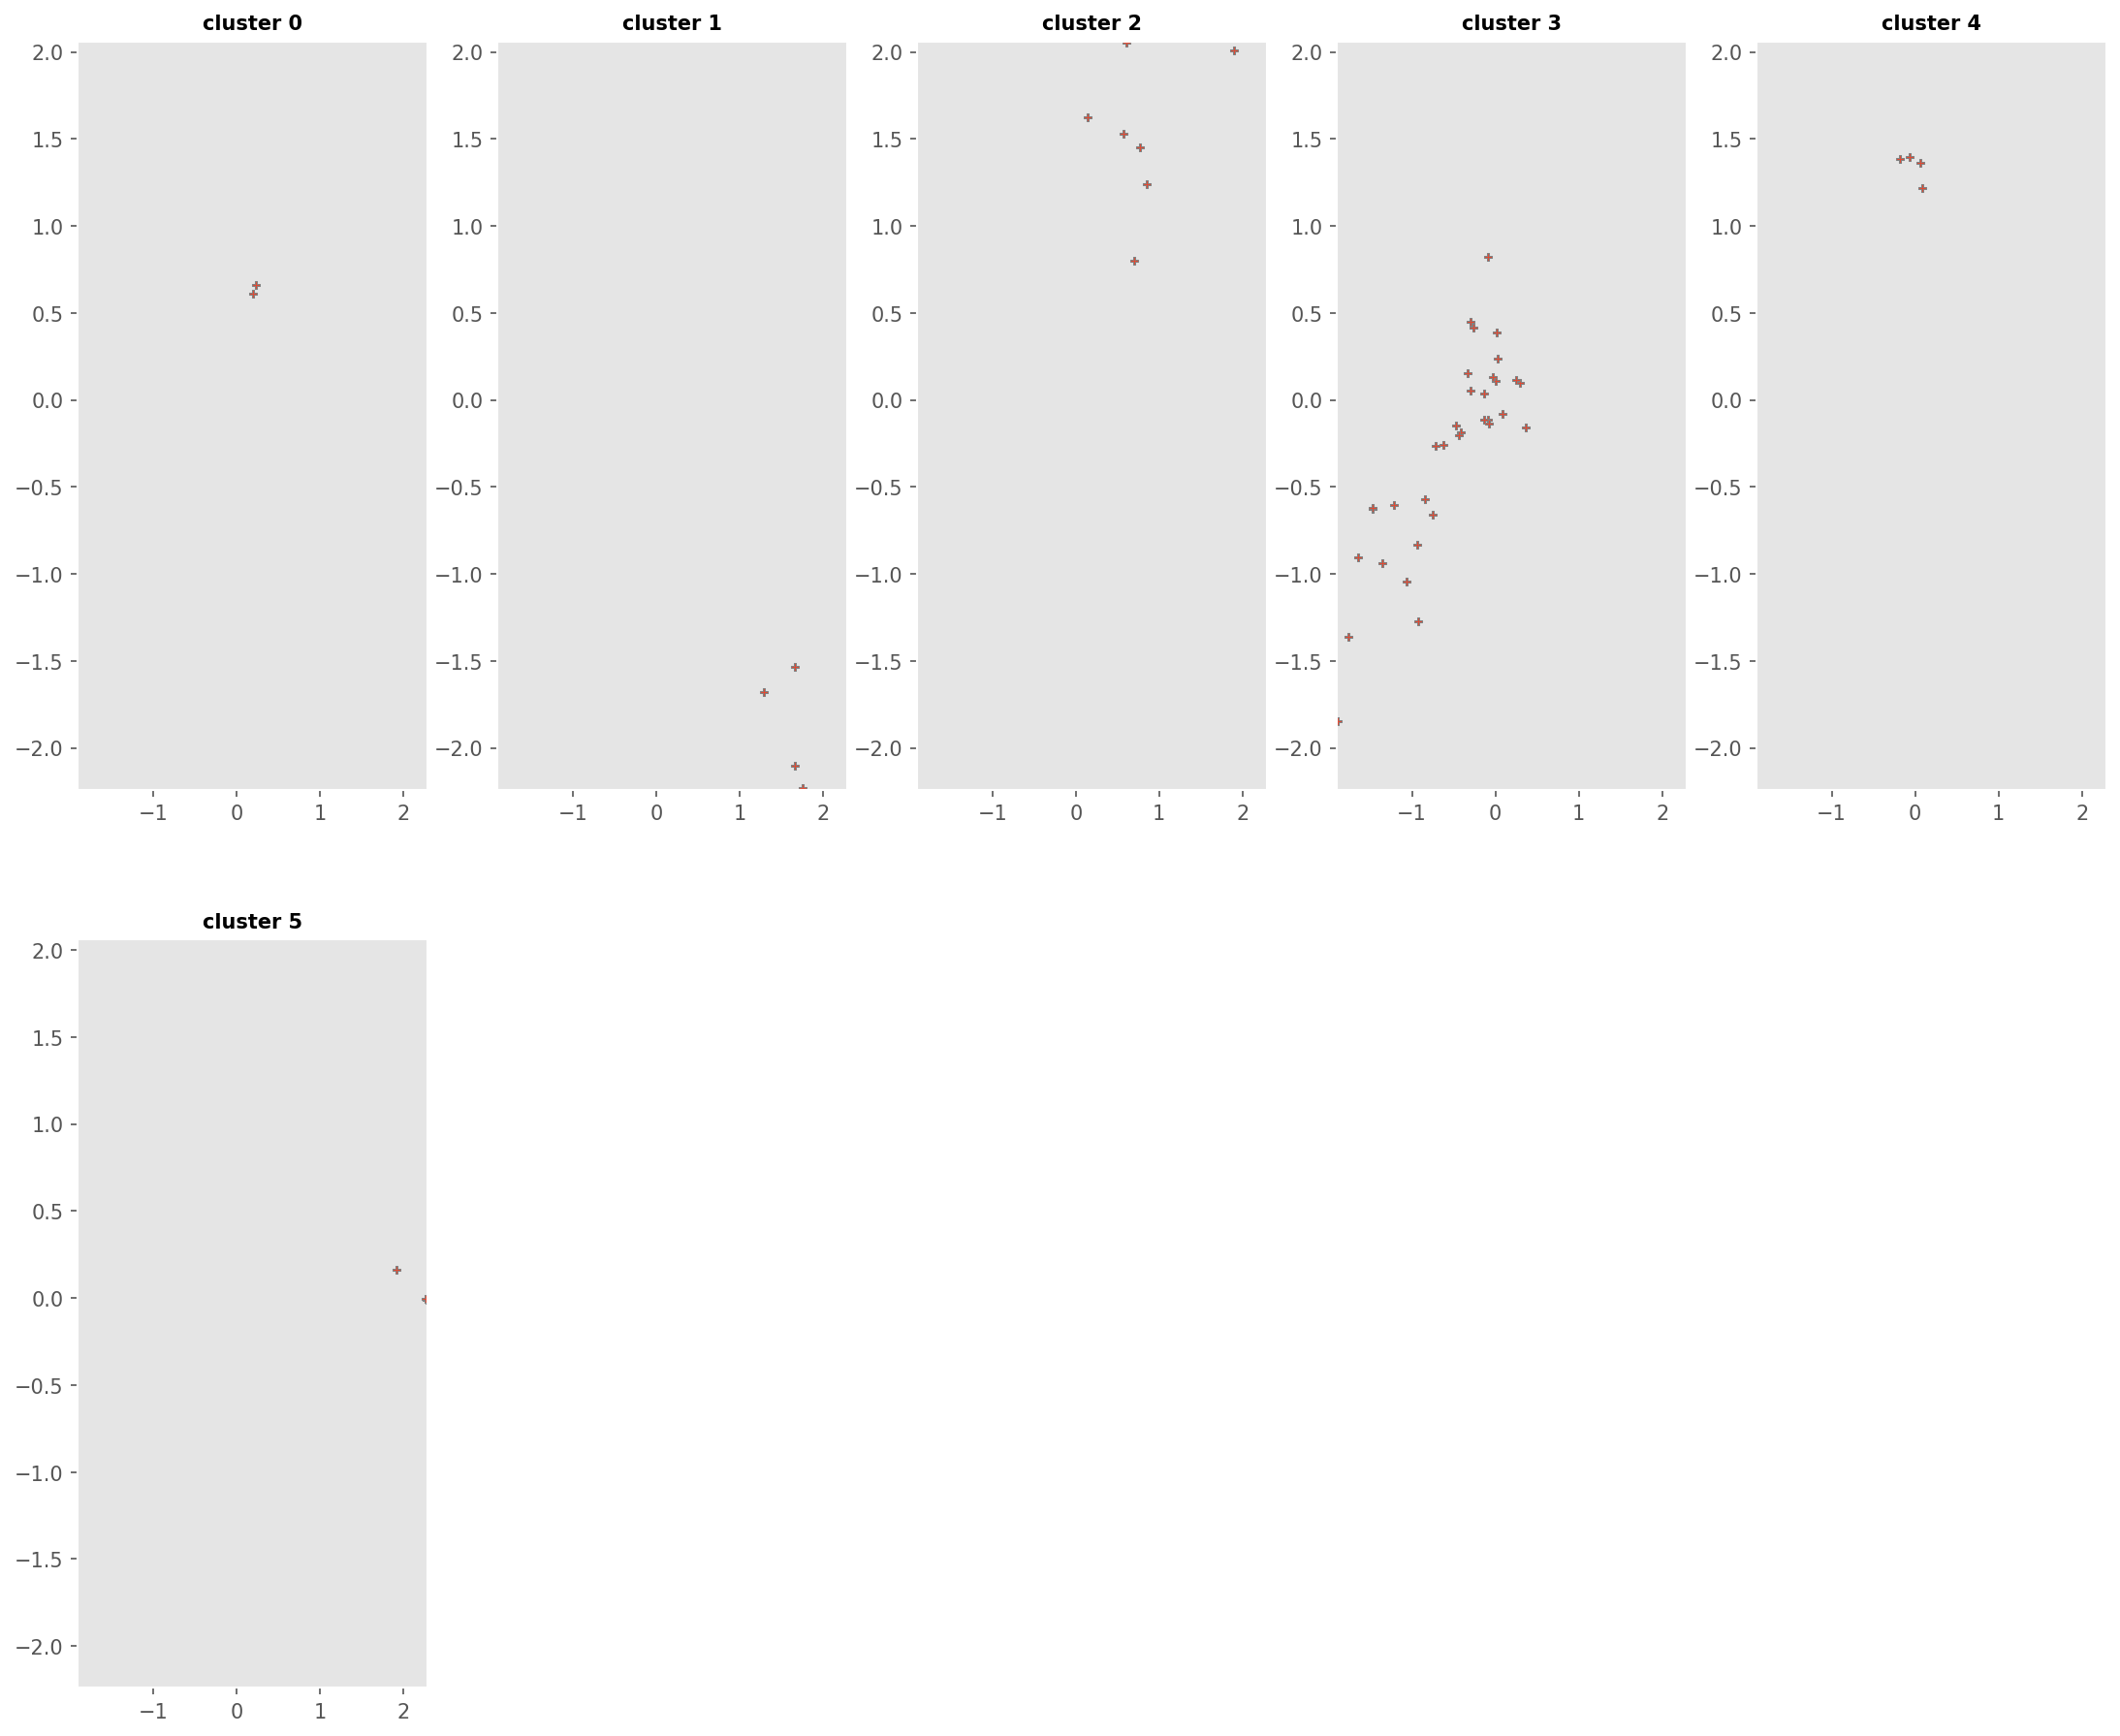

<Figure size 2700x2250 with 0 Axes>

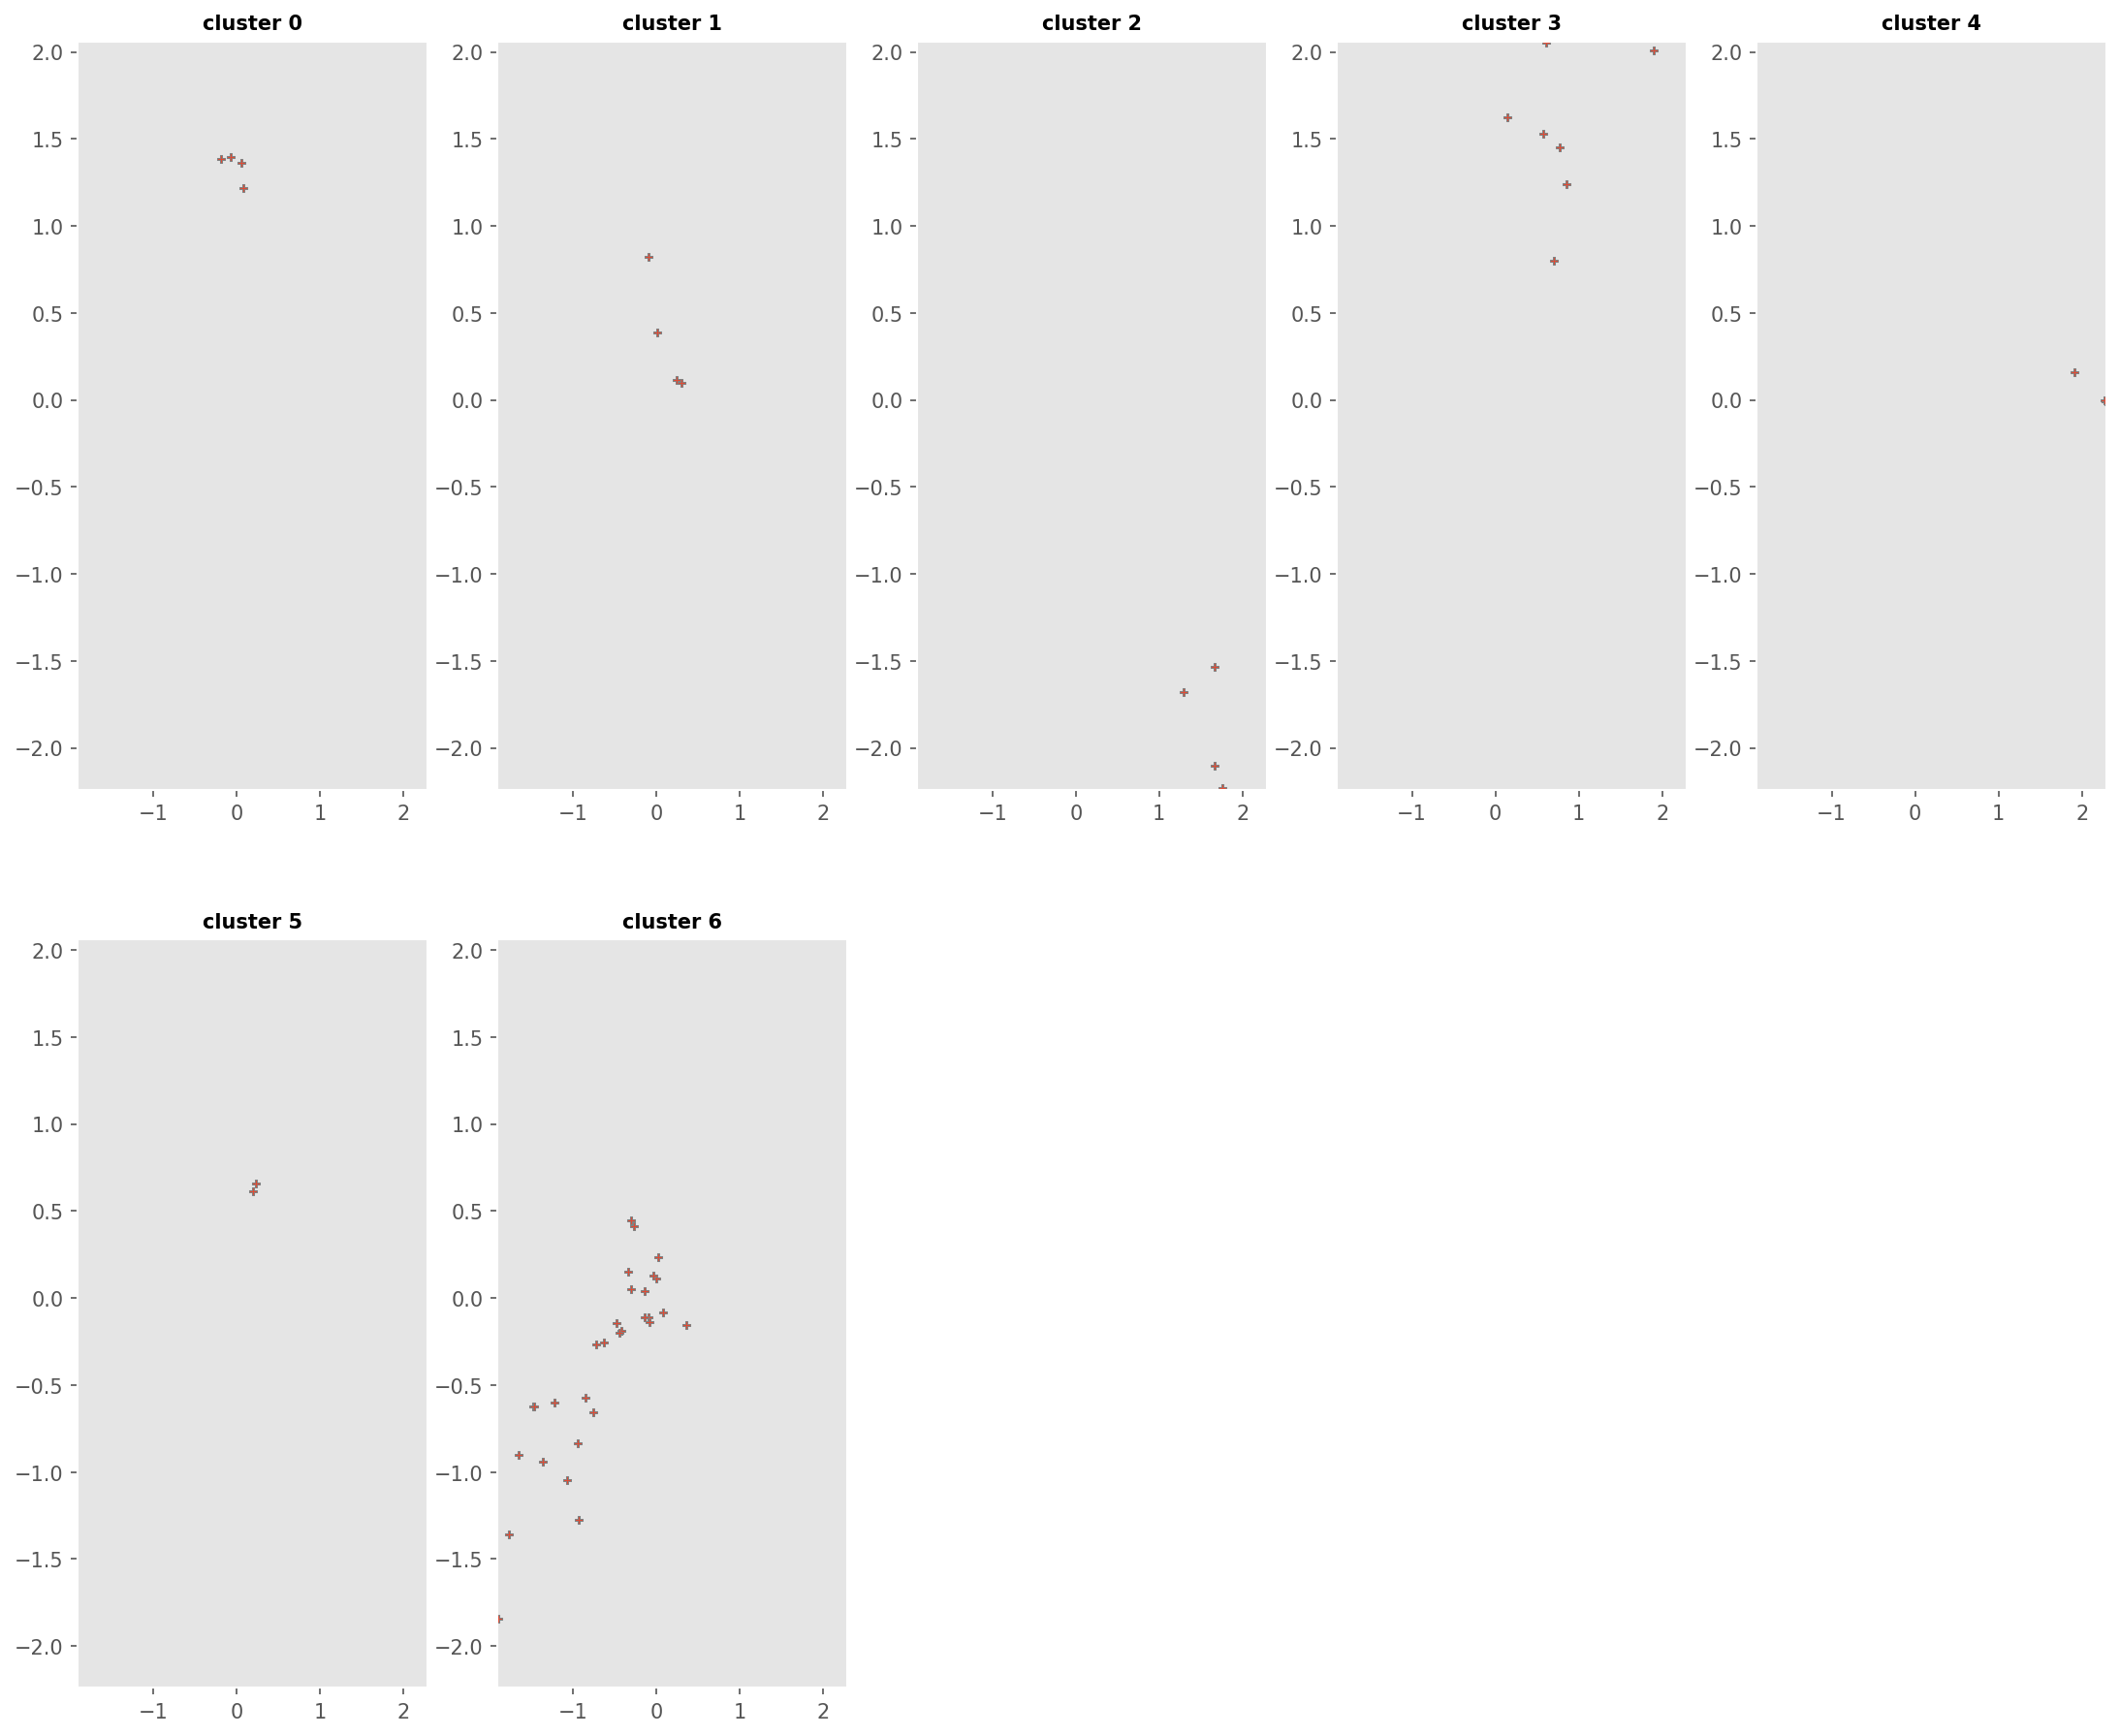

<Figure size 2700x2250 with 0 Axes>

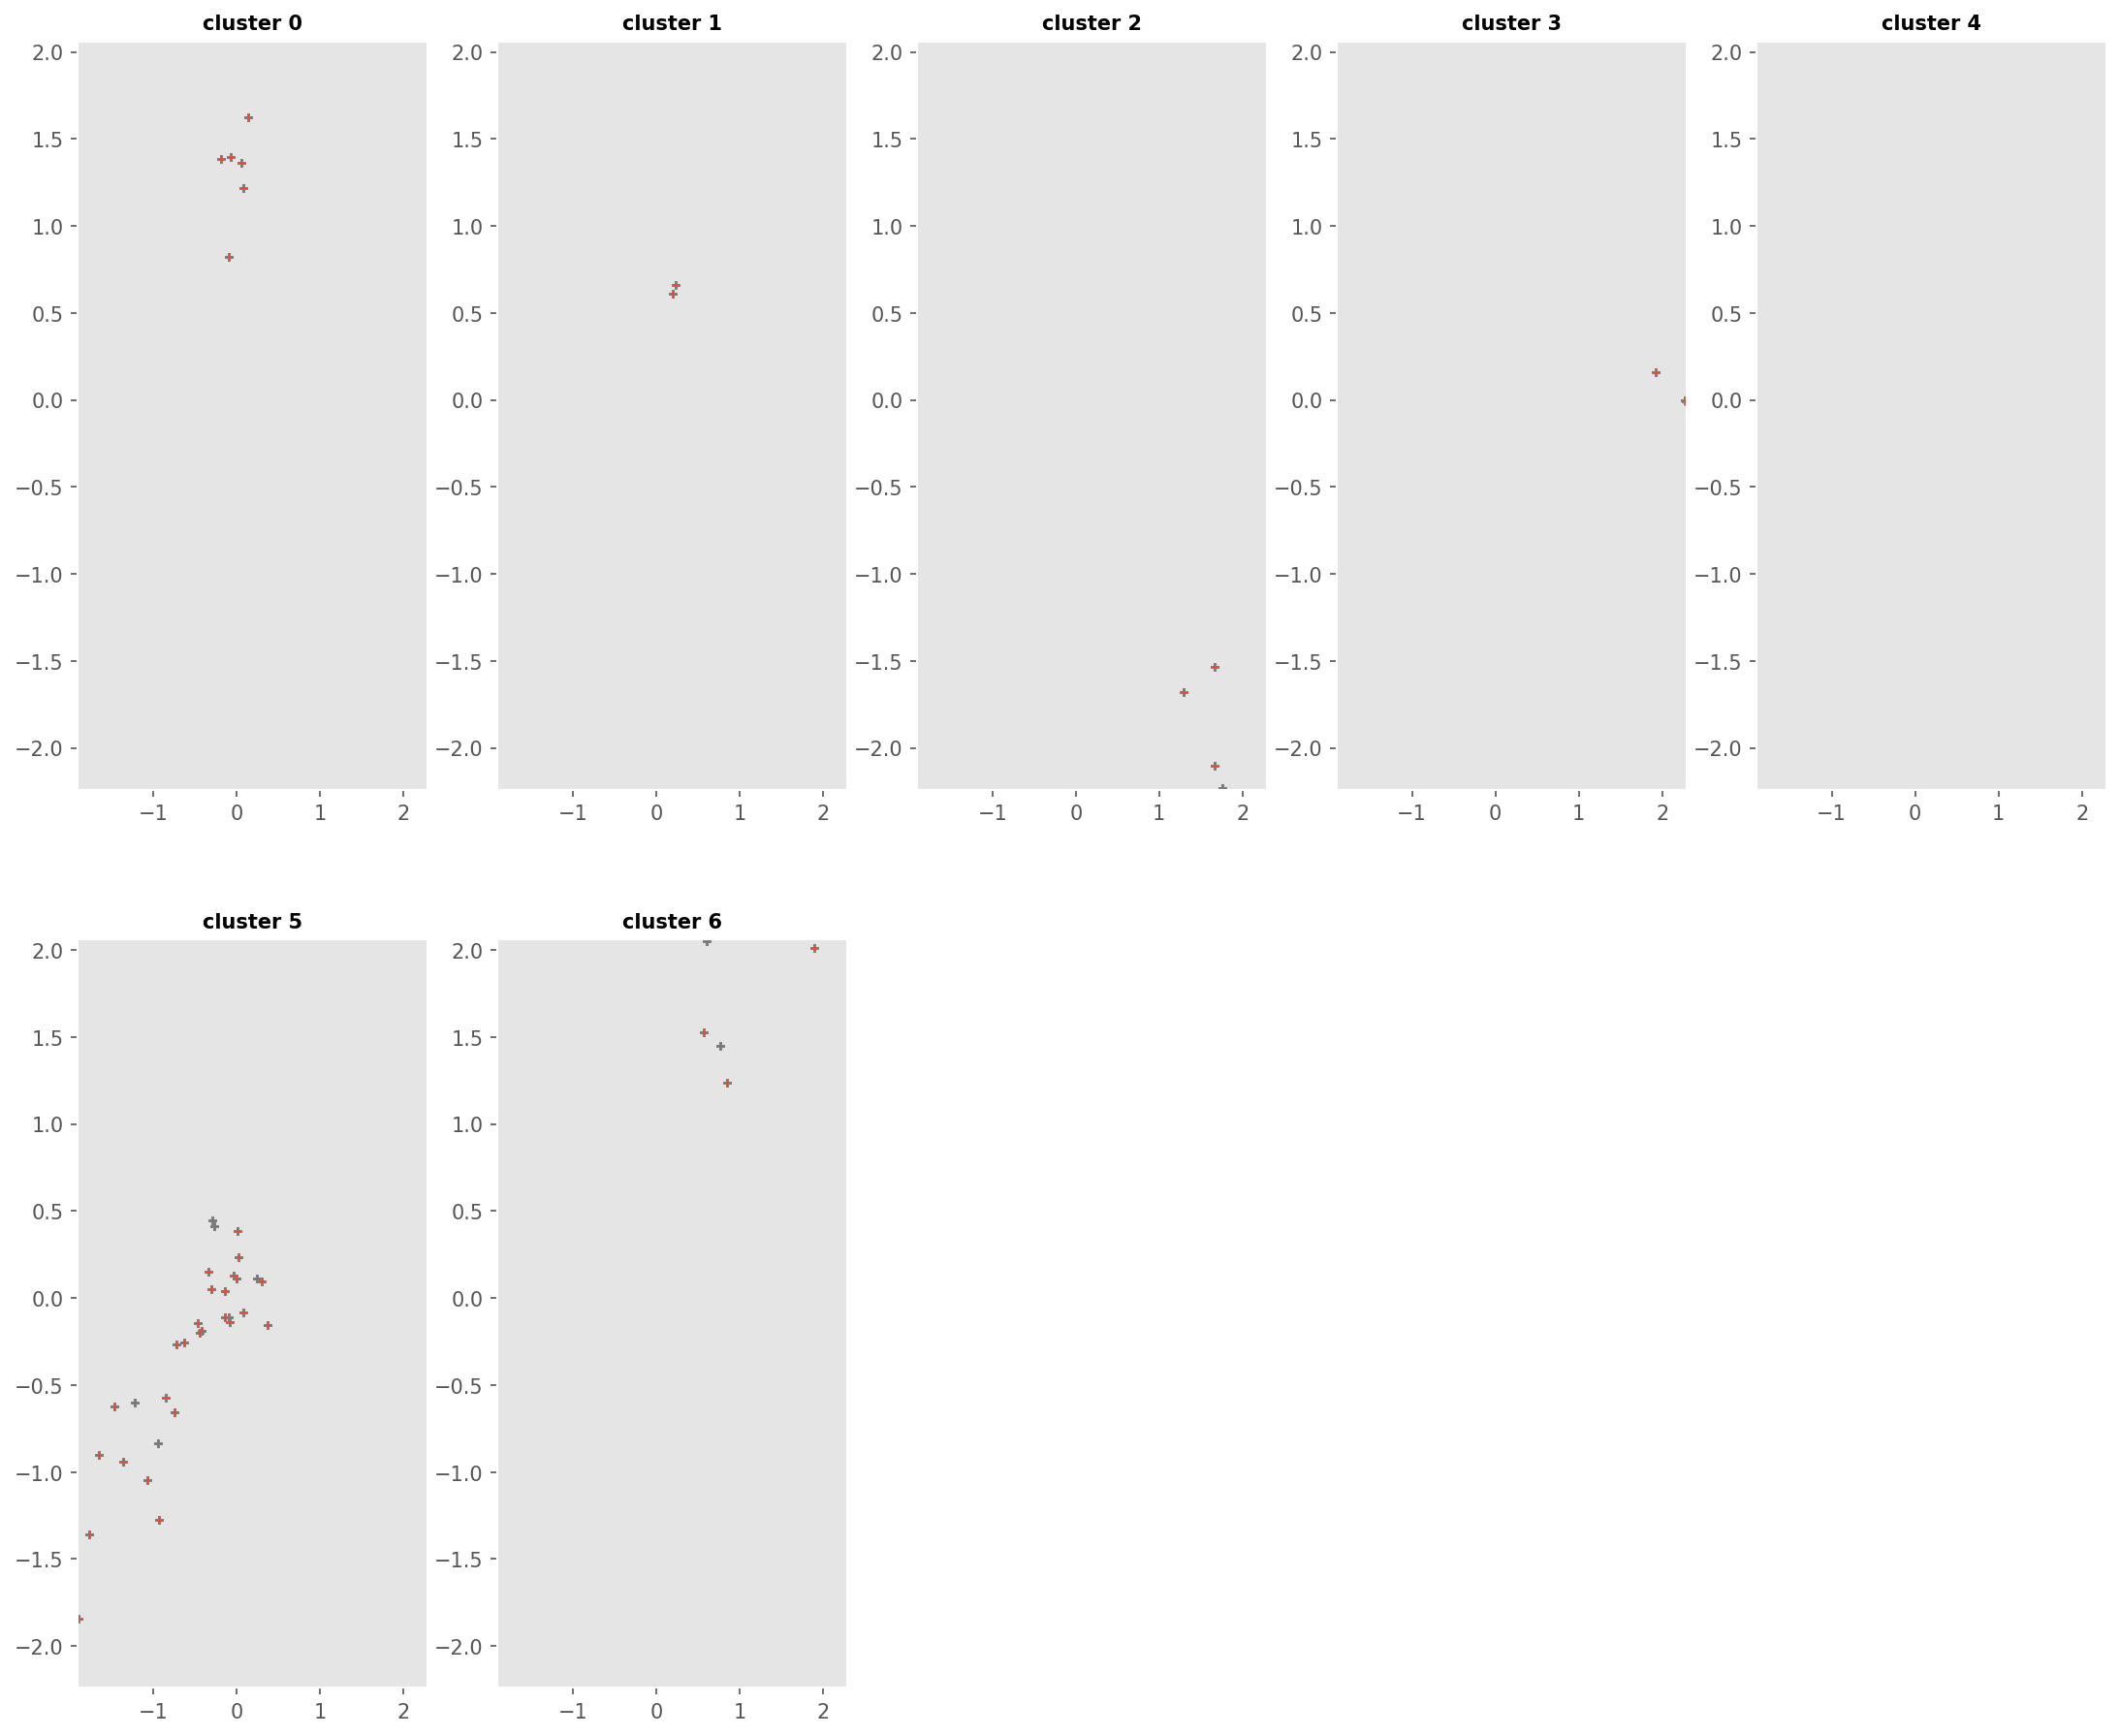

<Figure size 2700x2250 with 0 Axes>

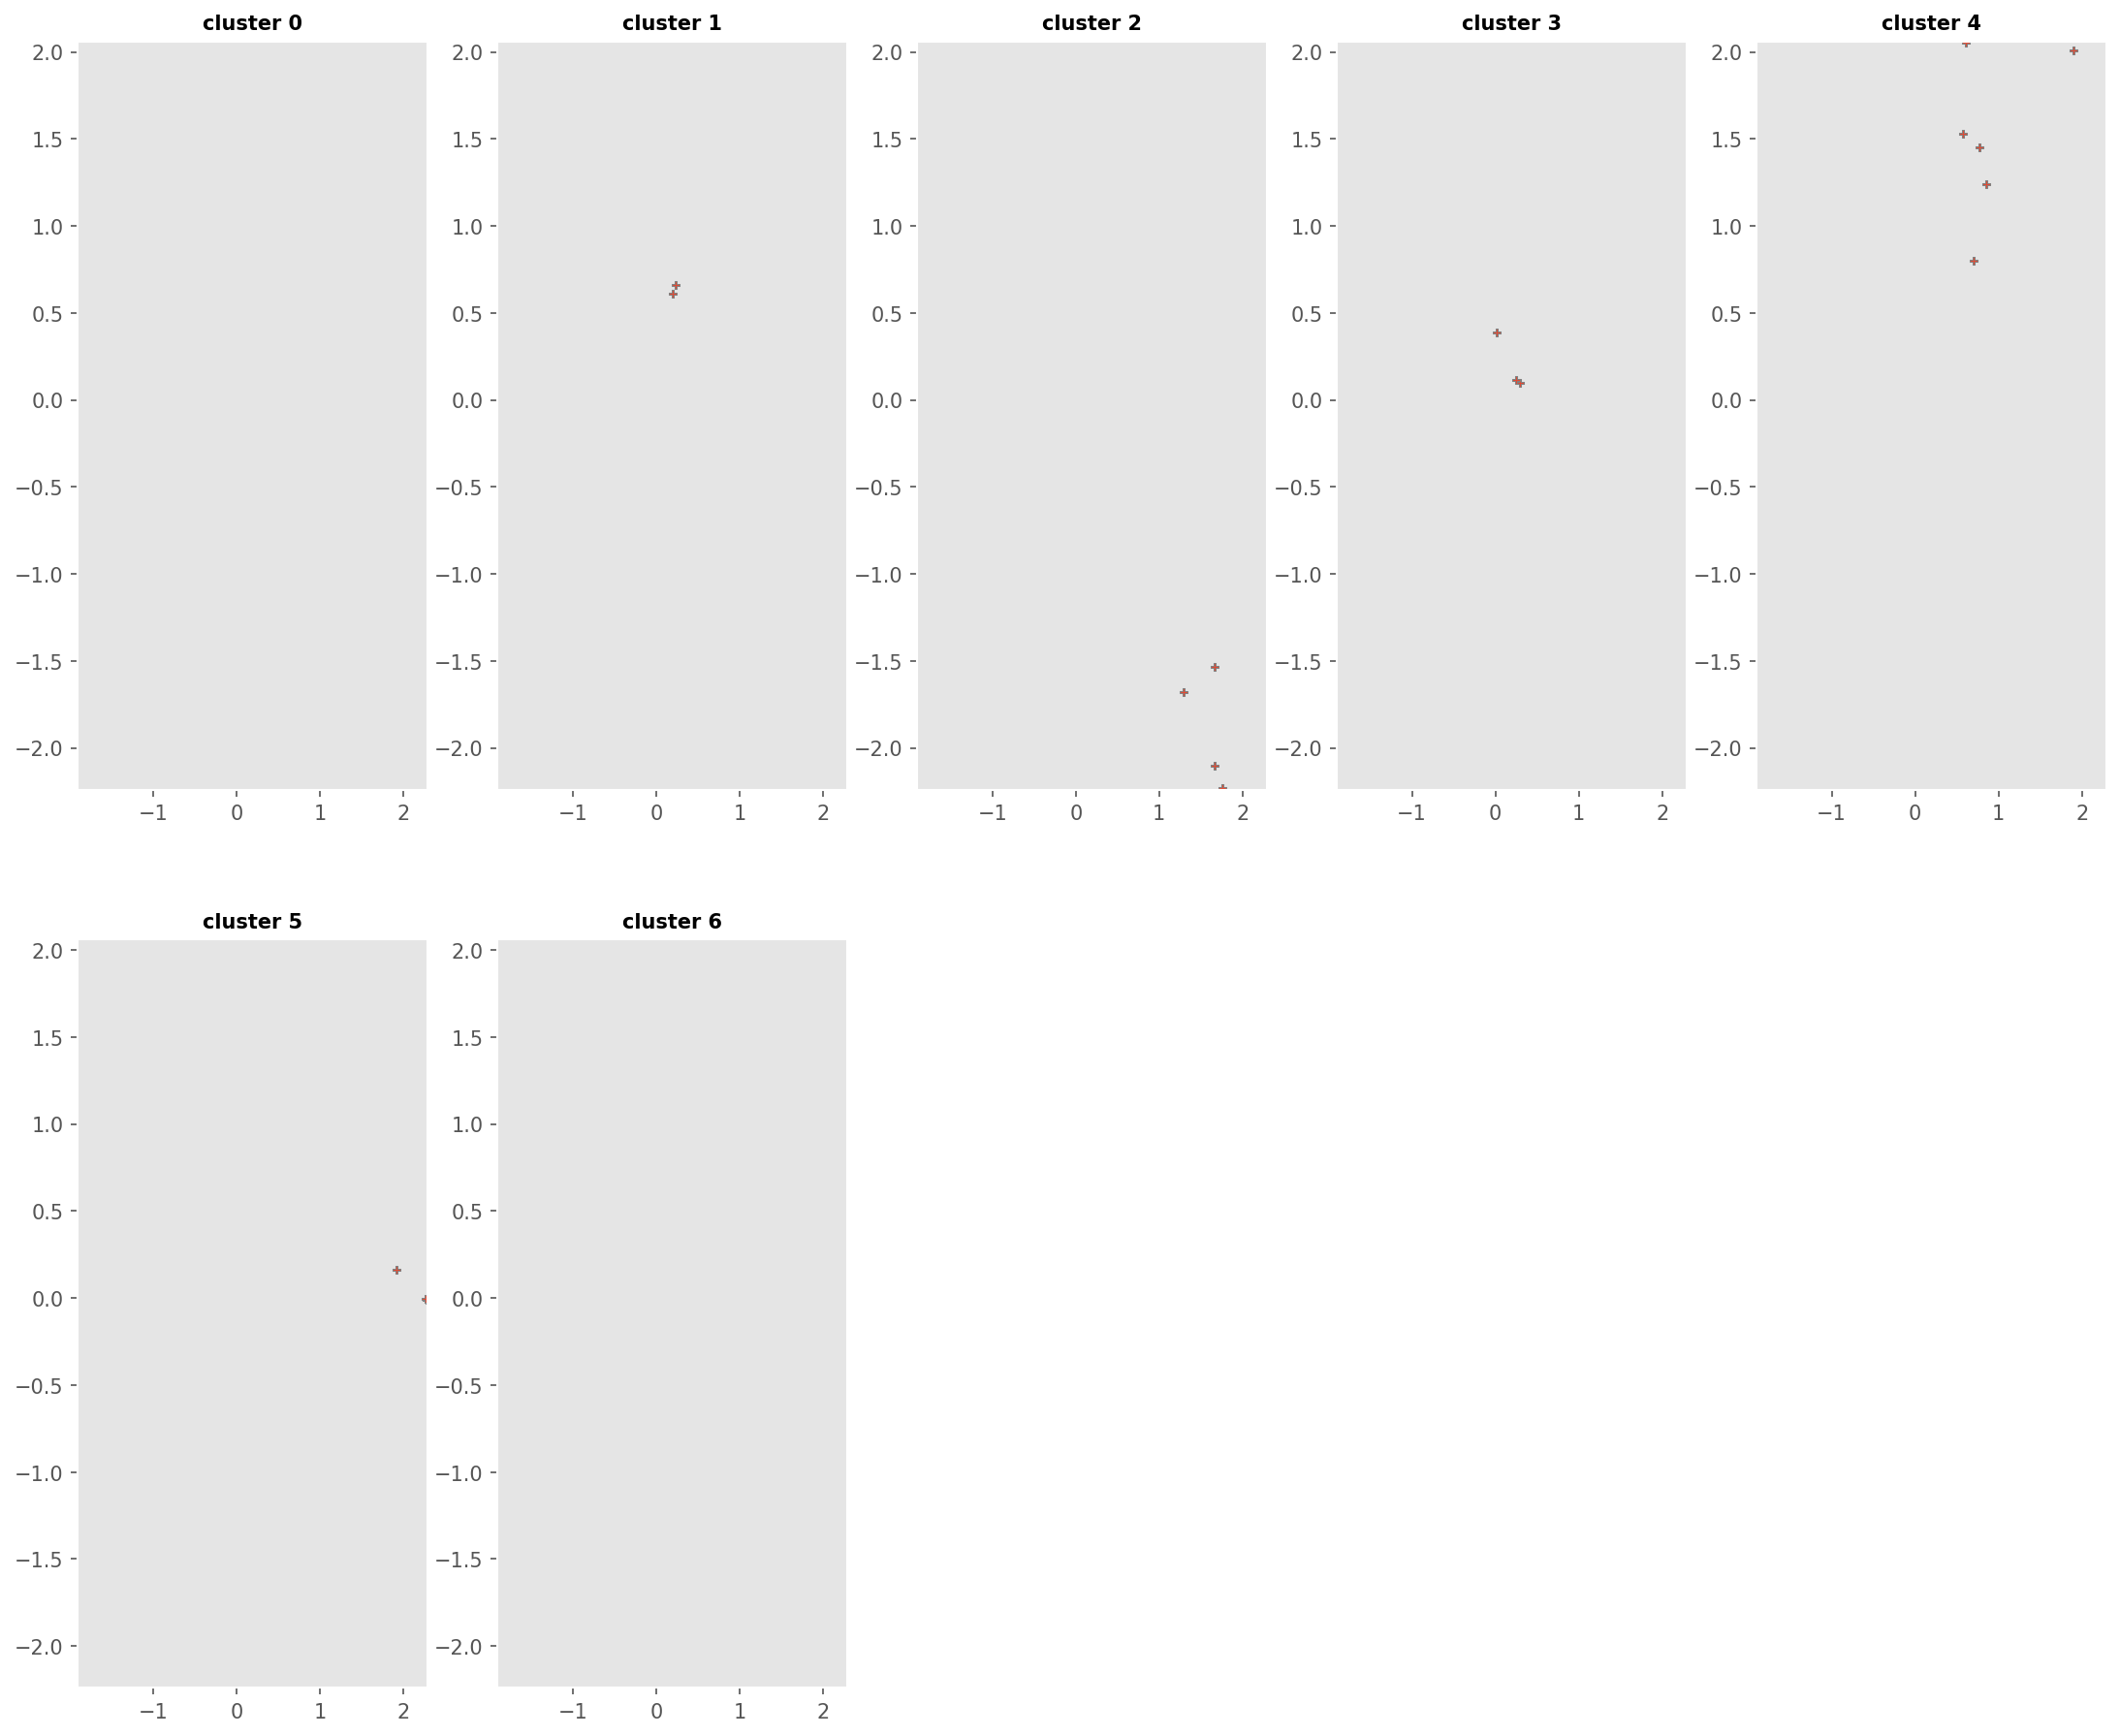

In [100]:
for i in range(n):
    num = k[i]
    est_std = kmean_std[k[i]-1]
    center =  [ est_std.cluster_centers_[0], est_std.cluster_centers_[1]]
    df['cluster_std'] = est_std.predict(X_std).tolist()
    font = {'weight' : 'bold','size'   : 10}
    cl = len(list(df['cluster_std_%d' %num].unique()))
    plt.figure()
    plt.subplots(nrows=cl//4, ncols=5, figsize=(18,15))
    plt.axis('off')
    plt.grid(False)

    plt.title("Spatial Clustering with KMeans (k={})".format(k[i]), **font)
    for nc in range(cl):
      ax = plt.subplot(cl//5+1, 5, nc+1)
      ax.set_title("cluster %d" %nc, **font)
      plot_stations_individuals_std(ax, df,nc,'cluster_std_%d' %num)


<Figure size 2700x2250 with 0 Axes>

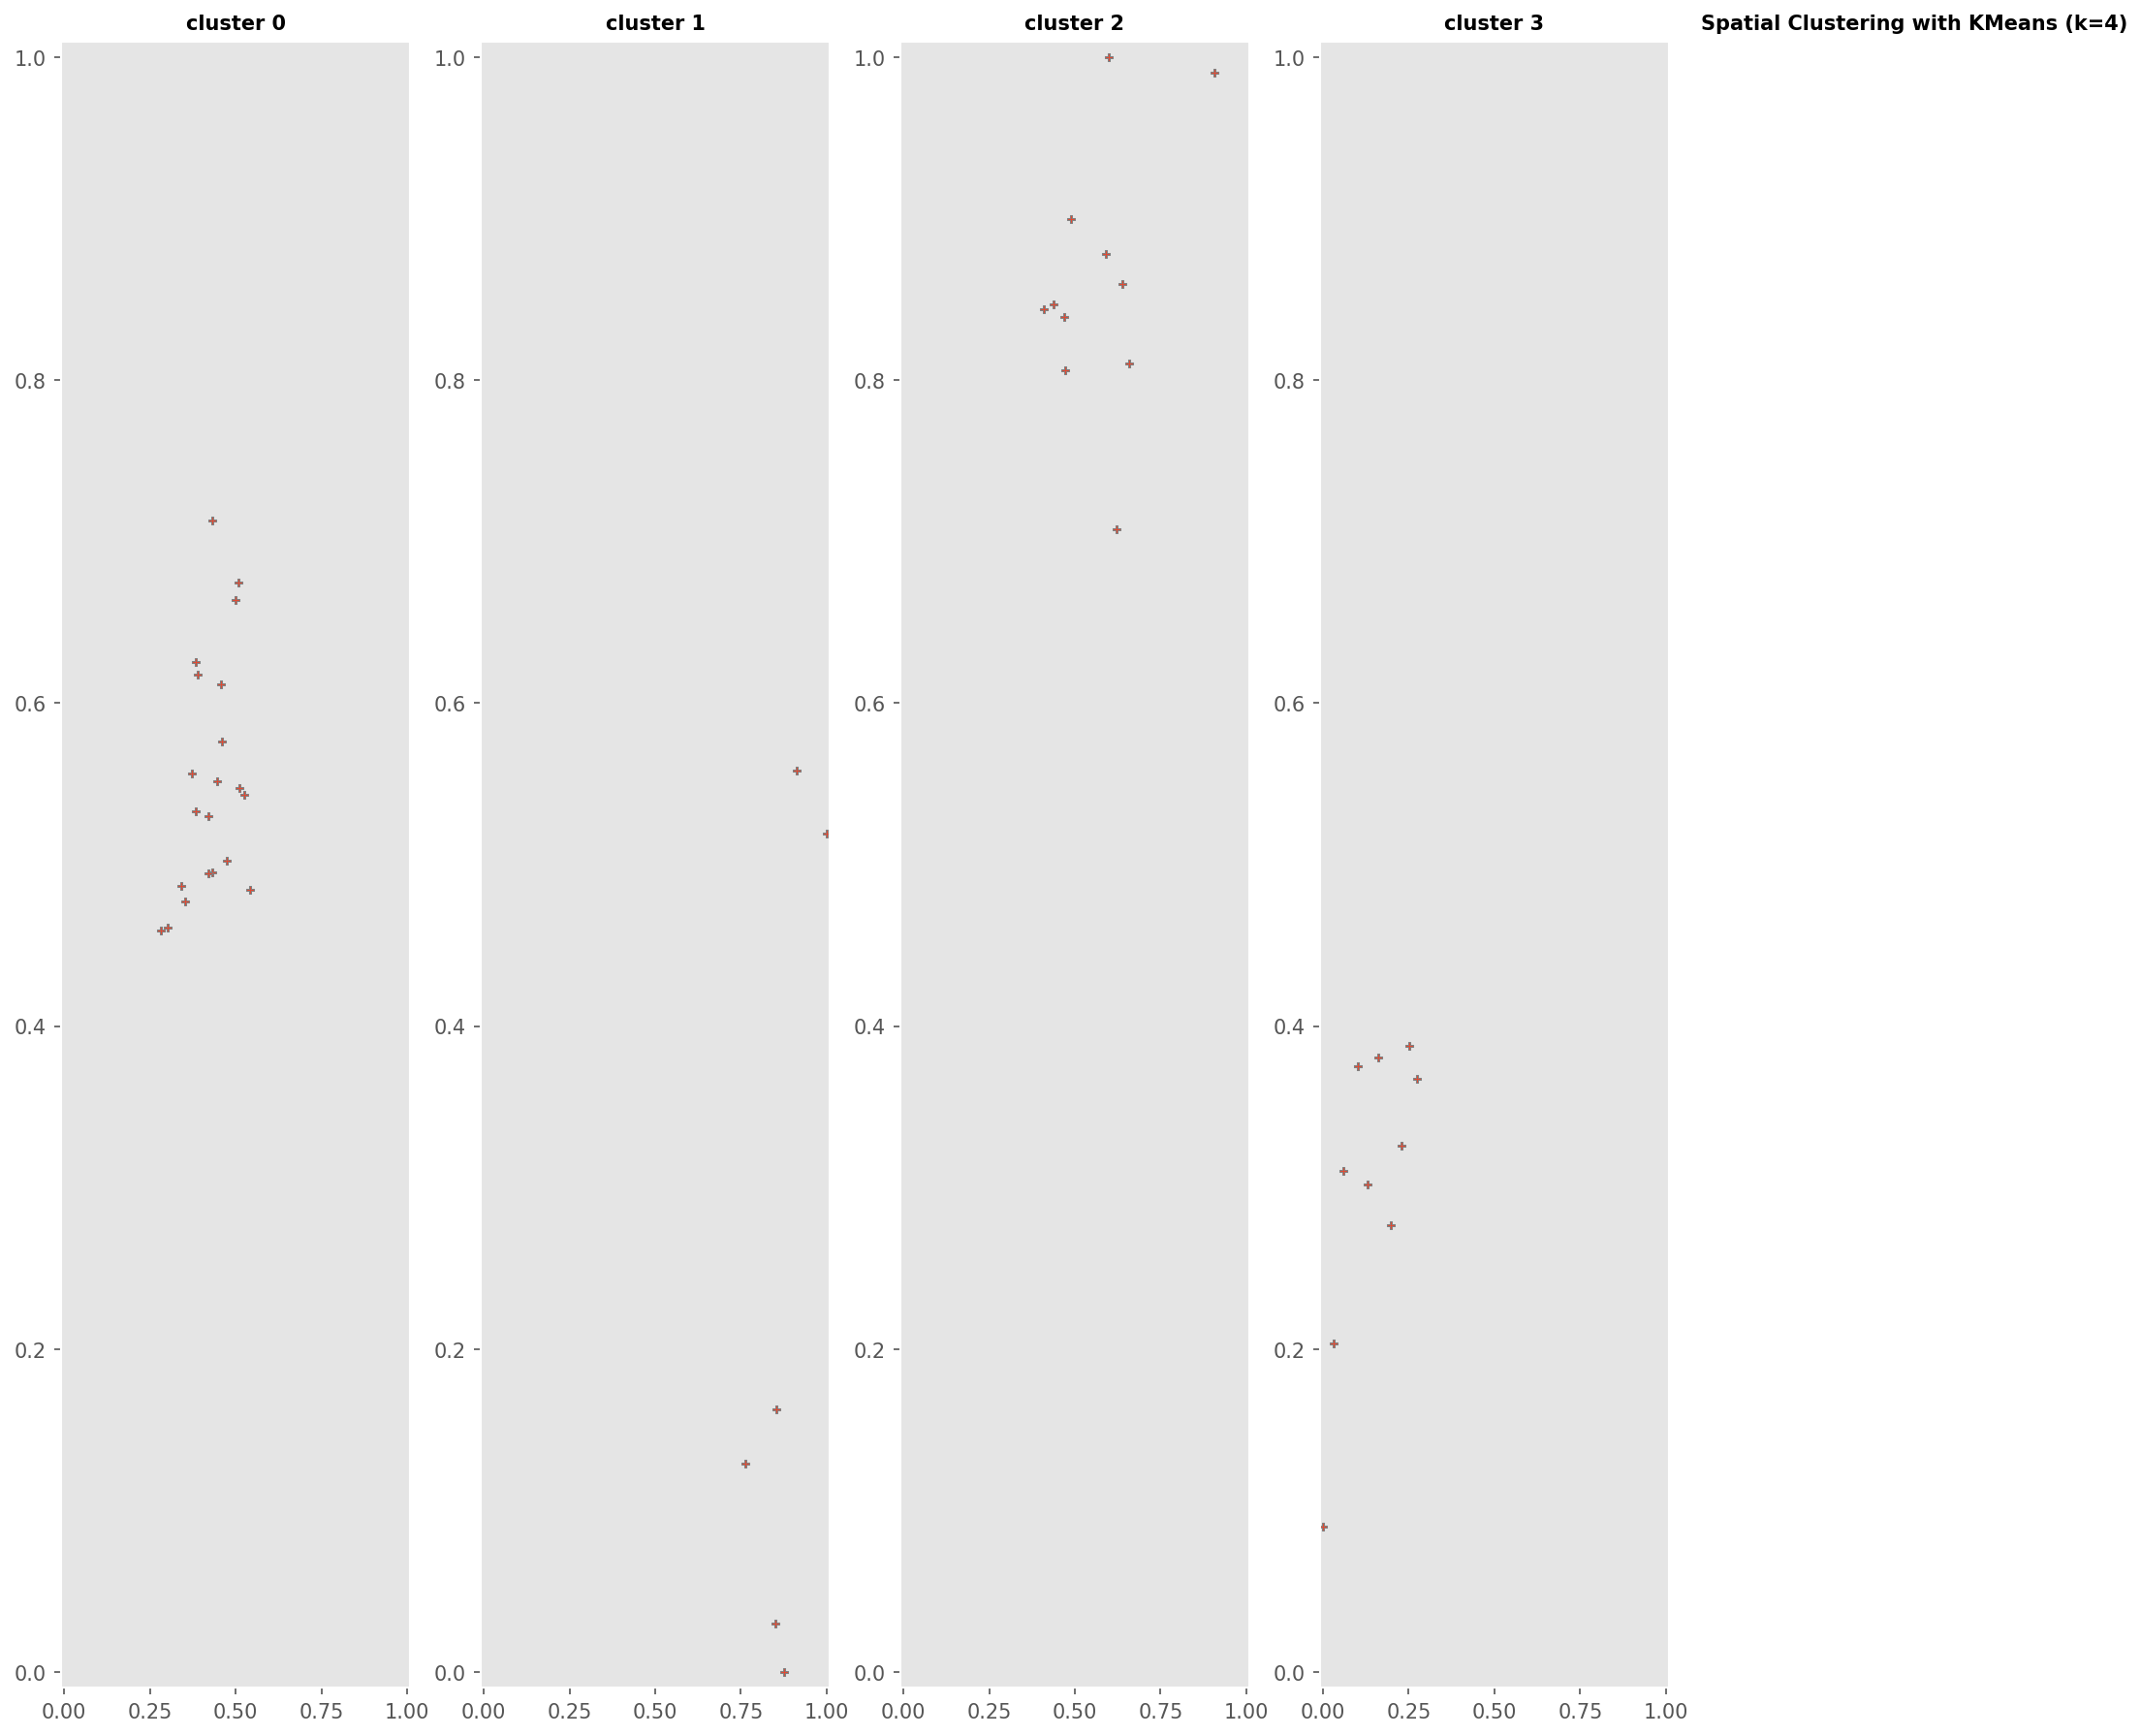

<Figure size 2700x2250 with 0 Axes>

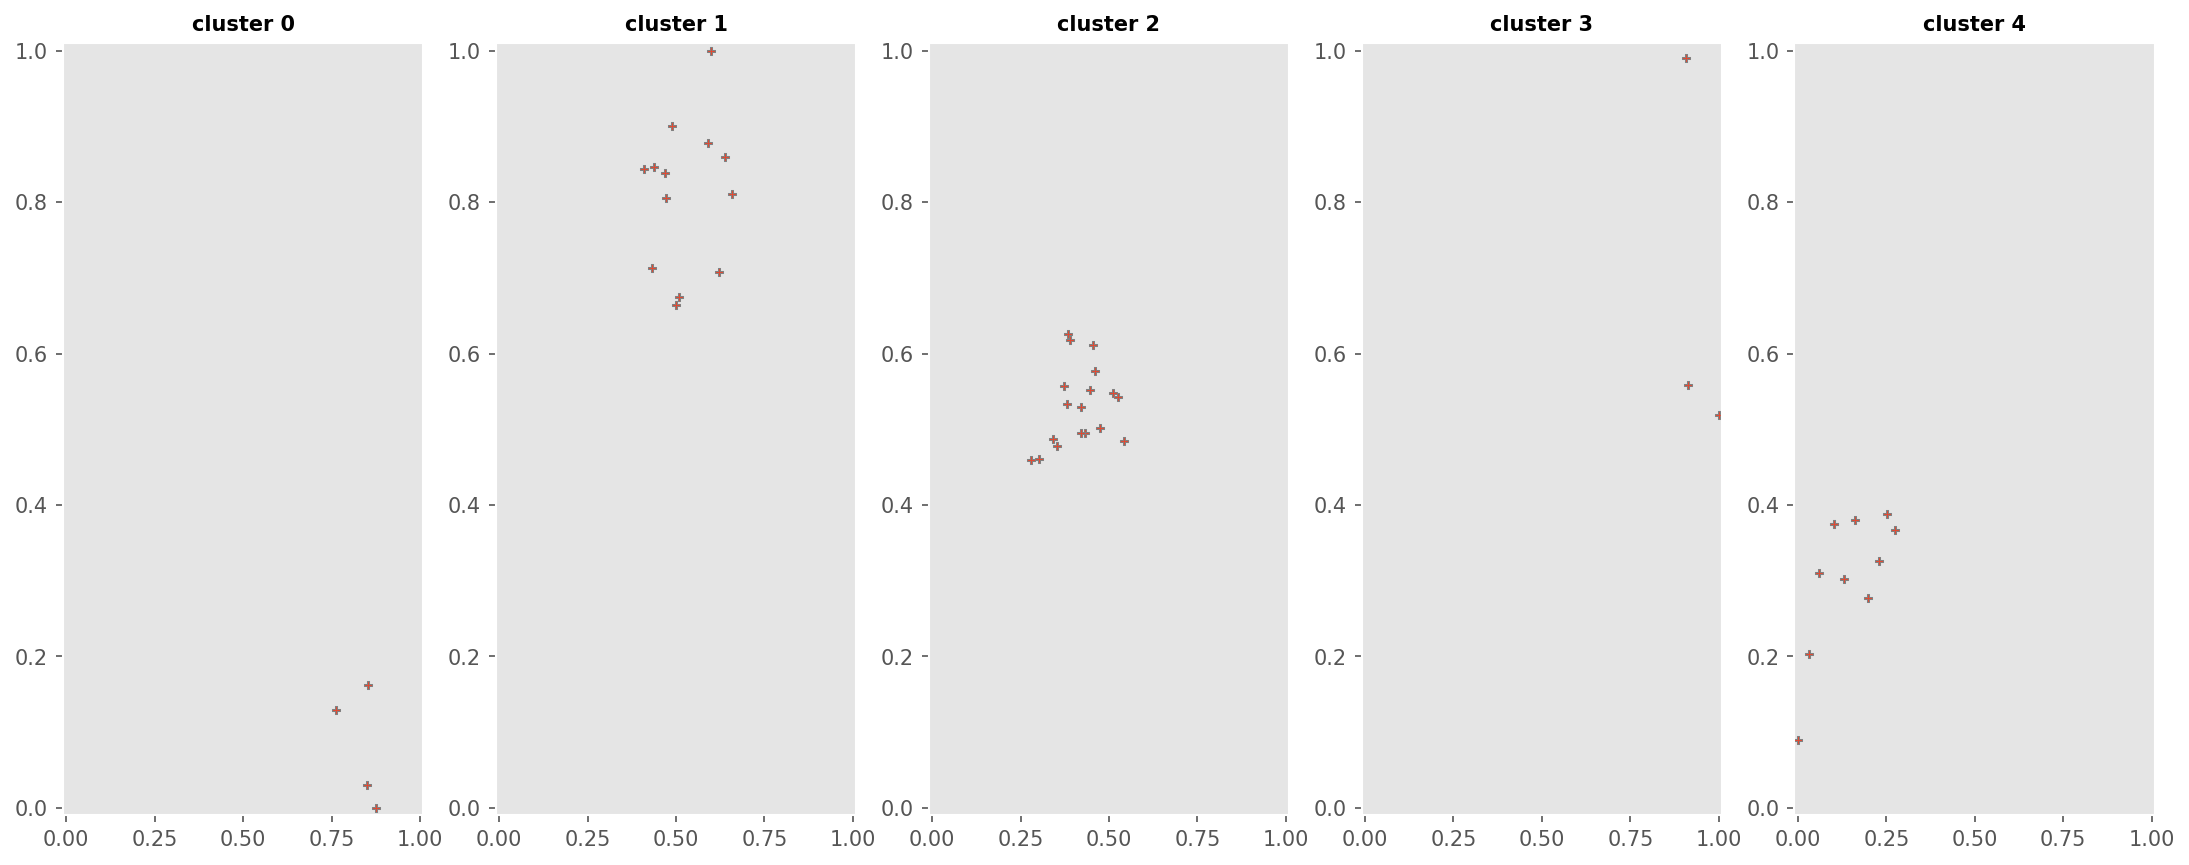

<Figure size 2700x2250 with 0 Axes>

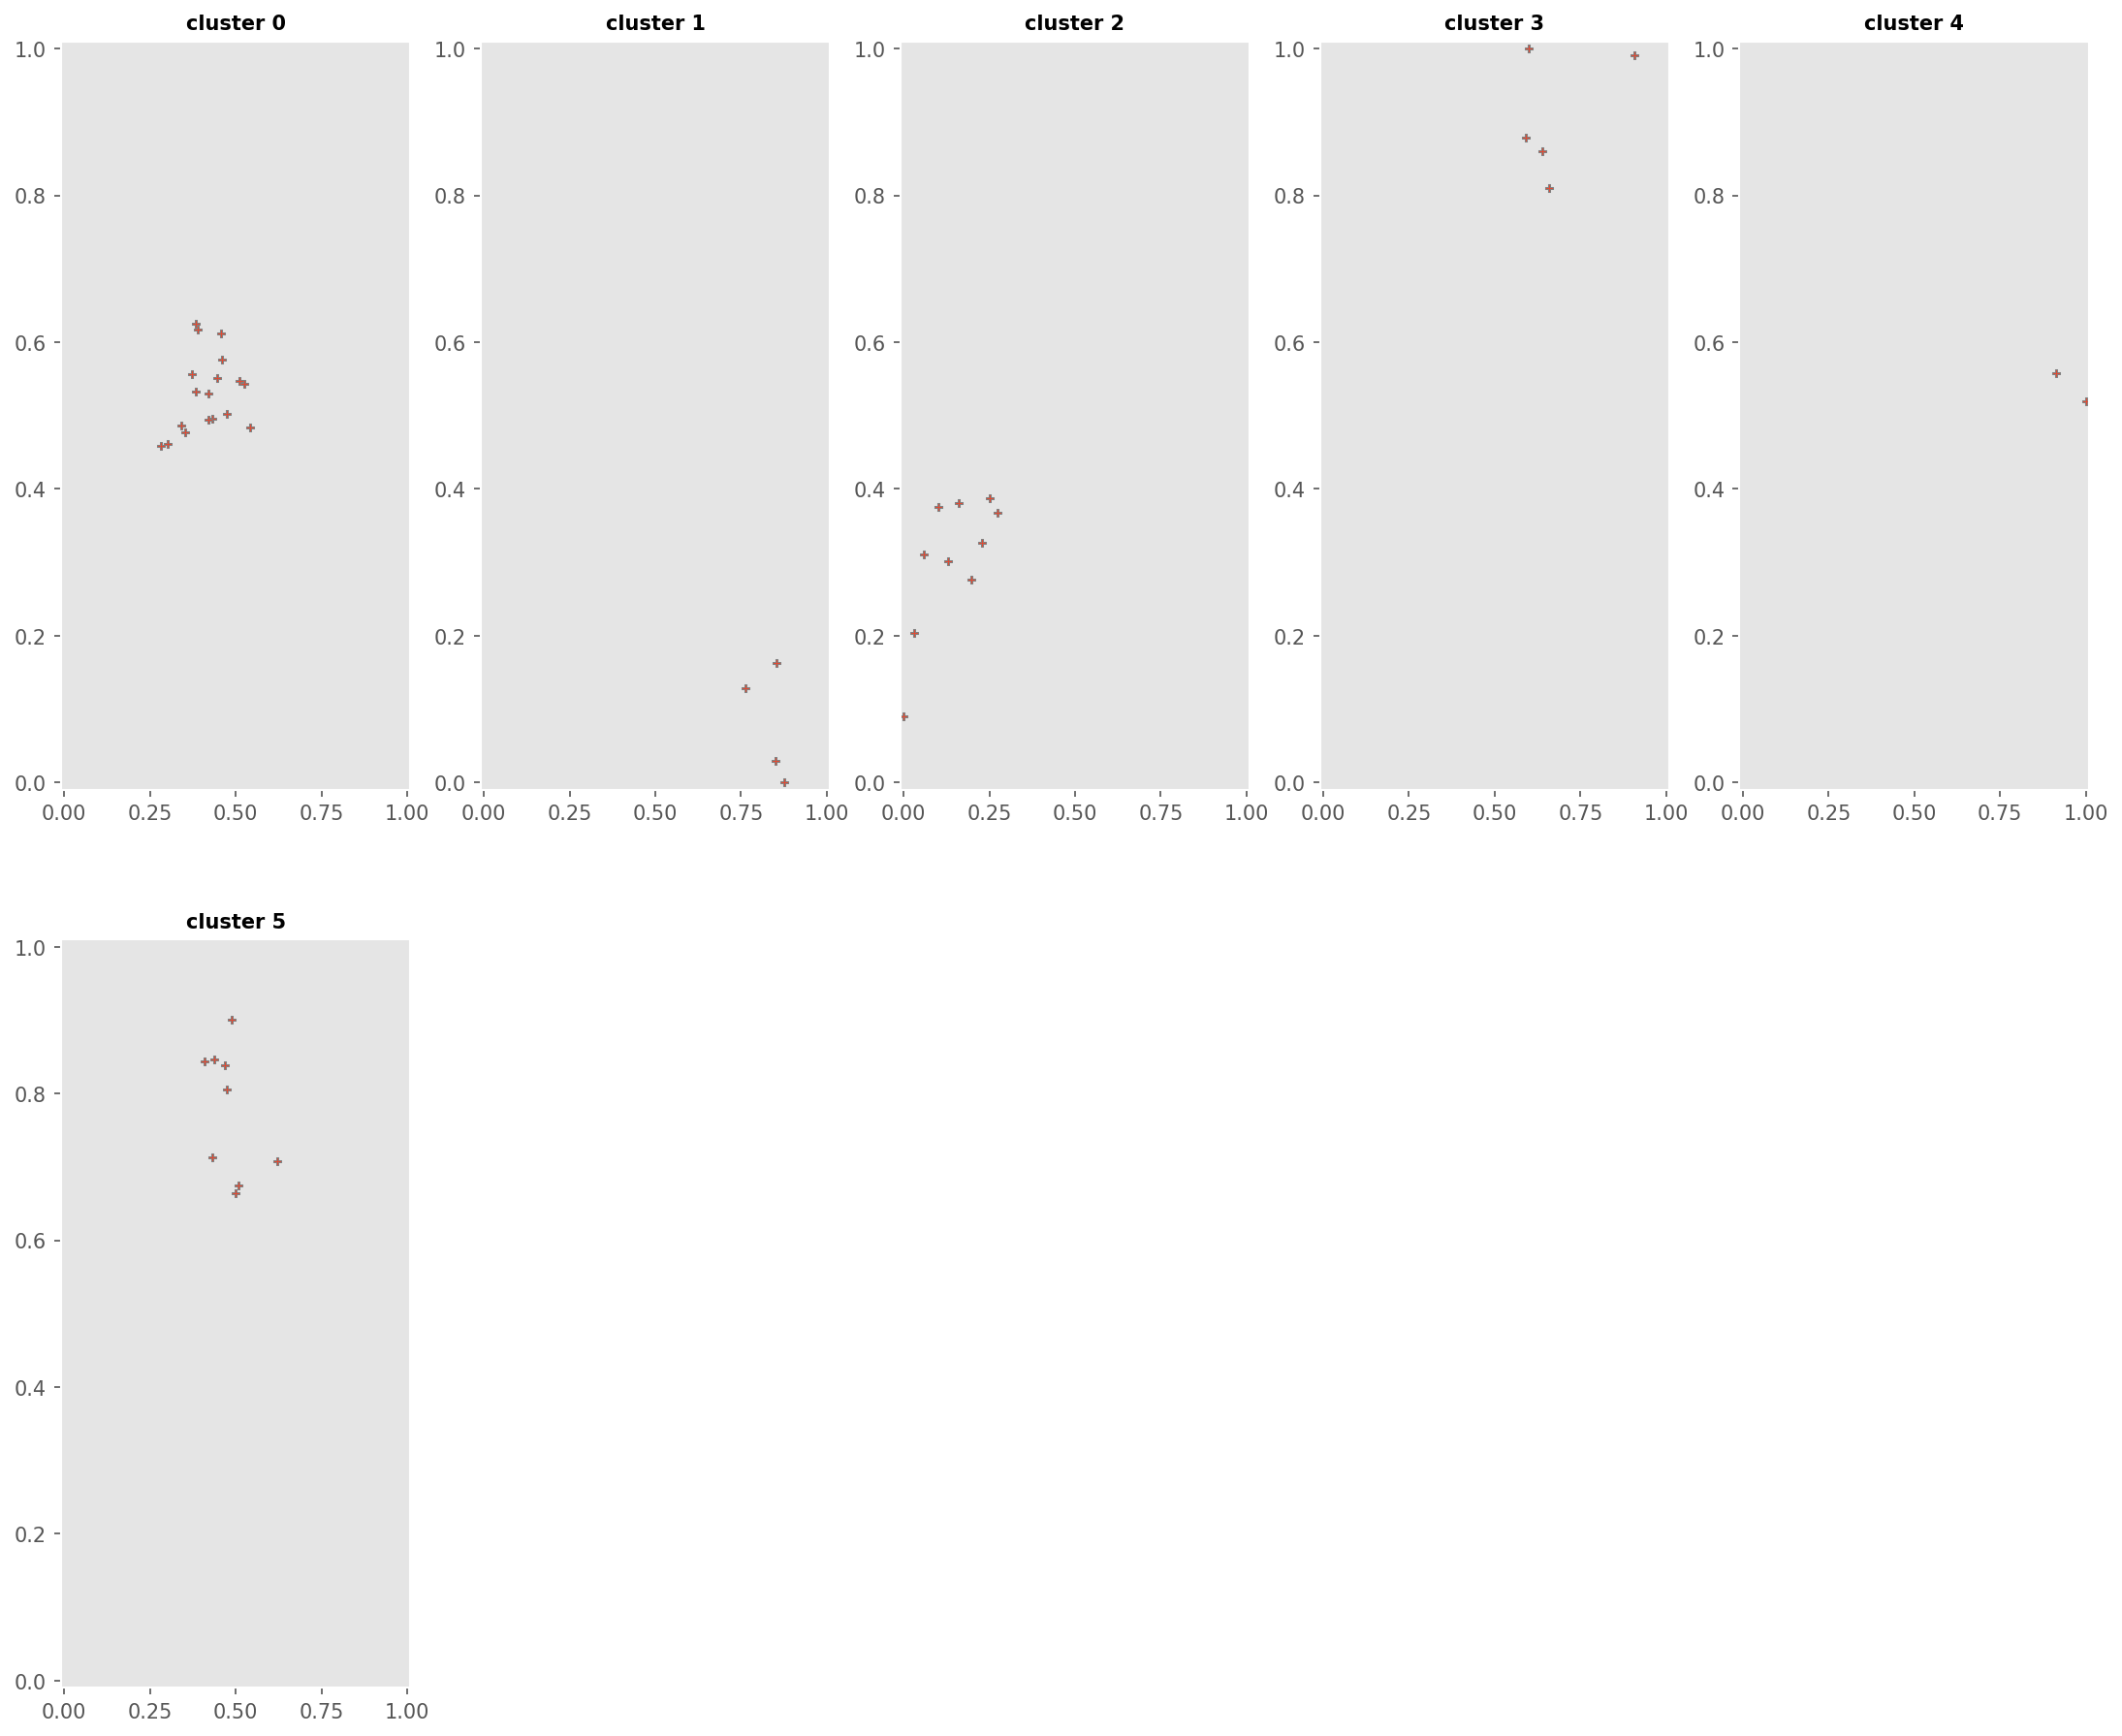

<Figure size 2700x2250 with 0 Axes>

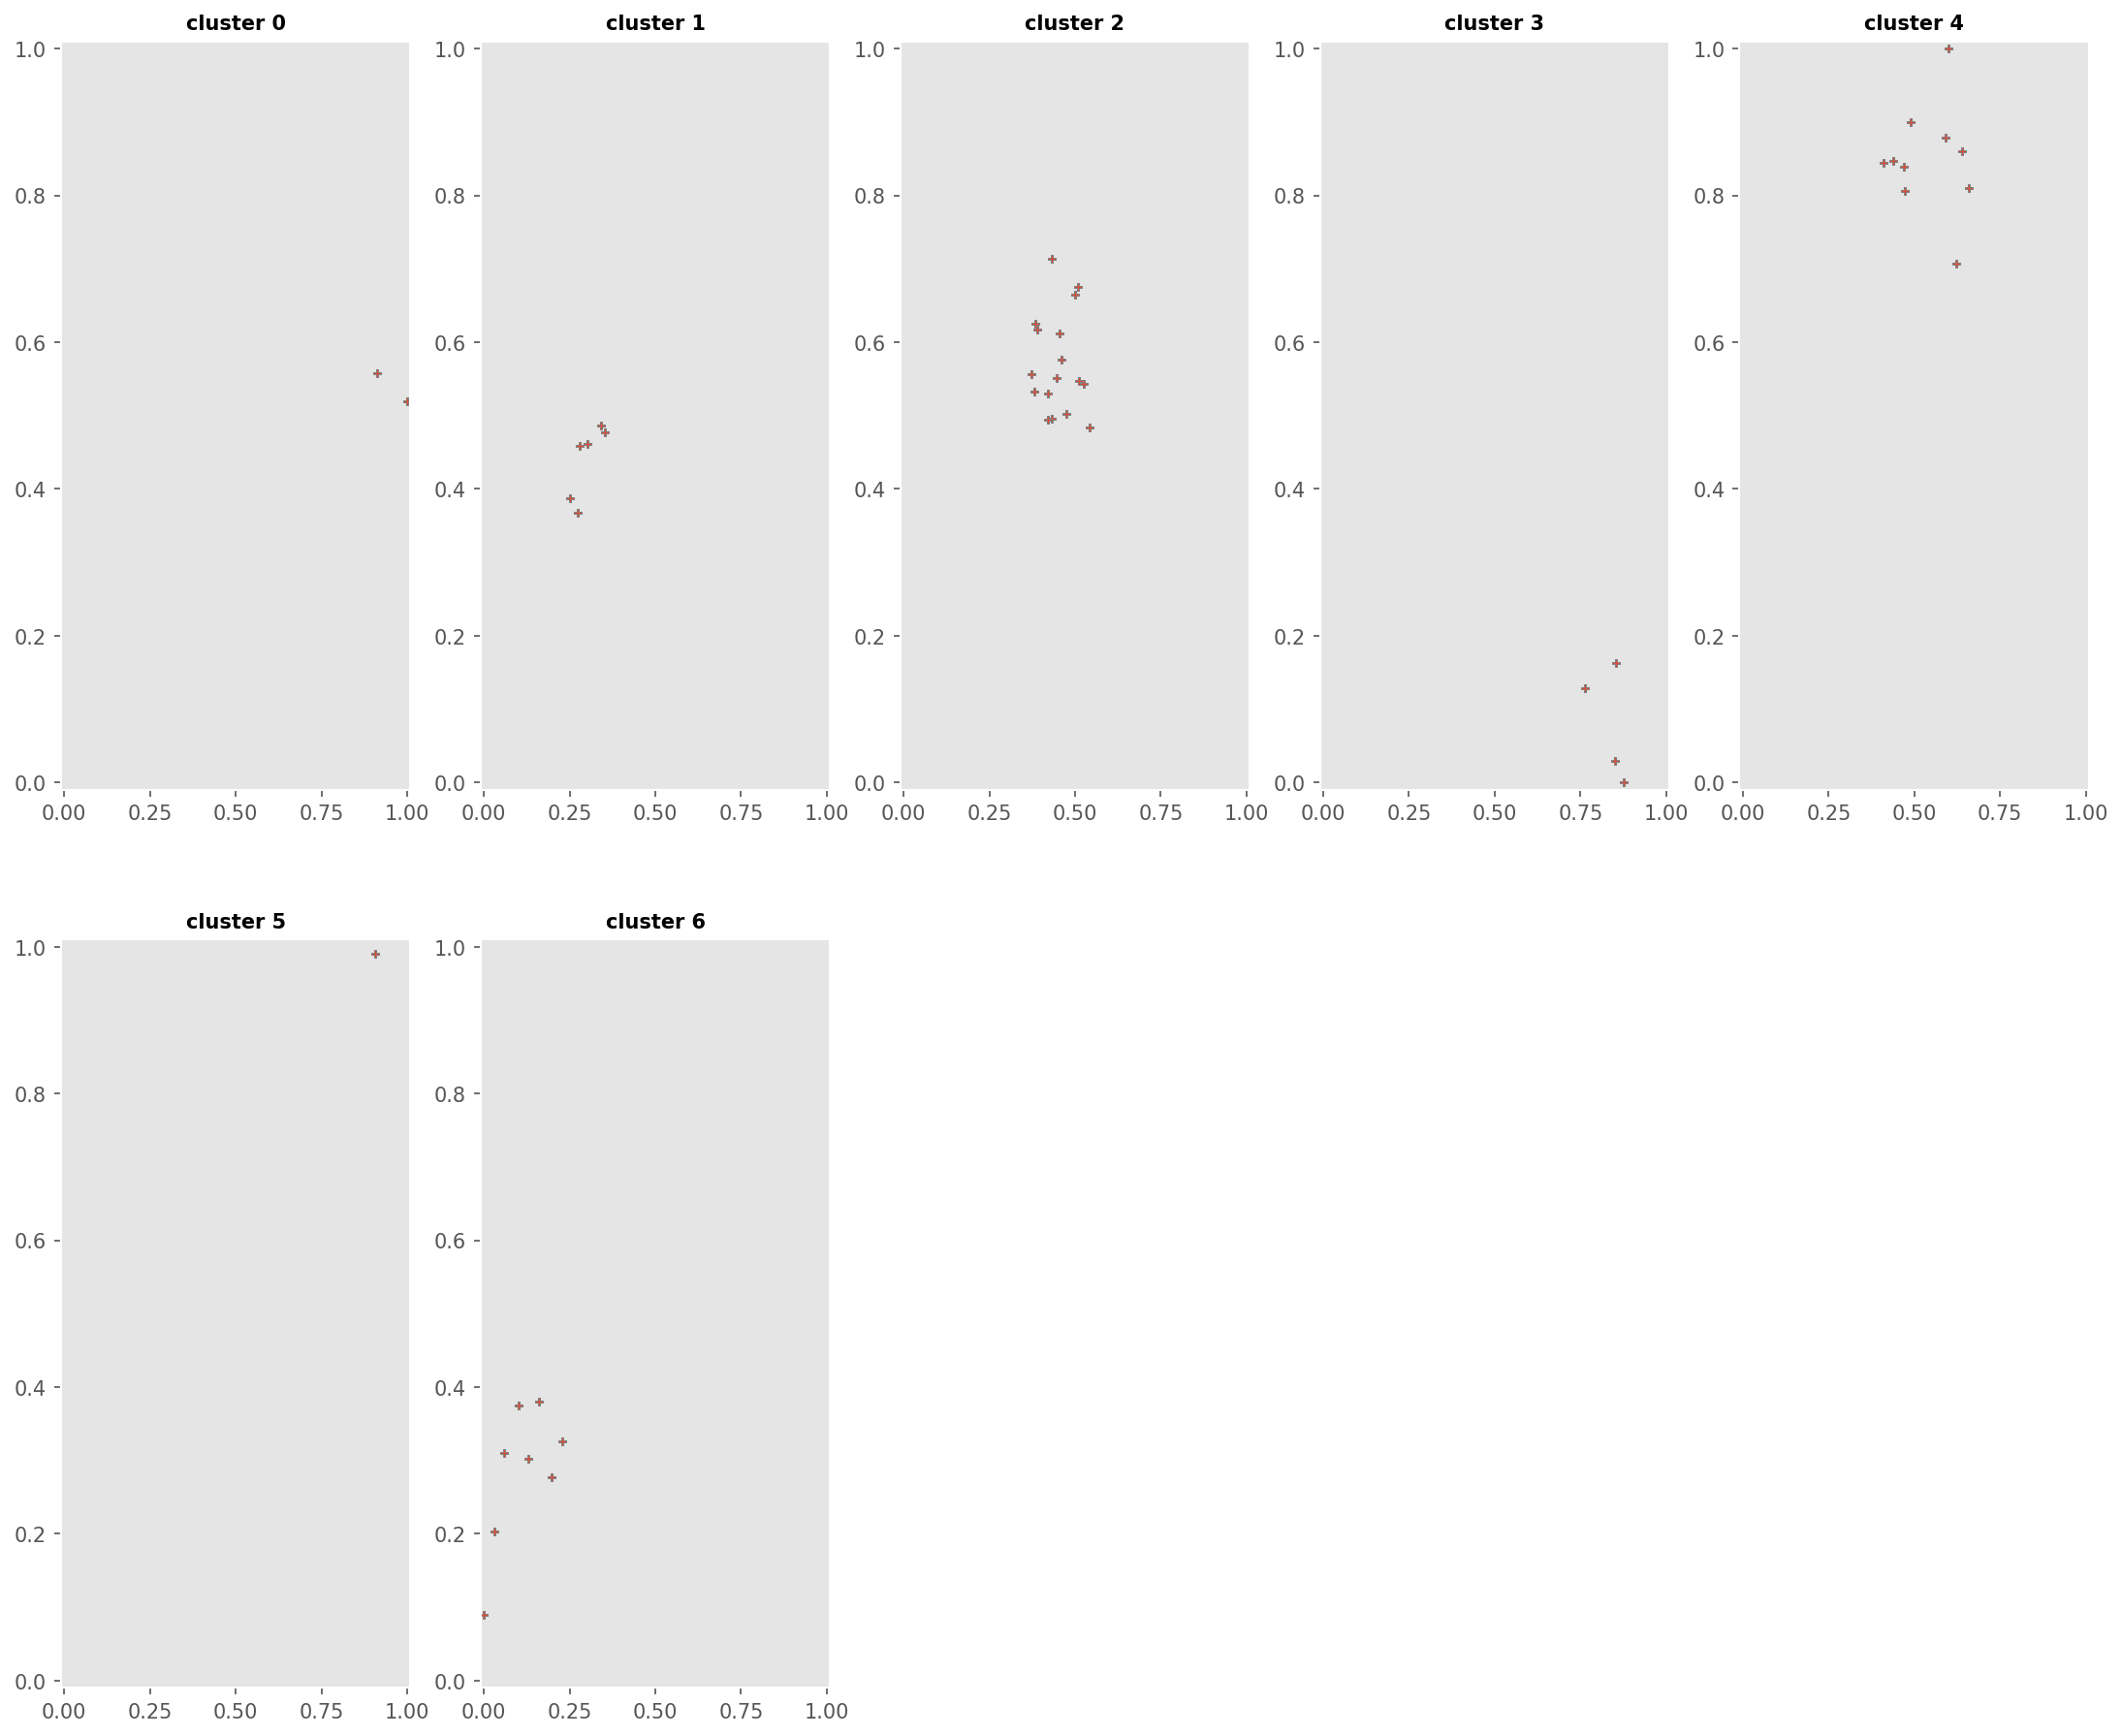

<Figure size 2700x2250 with 0 Axes>

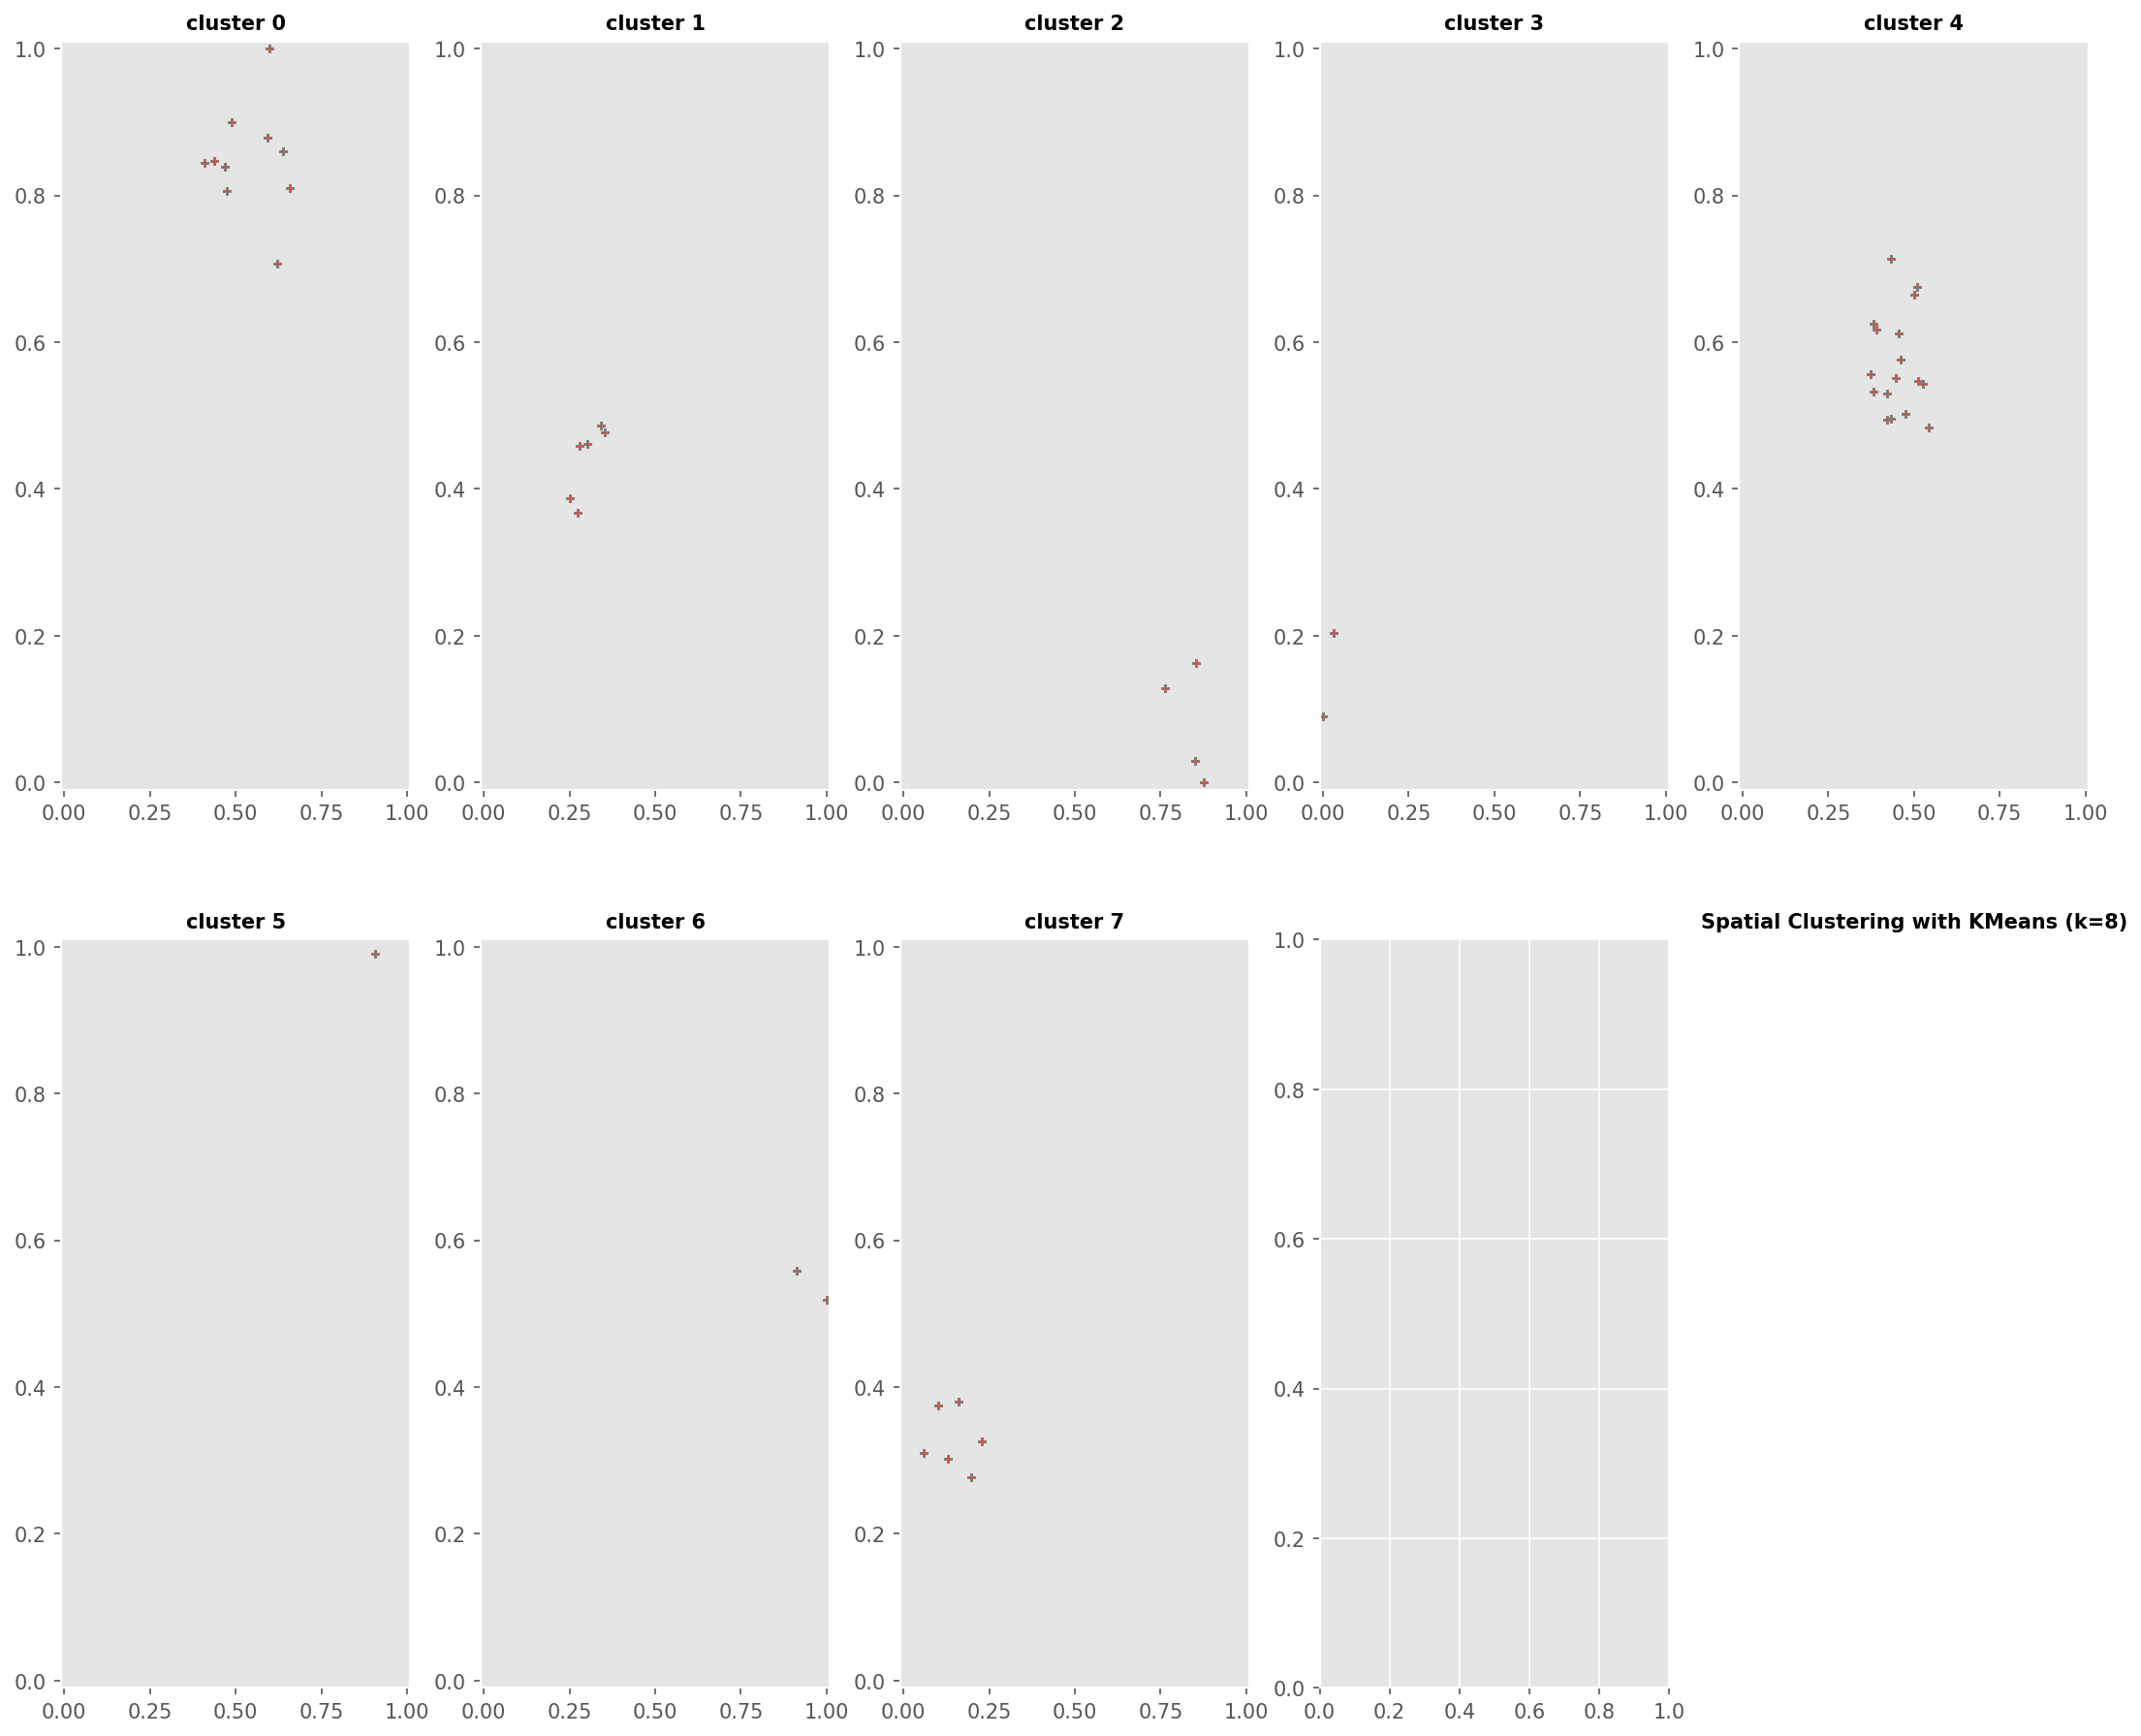

<Figure size 2700x2250 with 0 Axes>

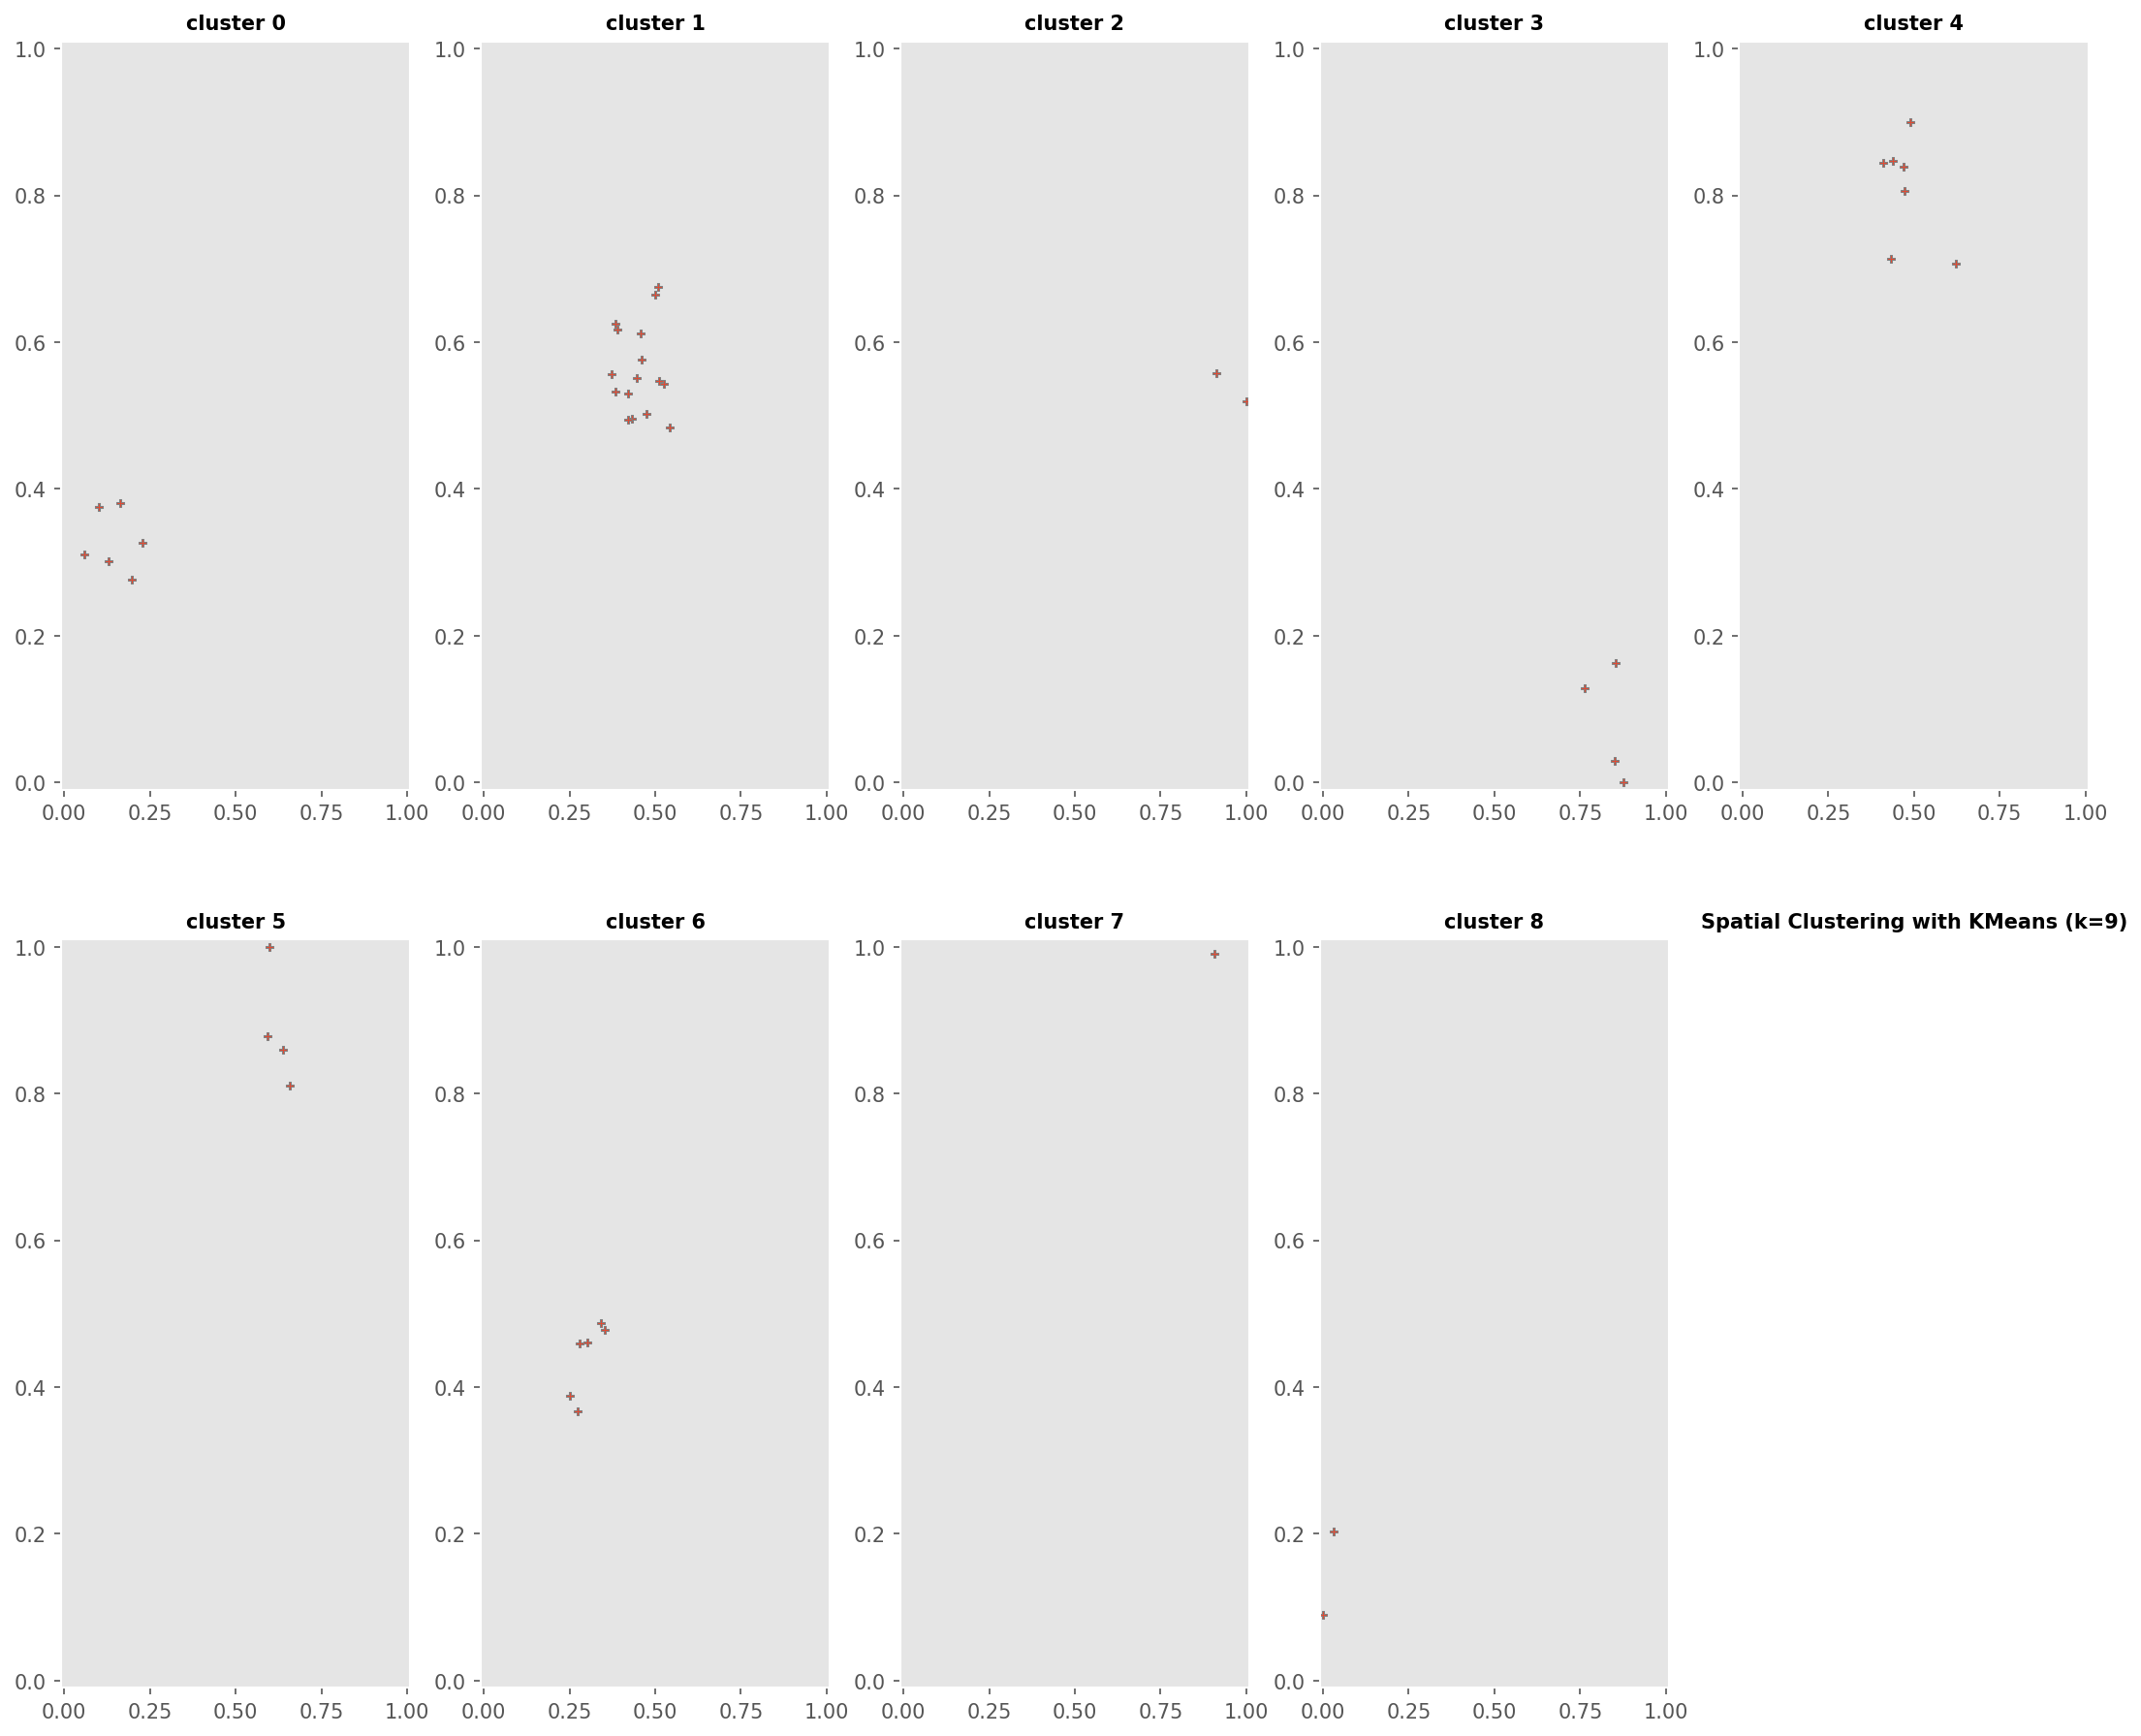

In [24]:
for i in range(n):
    num = k[i]
    est_norm = kmean_norm[k[i]-1]
    center =  [ est_norm.cluster_centers_[0], est_norm.cluster_centers_[1]]
    df['cluster_norm'] = est_norm.predict(X_norm).tolist()
    font = {'weight' : 'bold','size'   : 10}
    cl = len(list(df['cluster_norm_%d' %num].unique()))
    plt.figure()
    plt.subplots(nrows=cl//4, ncols=5, figsize=(18,15))
    plt.axis('off')
    plt.grid(False)

    plt.title("Spatial Clustering with KMeans (k={})".format(k[i]), **font)
    for nc in range(cl):
      ax = plt.subplot(cl//5+1, 5, nc+1)
      ax.set_title("cluster %d" %nc, **font)
      plot_stations_individuals_norm(ax, df,nc,'cluster_norm_%d' %num)

In [25]:
def plot_for_clustering(k,km,df,norm,N):
    num = k
    est = km[k-1]
    centers = est.cluster_centers_
    df['cluster%s_%d' %(norm,num)] = est.predict(N).tolist()
    cl = len(list(df['cluster%s_%d' %(norm,num)].unique()))
    plt.figure()
    plt.axis('off')
    plt.grid(False)
    lat = list(df['latitud%s' %norm])
    lon = list(df['longitud%s' %norm])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    plt.xlim([lon_min, lon_max])
    plt.ylim([lat_min, lat_max])    

    colors = iter(cm.Set1(np.linspace(0, 1, 15)))
    for nc in range(cl):   
        g = df.loc[df['cluster%s_%d' %(norm,k)] == nc]
        color = next(colors)     
        print(color)
        plt.scatter(g['longitud%s' %norm],g['latitud%s' %norm] , color=color,marker = 'o', zorder=2, alpha=1.0, s=50)
        plt.scatter(centers[nc][1],centers[nc][0], marker = '^', color=color, s=100)


[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]
[1.  1.  0.2 1. ]


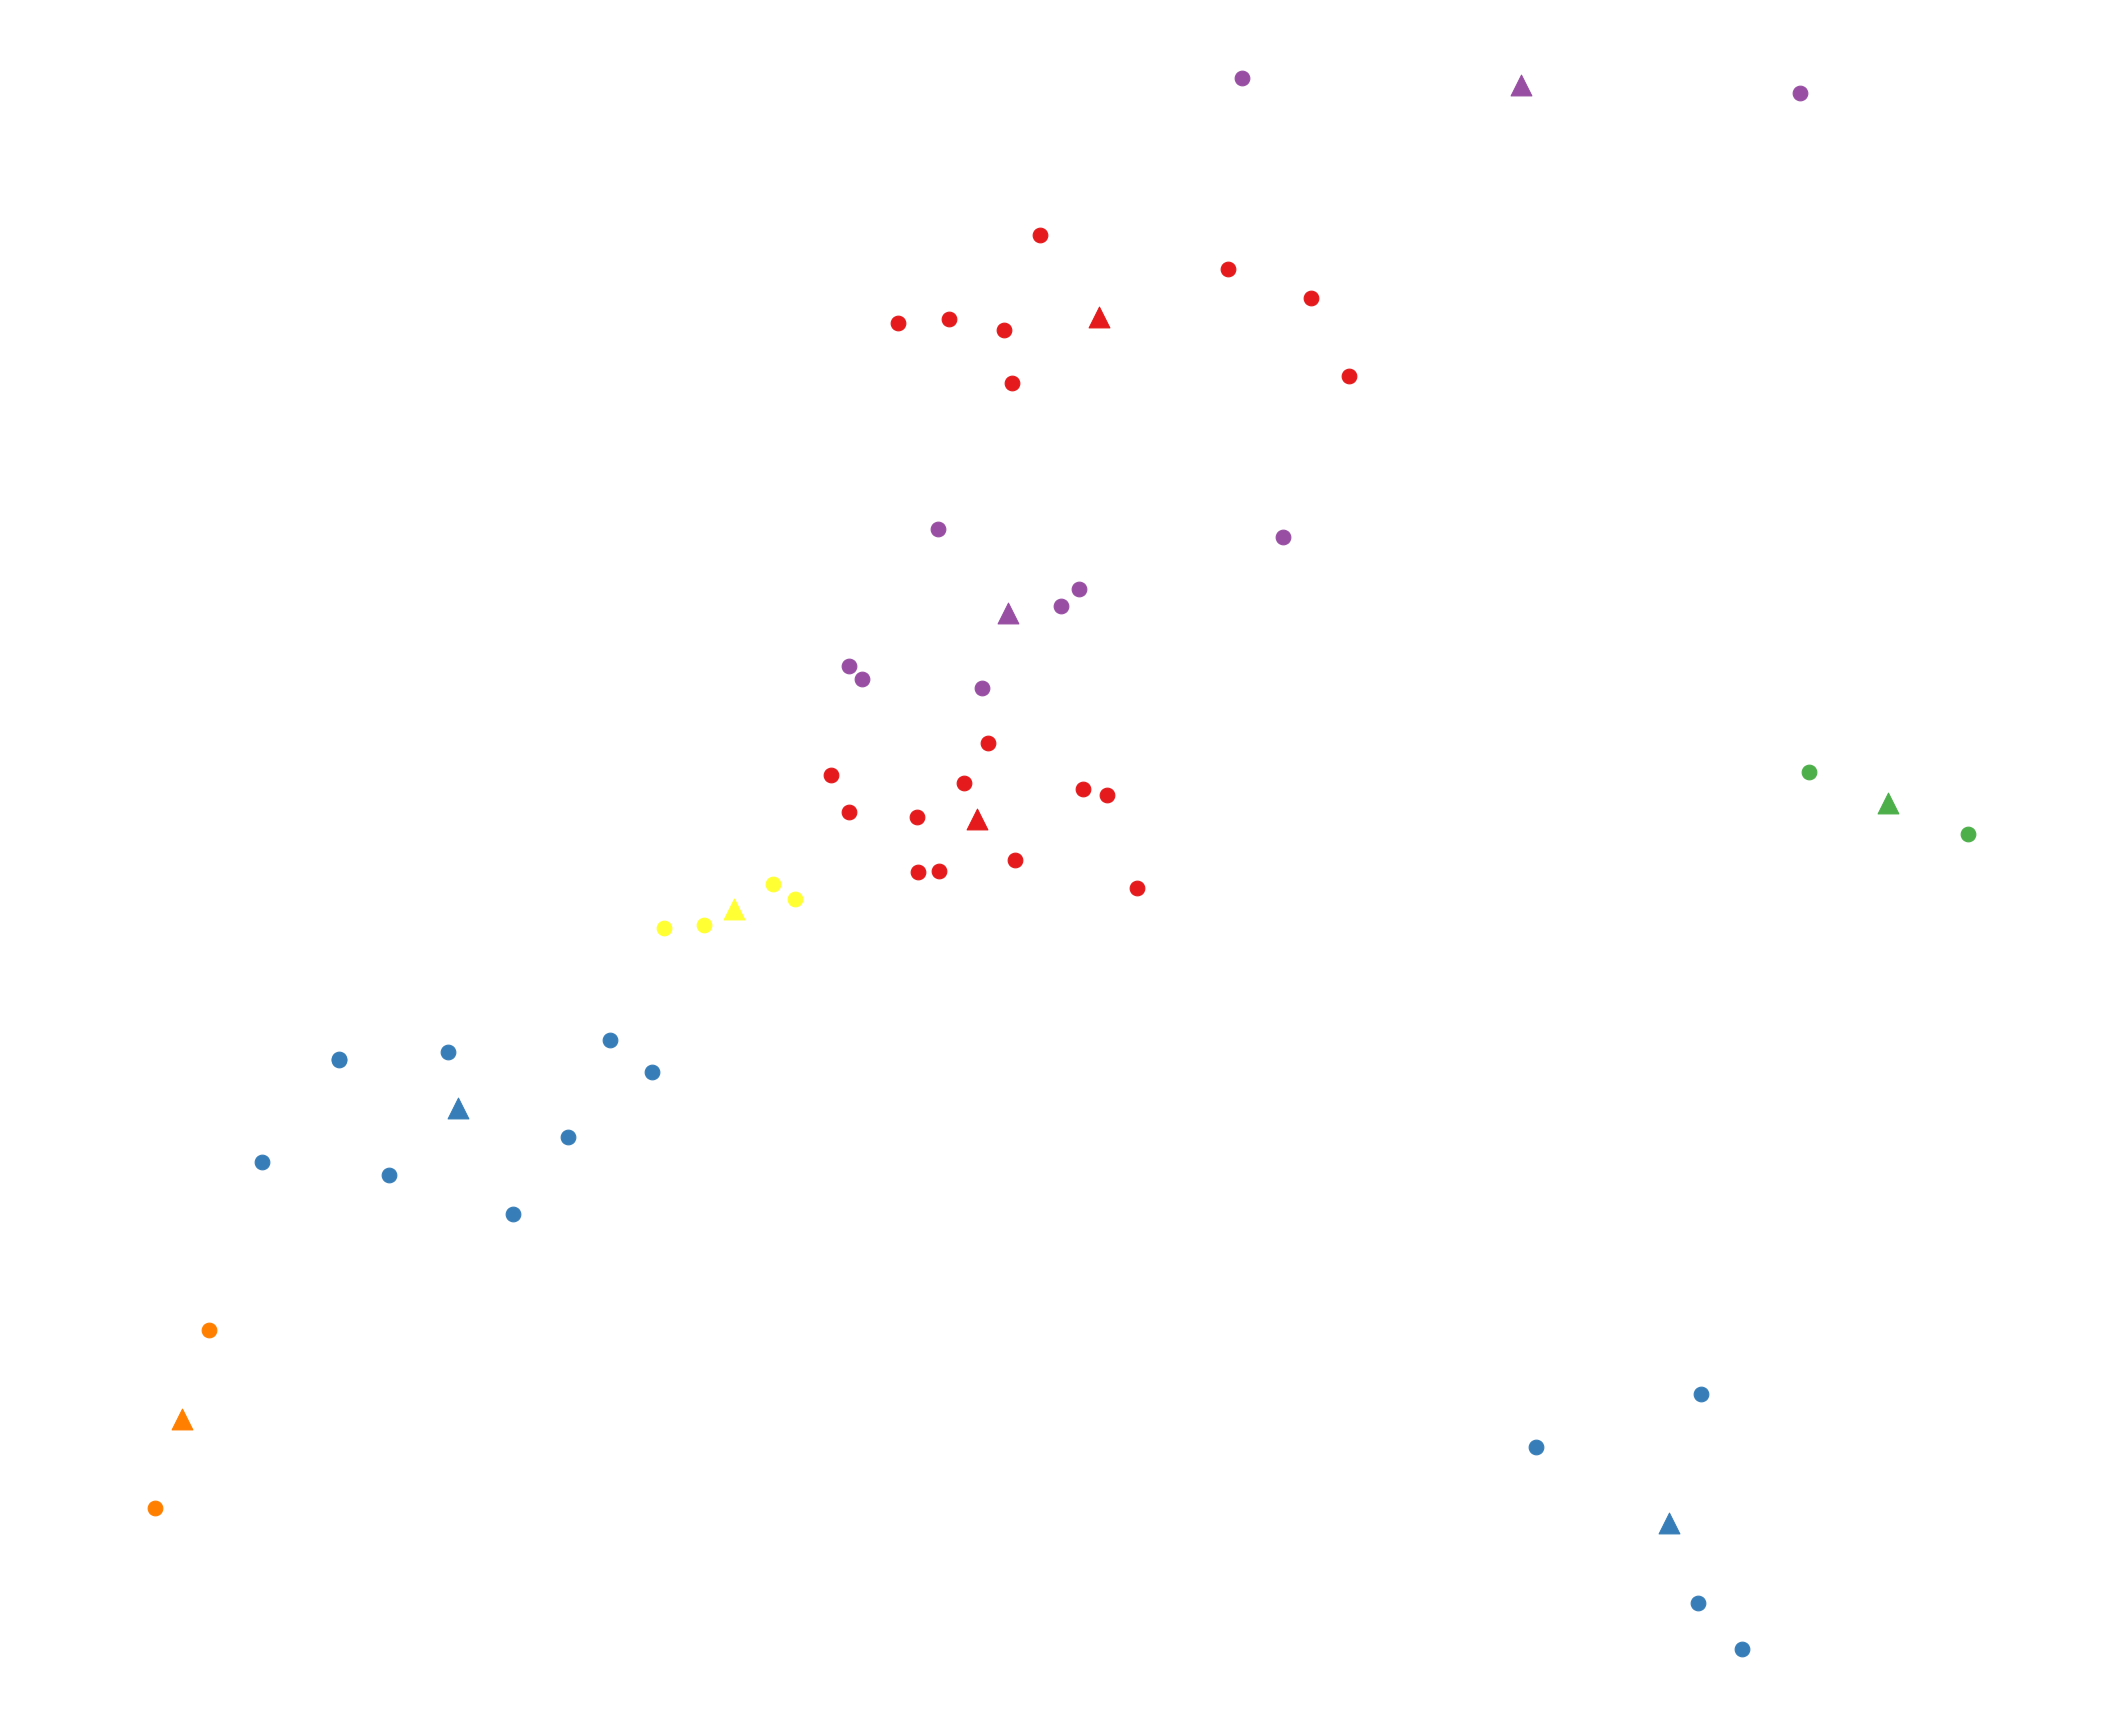

In [26]:
plot_for_clustering(9,kmean,df,"",X)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]
[1.  1.  0.2 1. ]


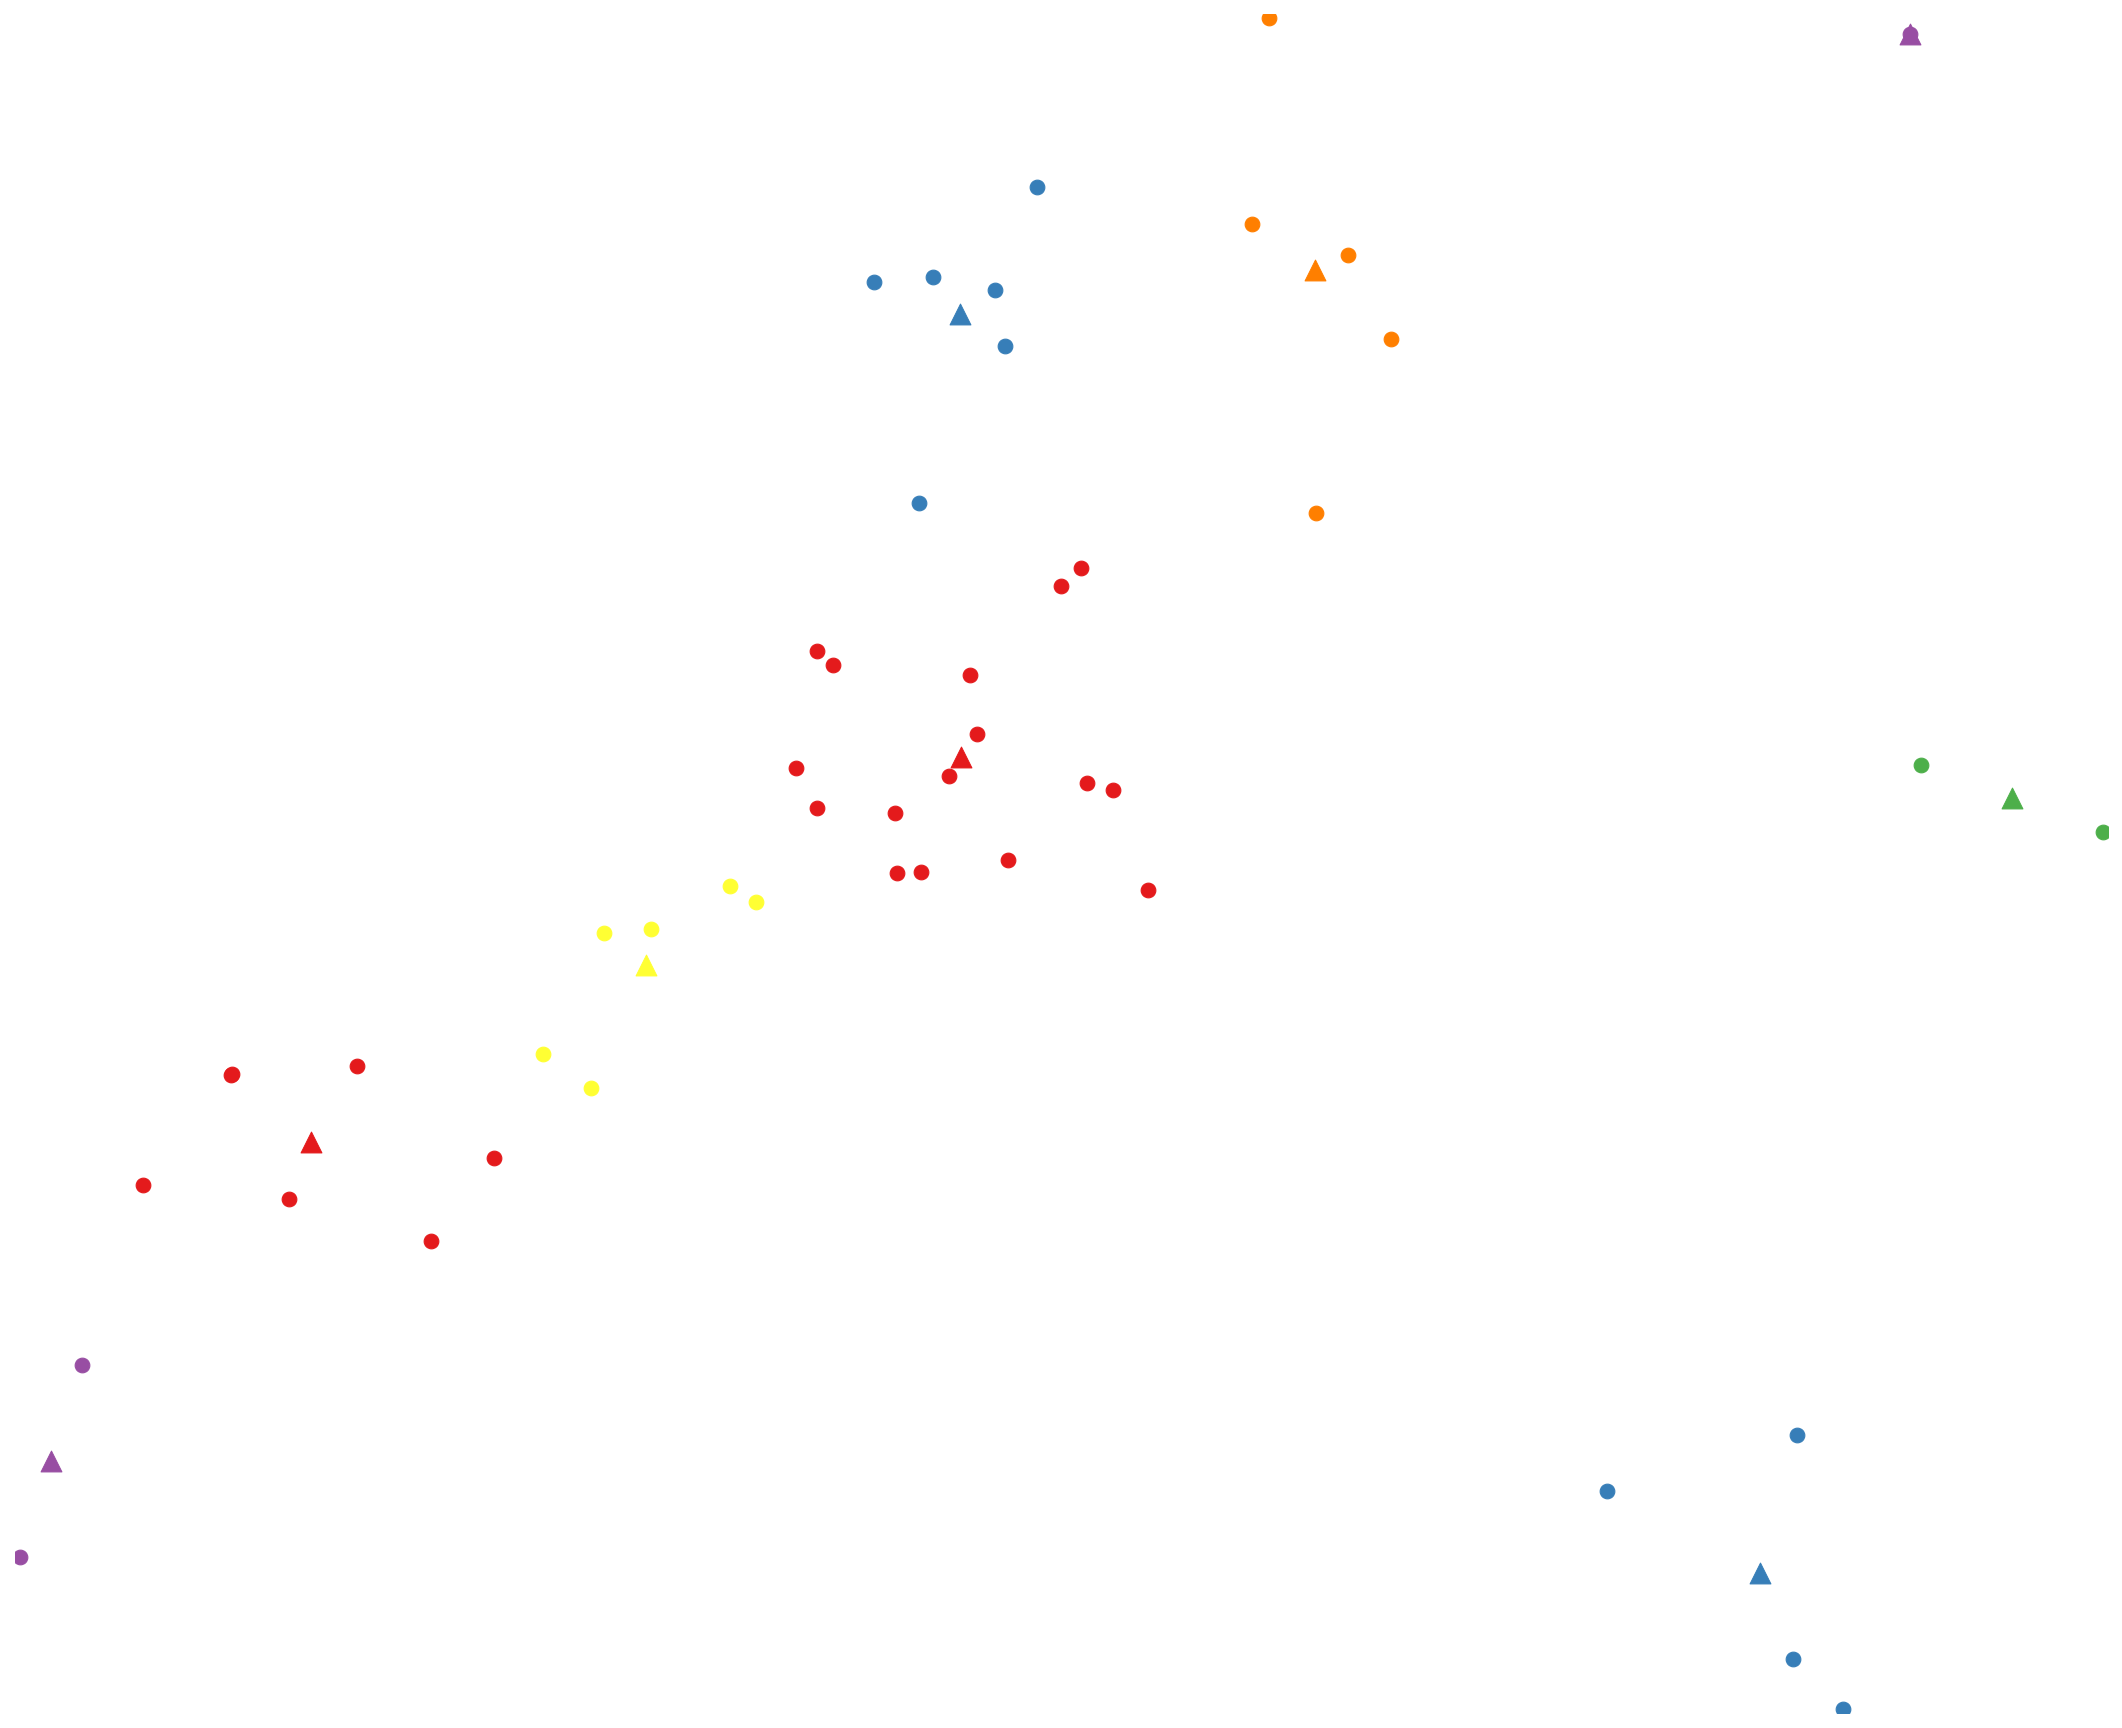

In [27]:
plot_for_clustering(9,kmean_std,df,"_std",X_std)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]
[1.  1.  0.2 1. ]


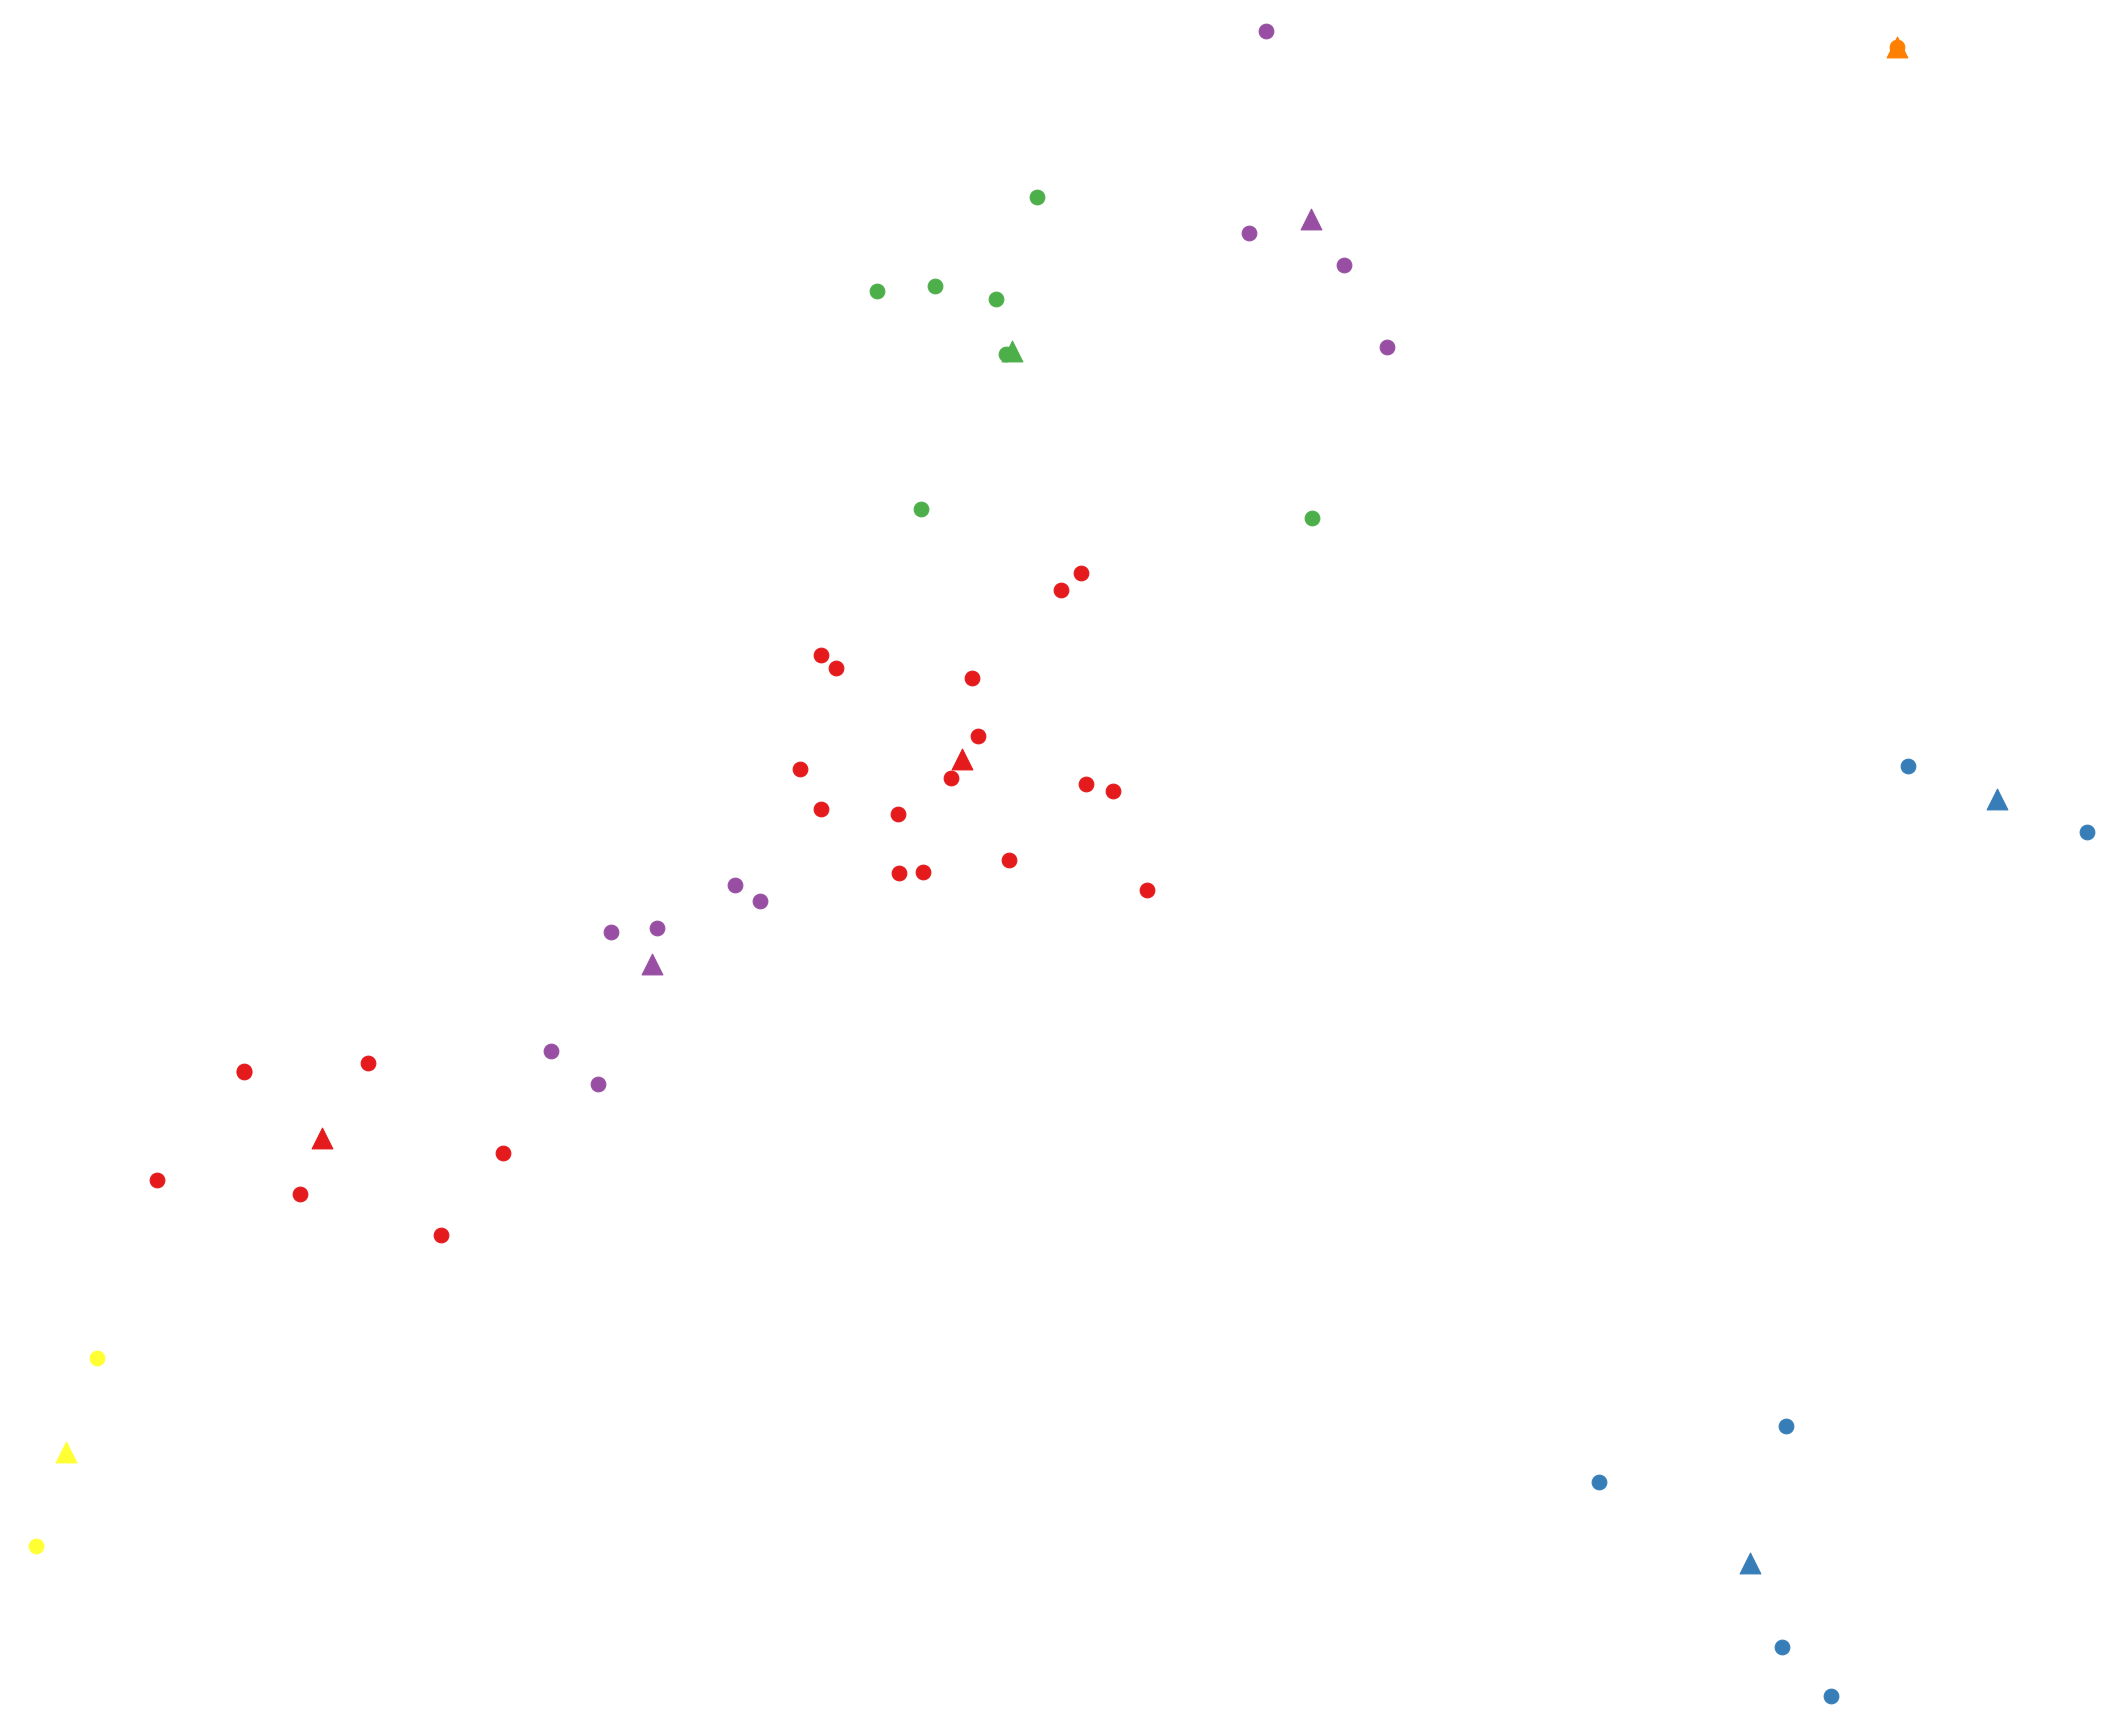

In [28]:
plot_for_clustering(9,kmean_norm,df,"_norm",X_norm)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]


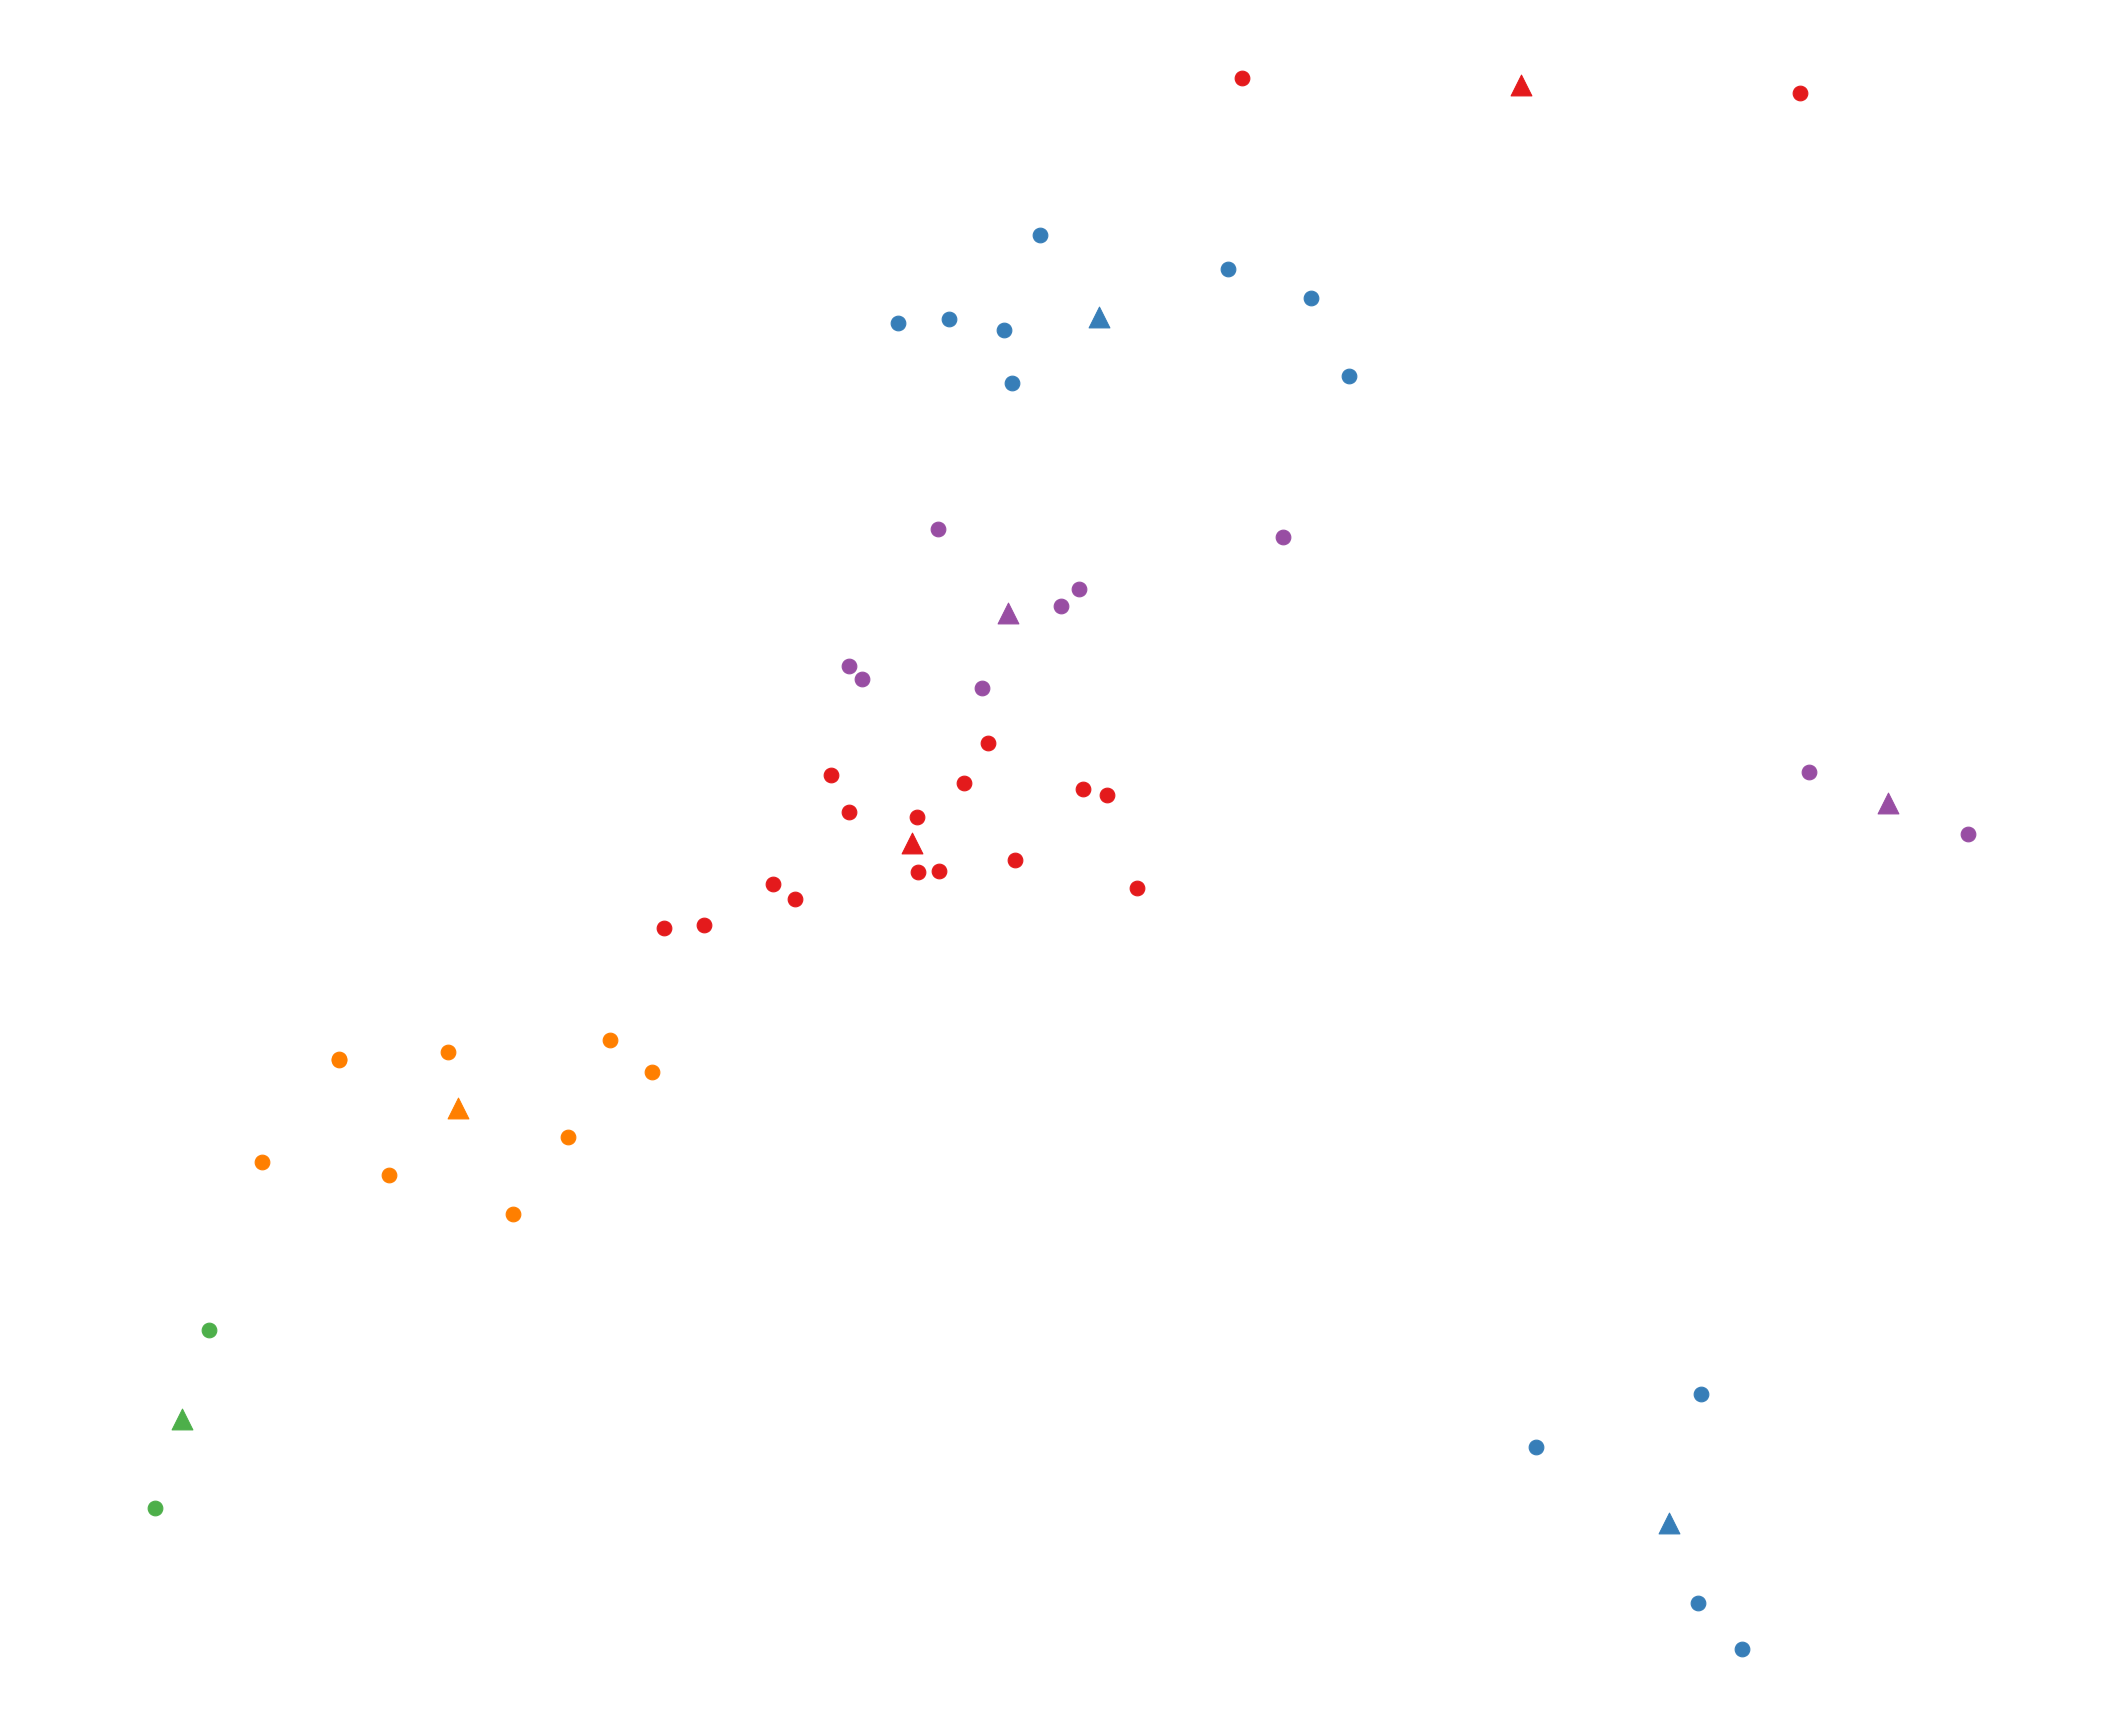

In [29]:
plot_for_clustering(8,kmean,df,"",X)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]


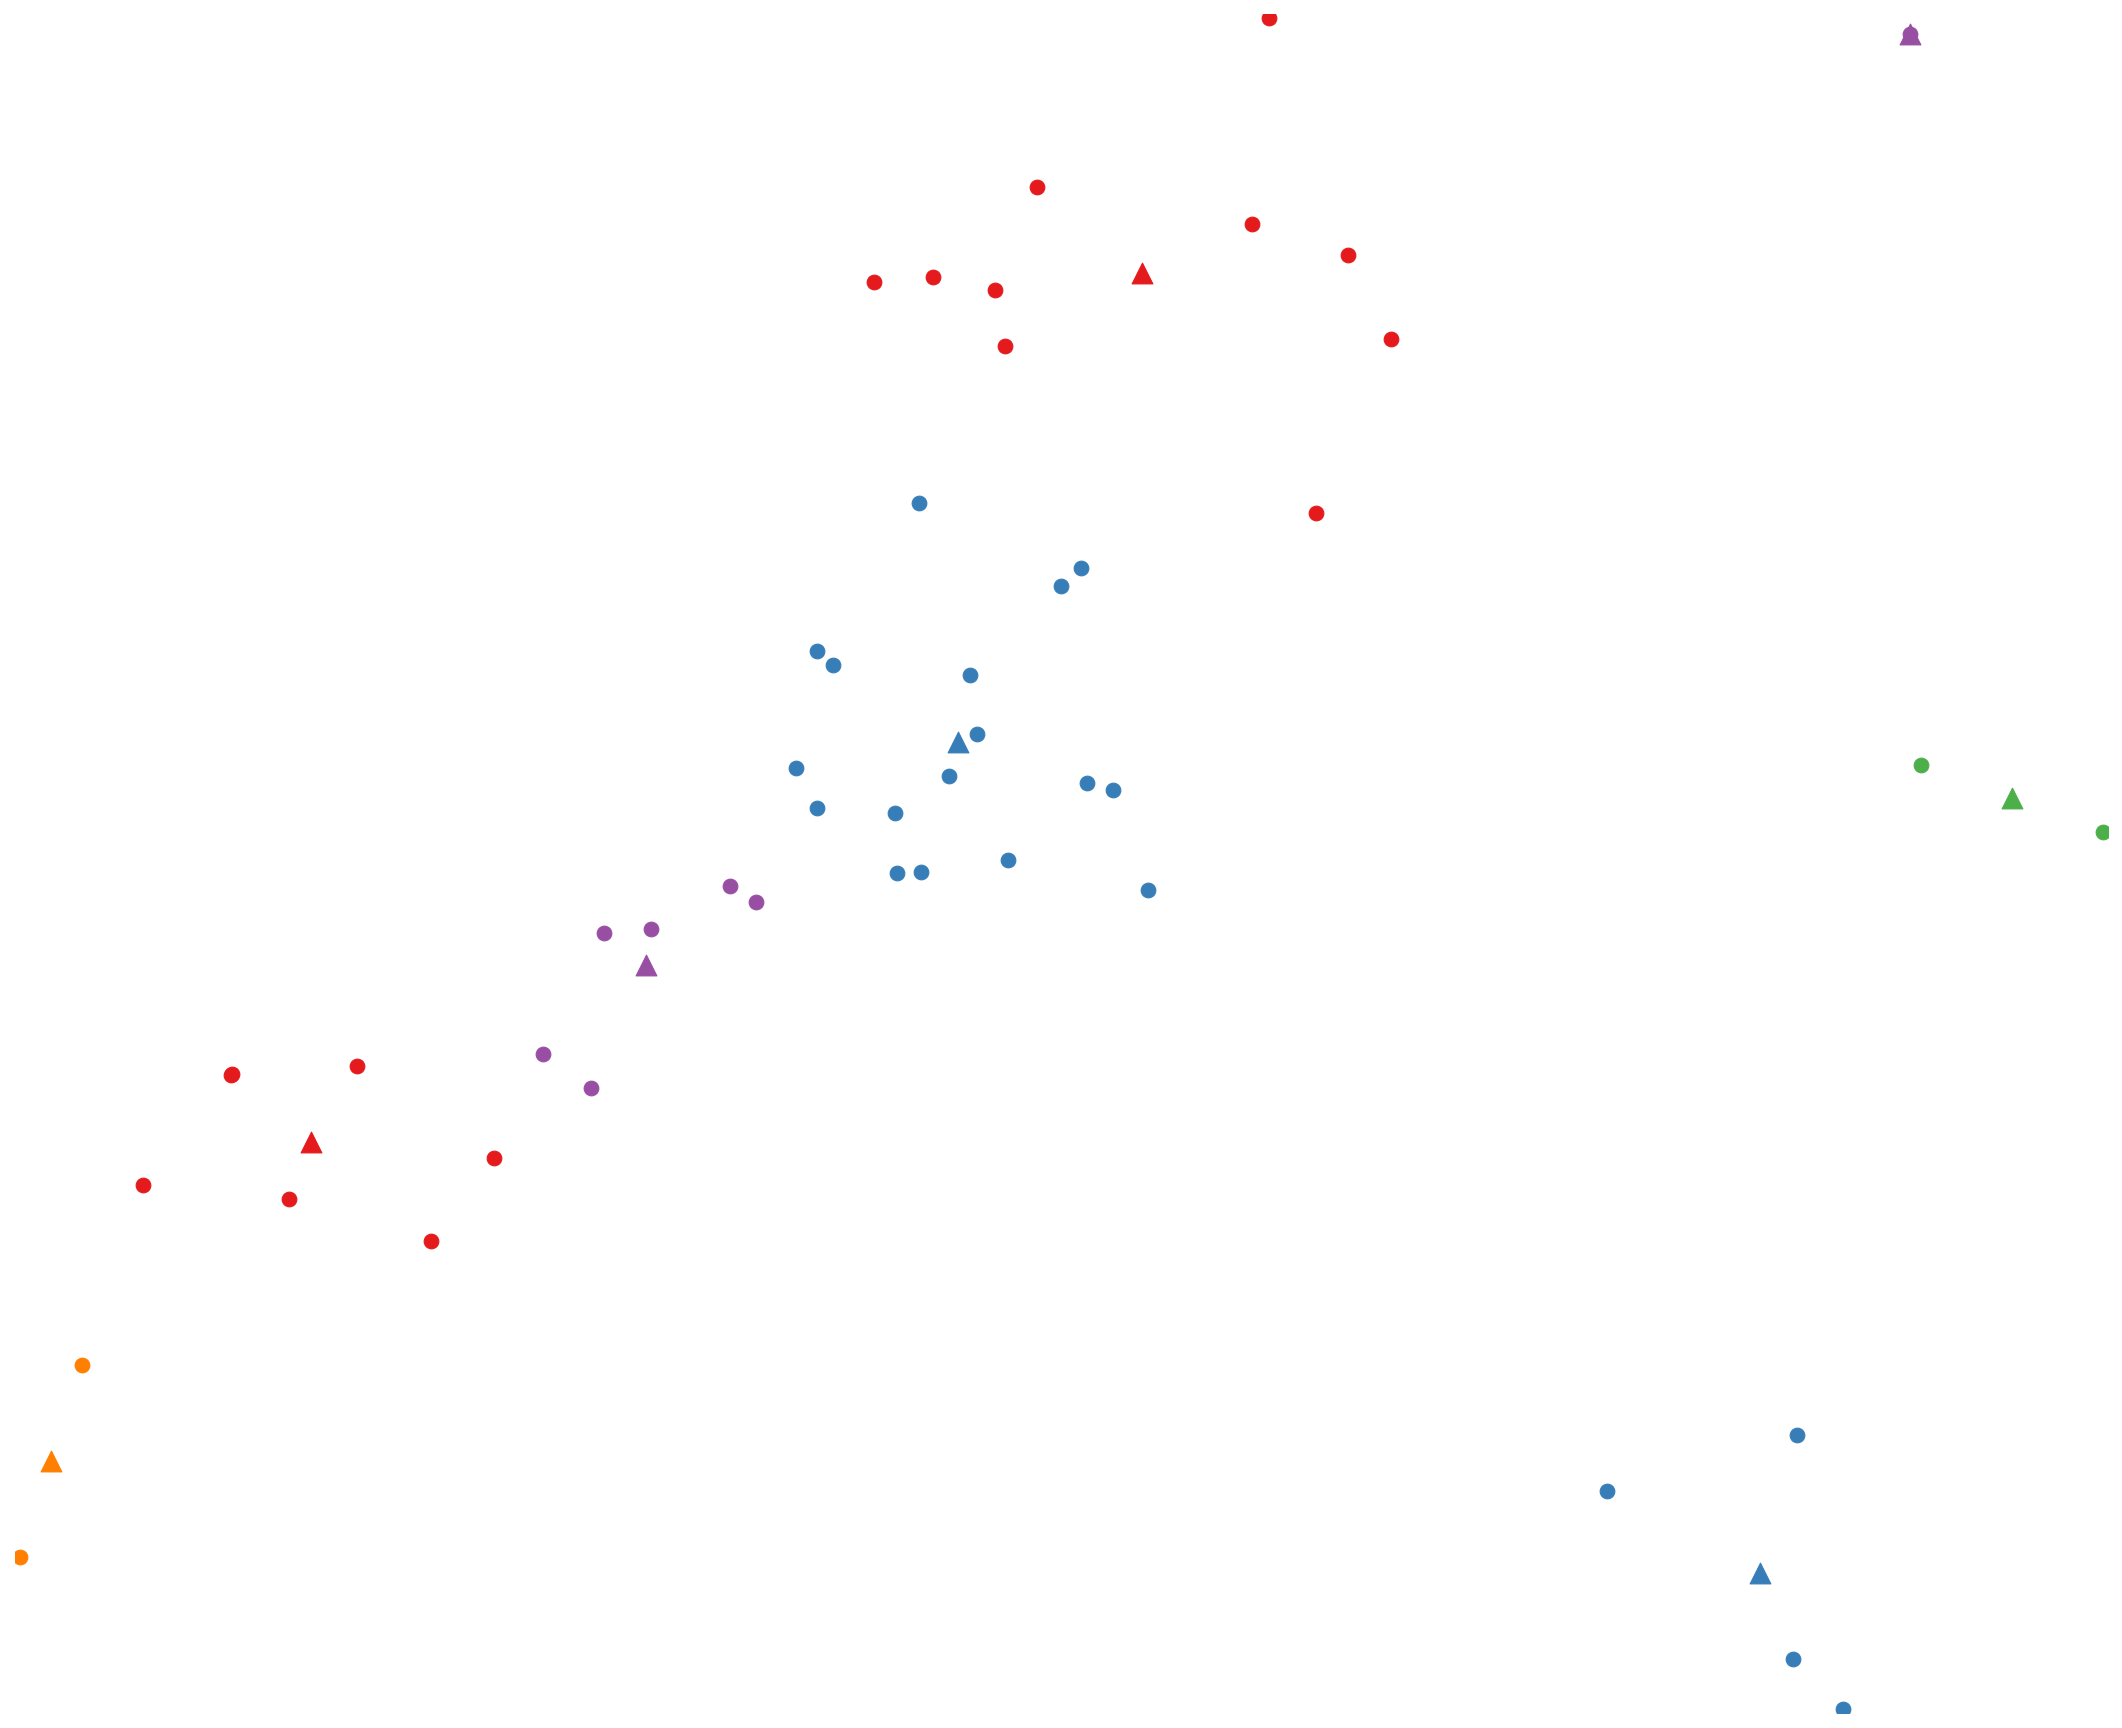

In [30]:
plot_for_clustering(8,kmean_std,df,"_std",X_std)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]
[1.         0.49803922 0.         1.        ]


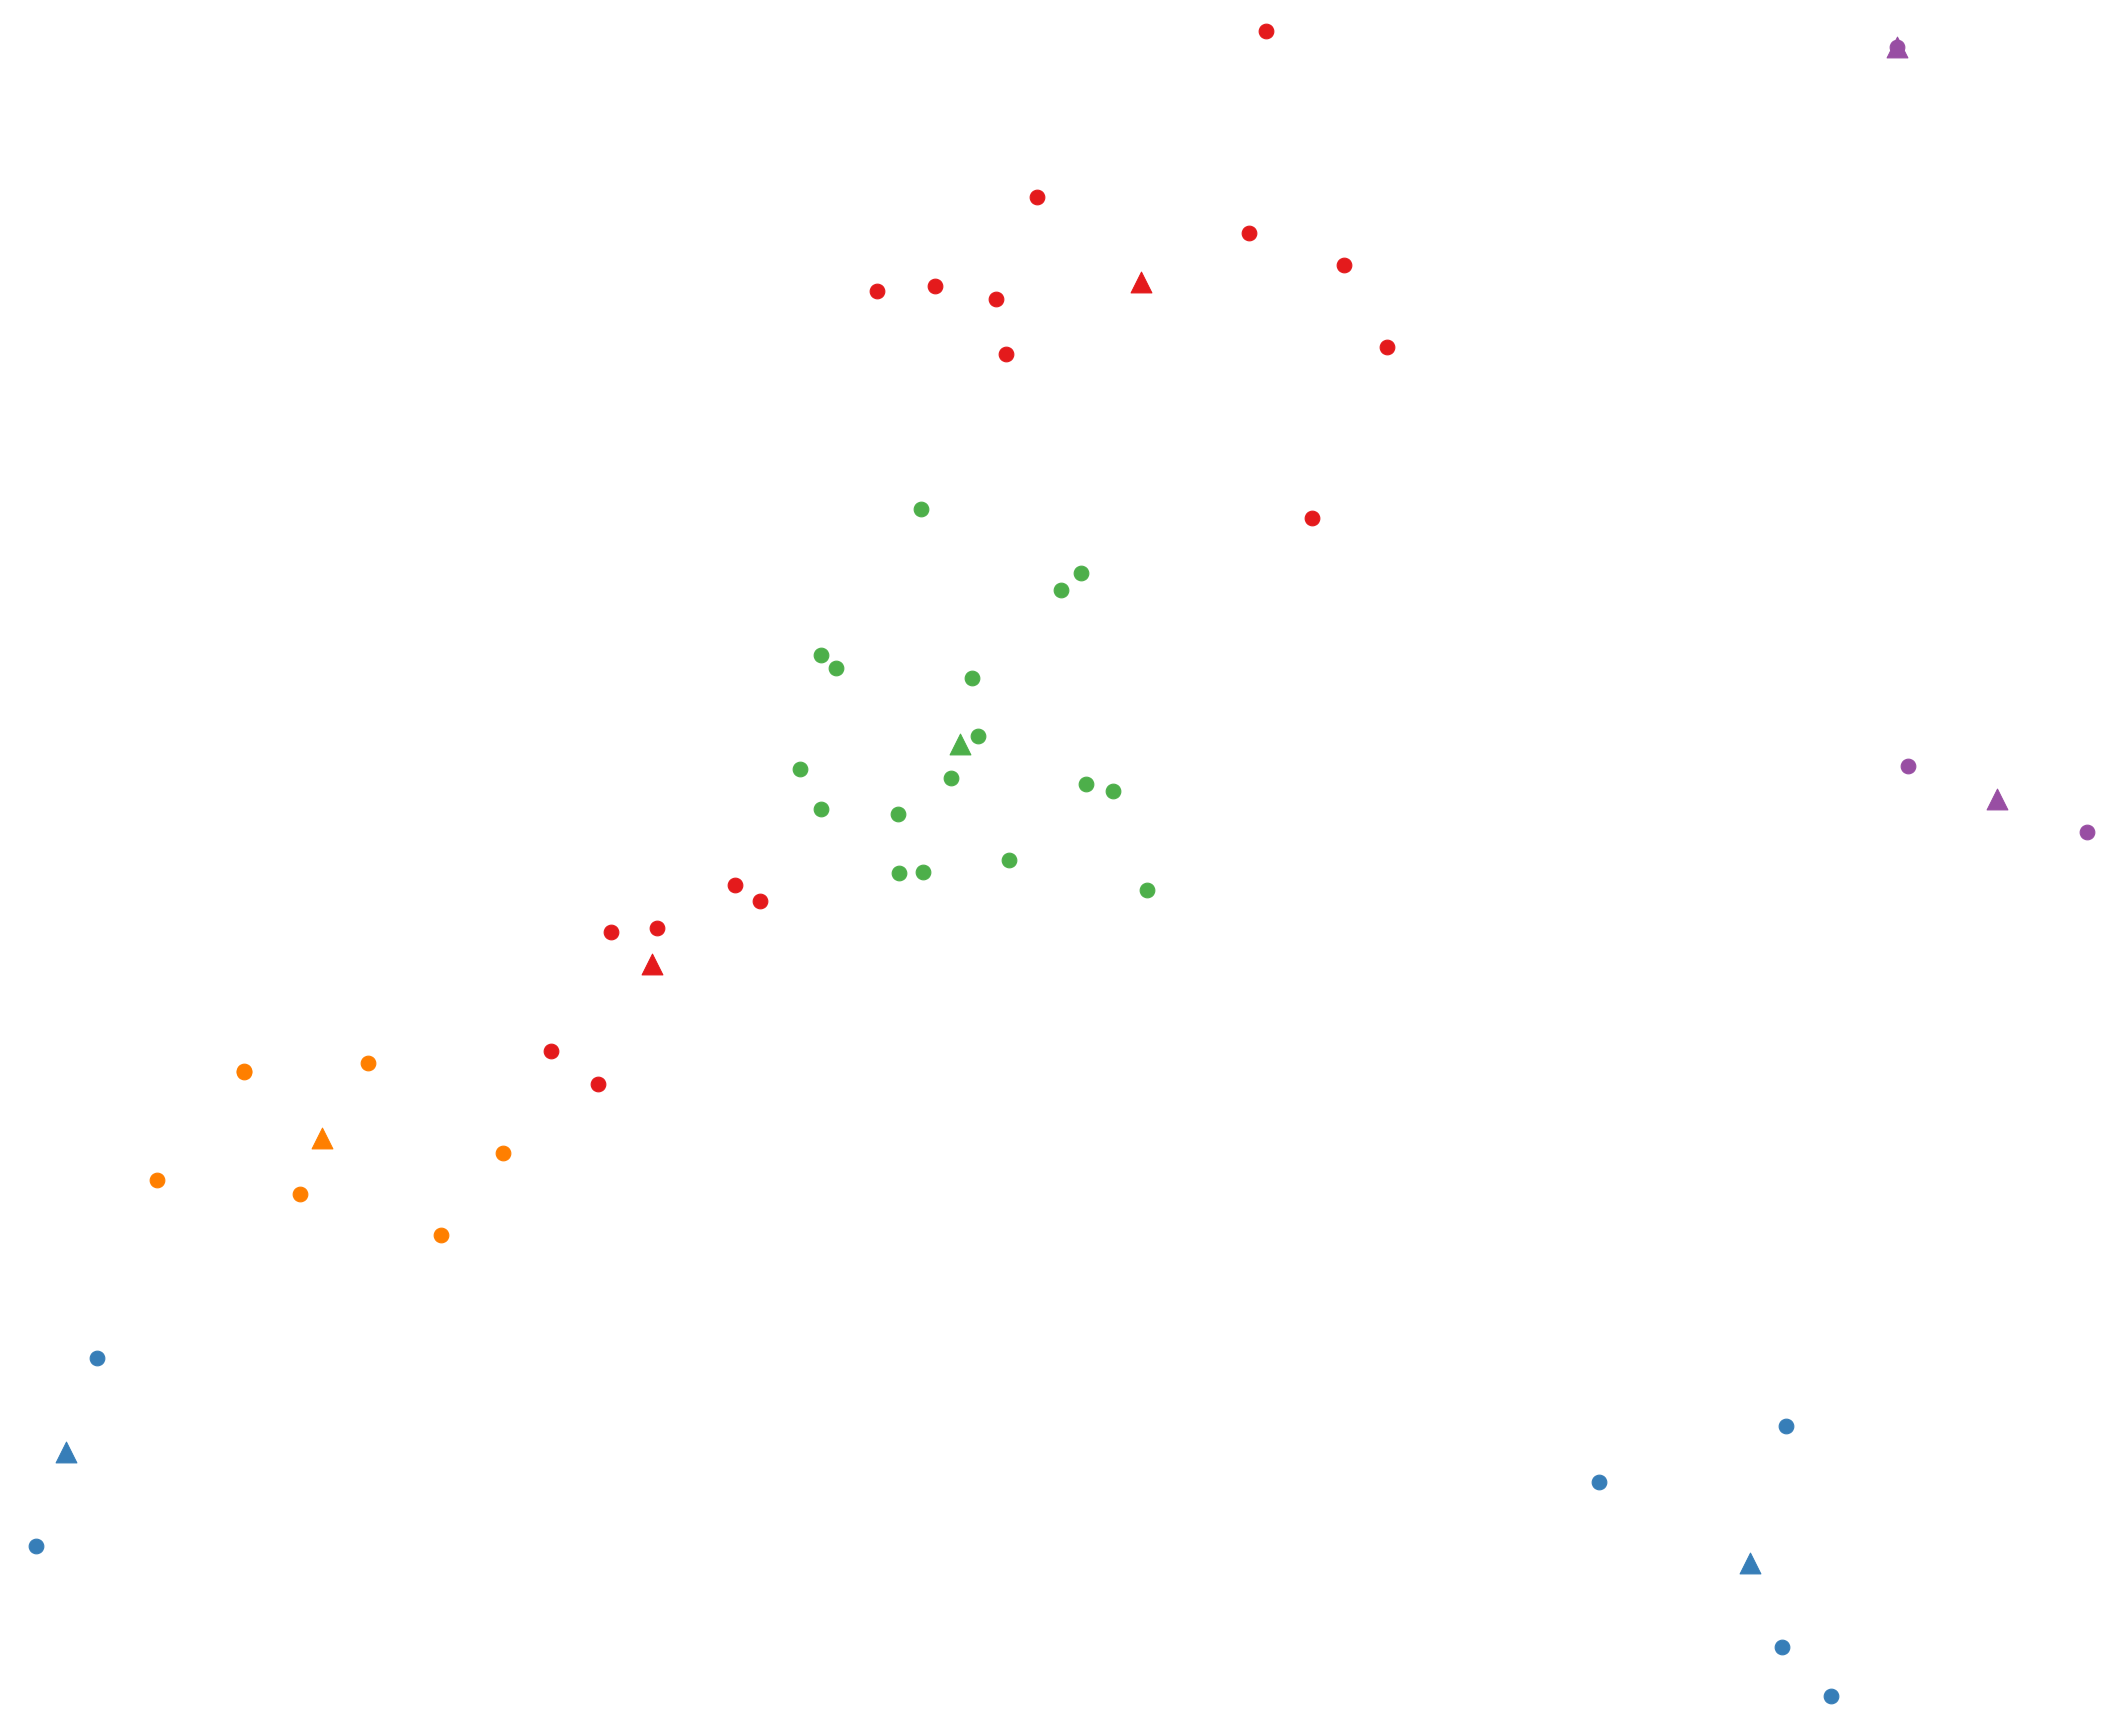

In [31]:
plot_for_clustering(8,kmean_norm,df,"_norm",X_norm)

In [34]:
def distance_cartesian(pos1,pos2):
    return sqrt(pos1*pos1+pos2*pos2)
    
def crear_clusters(k,distancia,df,norm):

    ### distancia maxima entre centroides
    maxima_distancia = distancia # km  
    enlaces_cluster_hospital = []
    distancias_cluster_hospital = []
    cl = len(list(df['cluster%s_%d' %(norm,k)].unique()))
    est = []
    if norm=="":
        est = kmean[k-1]
    elif norm=="_std":
        est = kmean_std[k-1]
    elif norm=="_norm":        
        est = kmean_norm[k-1]
        
    centers =   est.cluster_centers_

    for nc in range(cl):   
        g = df.loc[df['cluster%s_%d' %(norm,k)] == nc]   
        enlaces = []
        distancias = []
        for latitud,longitud in zip(g["latitud%s" %norm],g["longitud%s" %norm]):
            enlaces.append([[round(centers[nc][0],6),round(centers[nc][1],6)],[round(latitud,6),round(longitud,6)]])
            distancia = 0
            if norm == "":
                distancia = round(distanceInKmBetweenEarthCoordinates(centers[nc],[latitud,longitud]),6)
            else:
                distancia = round(distance_cartesian(centers[nc],[latitud,longitud]),6)
            distancias.append(distancia)
        enlaces_cluster_hospital.append(enlaces)
        distancias_cluster_hospital.append(distancias)
    enlaces_clusters = []
    distancias_clusters = []
    for u in range(0,cl):
        for r in range(u+1,cl):
            distancia = 0
            if norm == "":
                distancia = round(distanceInKmBetweenEarthCoordinates(centers[u],centers[r]),6)
            else:
                distancia = round(distance_cartesian(centers[u],centers[r]),6)            
            
            if  distancia< maxima_distancia:
                enlaces_clusters.append([[round(centers[u][0],6),round(centers[u][1],6)],[round(centers[r][0],6),round(centers[r][1],6)]])
                distancias_clusters.append(distancia)
    ## enlaces de centroides a centroides
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.axis('off')
    plt.grid(False)
    colors = iter(cm.Set1(np.linspace(0, 1, 15)))
    for nc in range(cl):   
        g = df.loc[df['cluster%s_%d' %(norm,k)] == nc]   
        color = next(colors)     
        plt.scatter(g['longitud%s' %norm],g['latitud%s' %norm] , color=color,marker = 'o', zorder=2, alpha=1.0, s=50)
        plt.scatter(centers[nc][1],centers[nc][0], marker = '^', color=color, s=100)
        for enlace in enlaces_cluster_hospital[nc]:
            plt.plot([enlace[0][1],enlace[1][1]],[enlace[0][0],enlace[1][0]],color=color)
    
    for enlace in enlaces_clusters:
           plt.plot([enlace[0][1],enlace[1][1]],[enlace[0][0],enlace[1][0]],color="black")


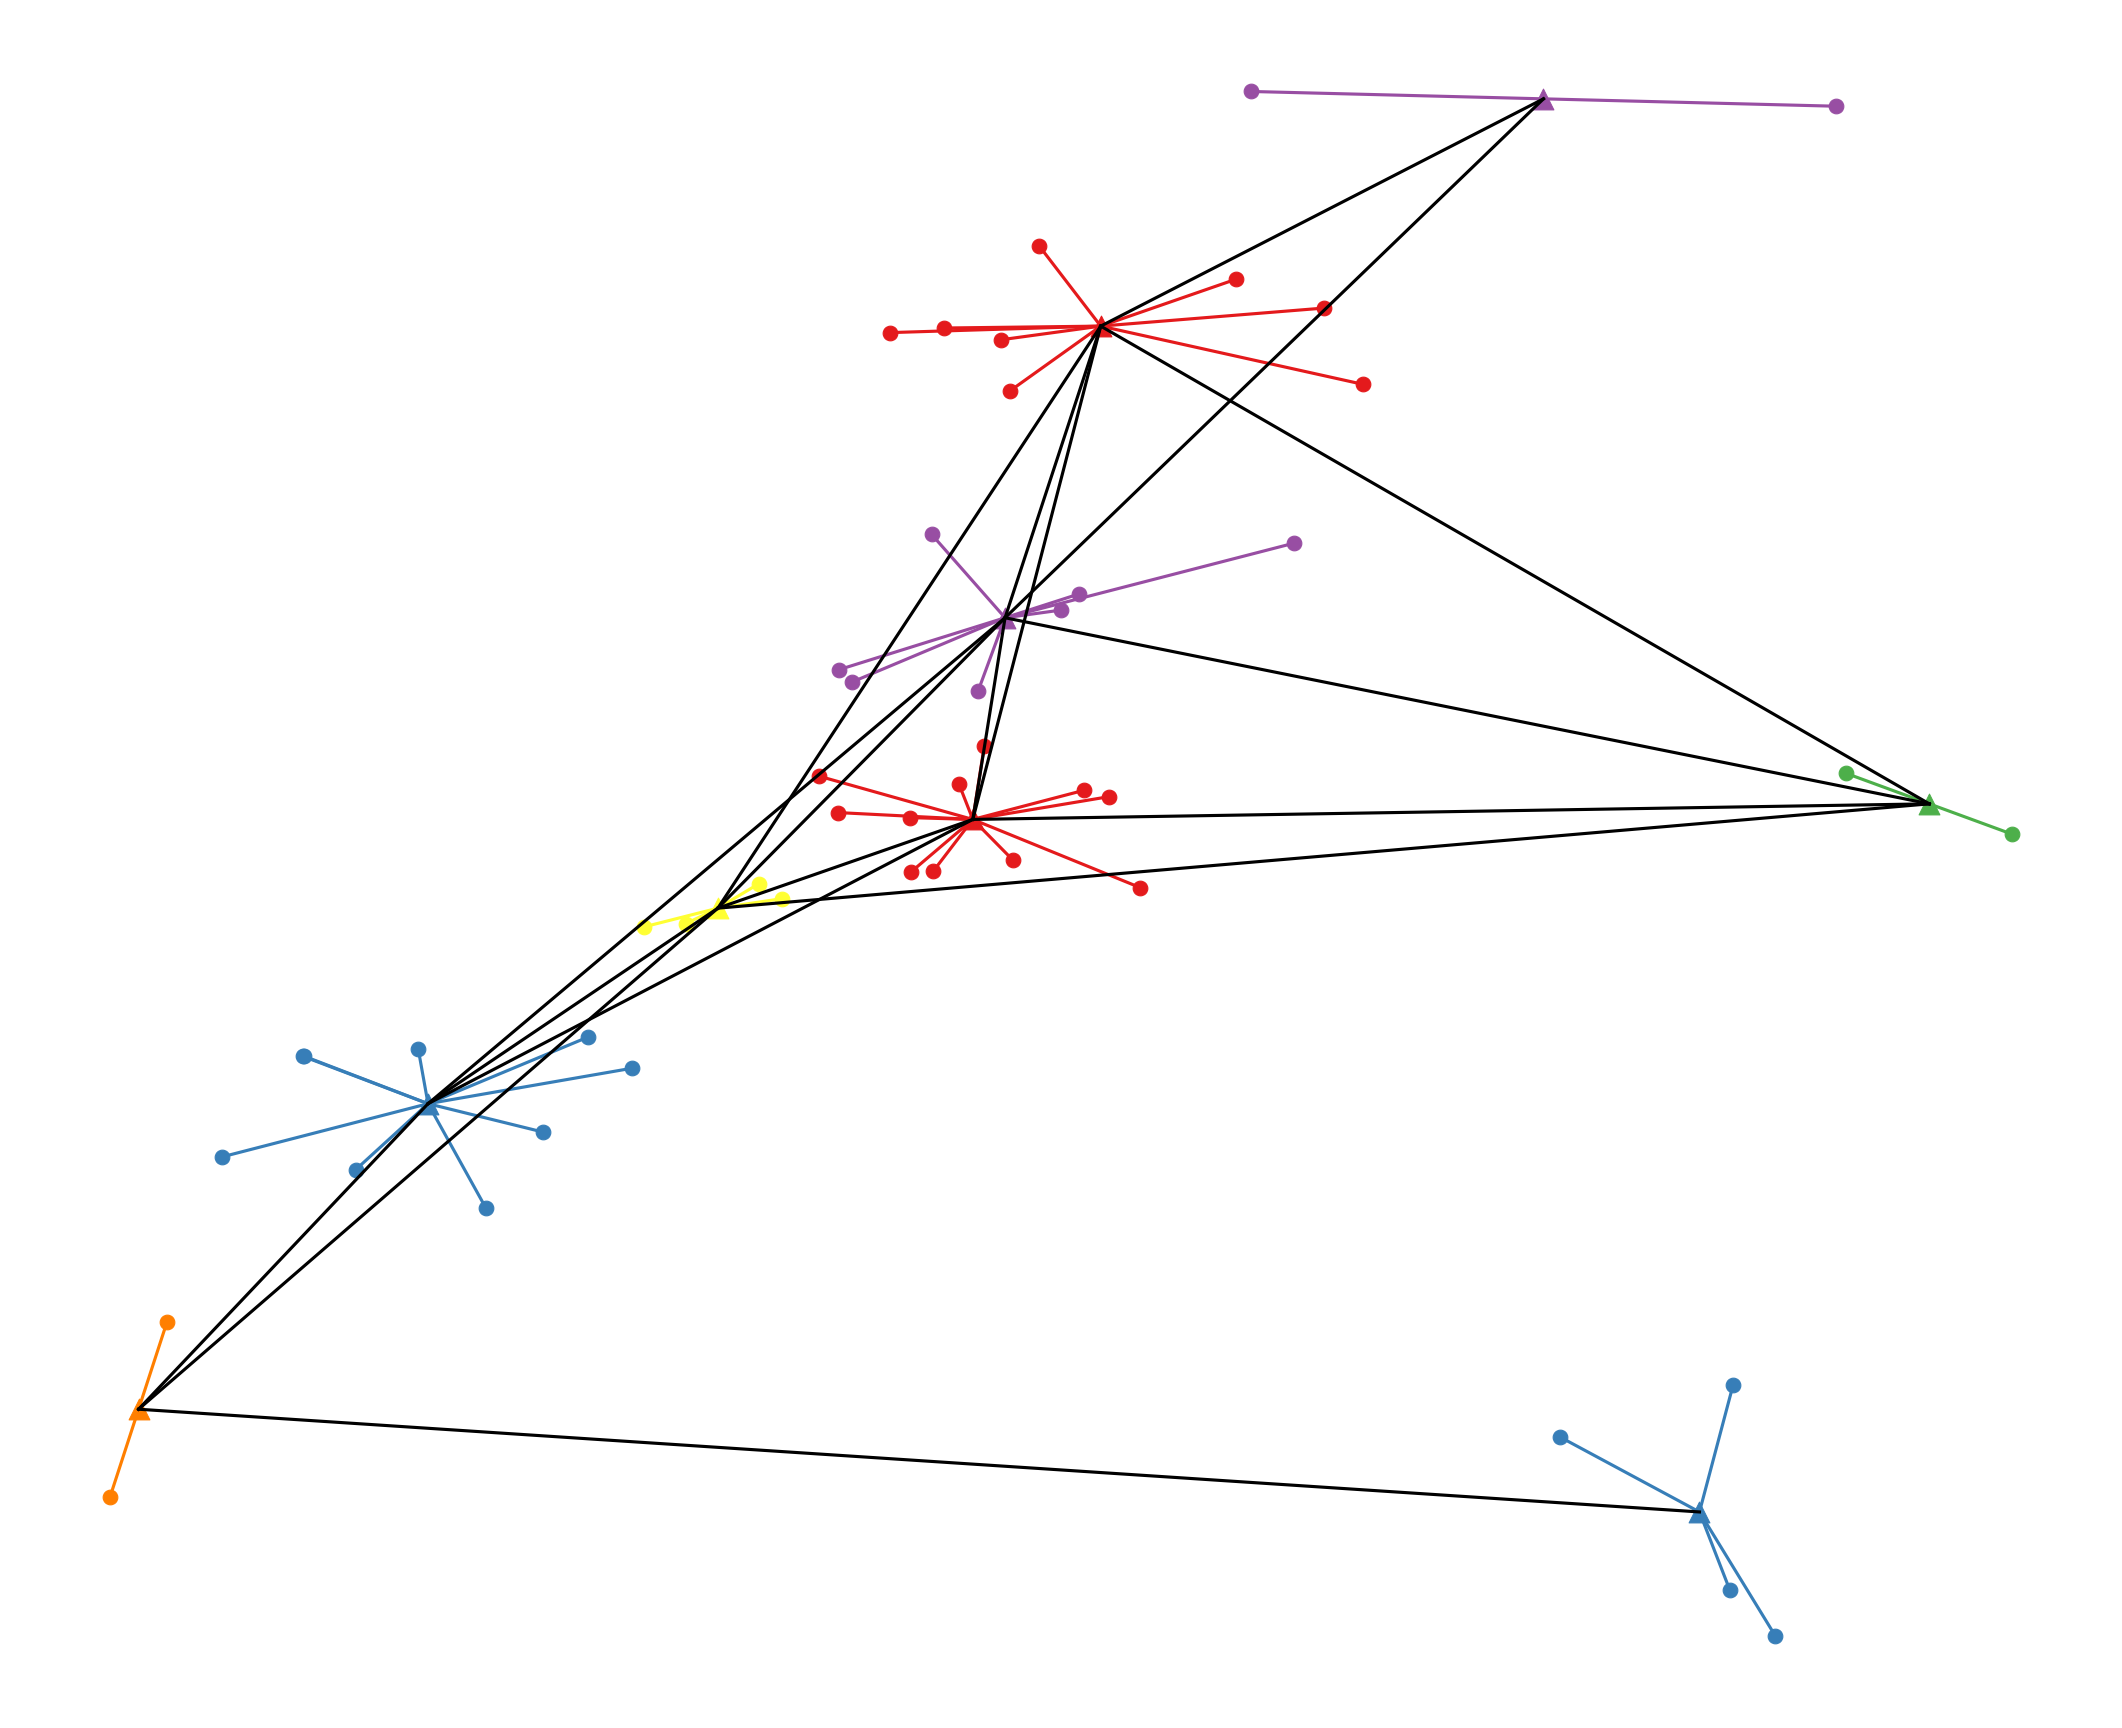

In [35]:
crear_clusters(9,12,df,"")

In [36]:
crear_clusters(9,300,df,"_std")

NameError: name 'sqrt' is not defined

In [37]:
crear_clusters(9,53,df,"_norm")

NameError: name 'sqrt' is not defined

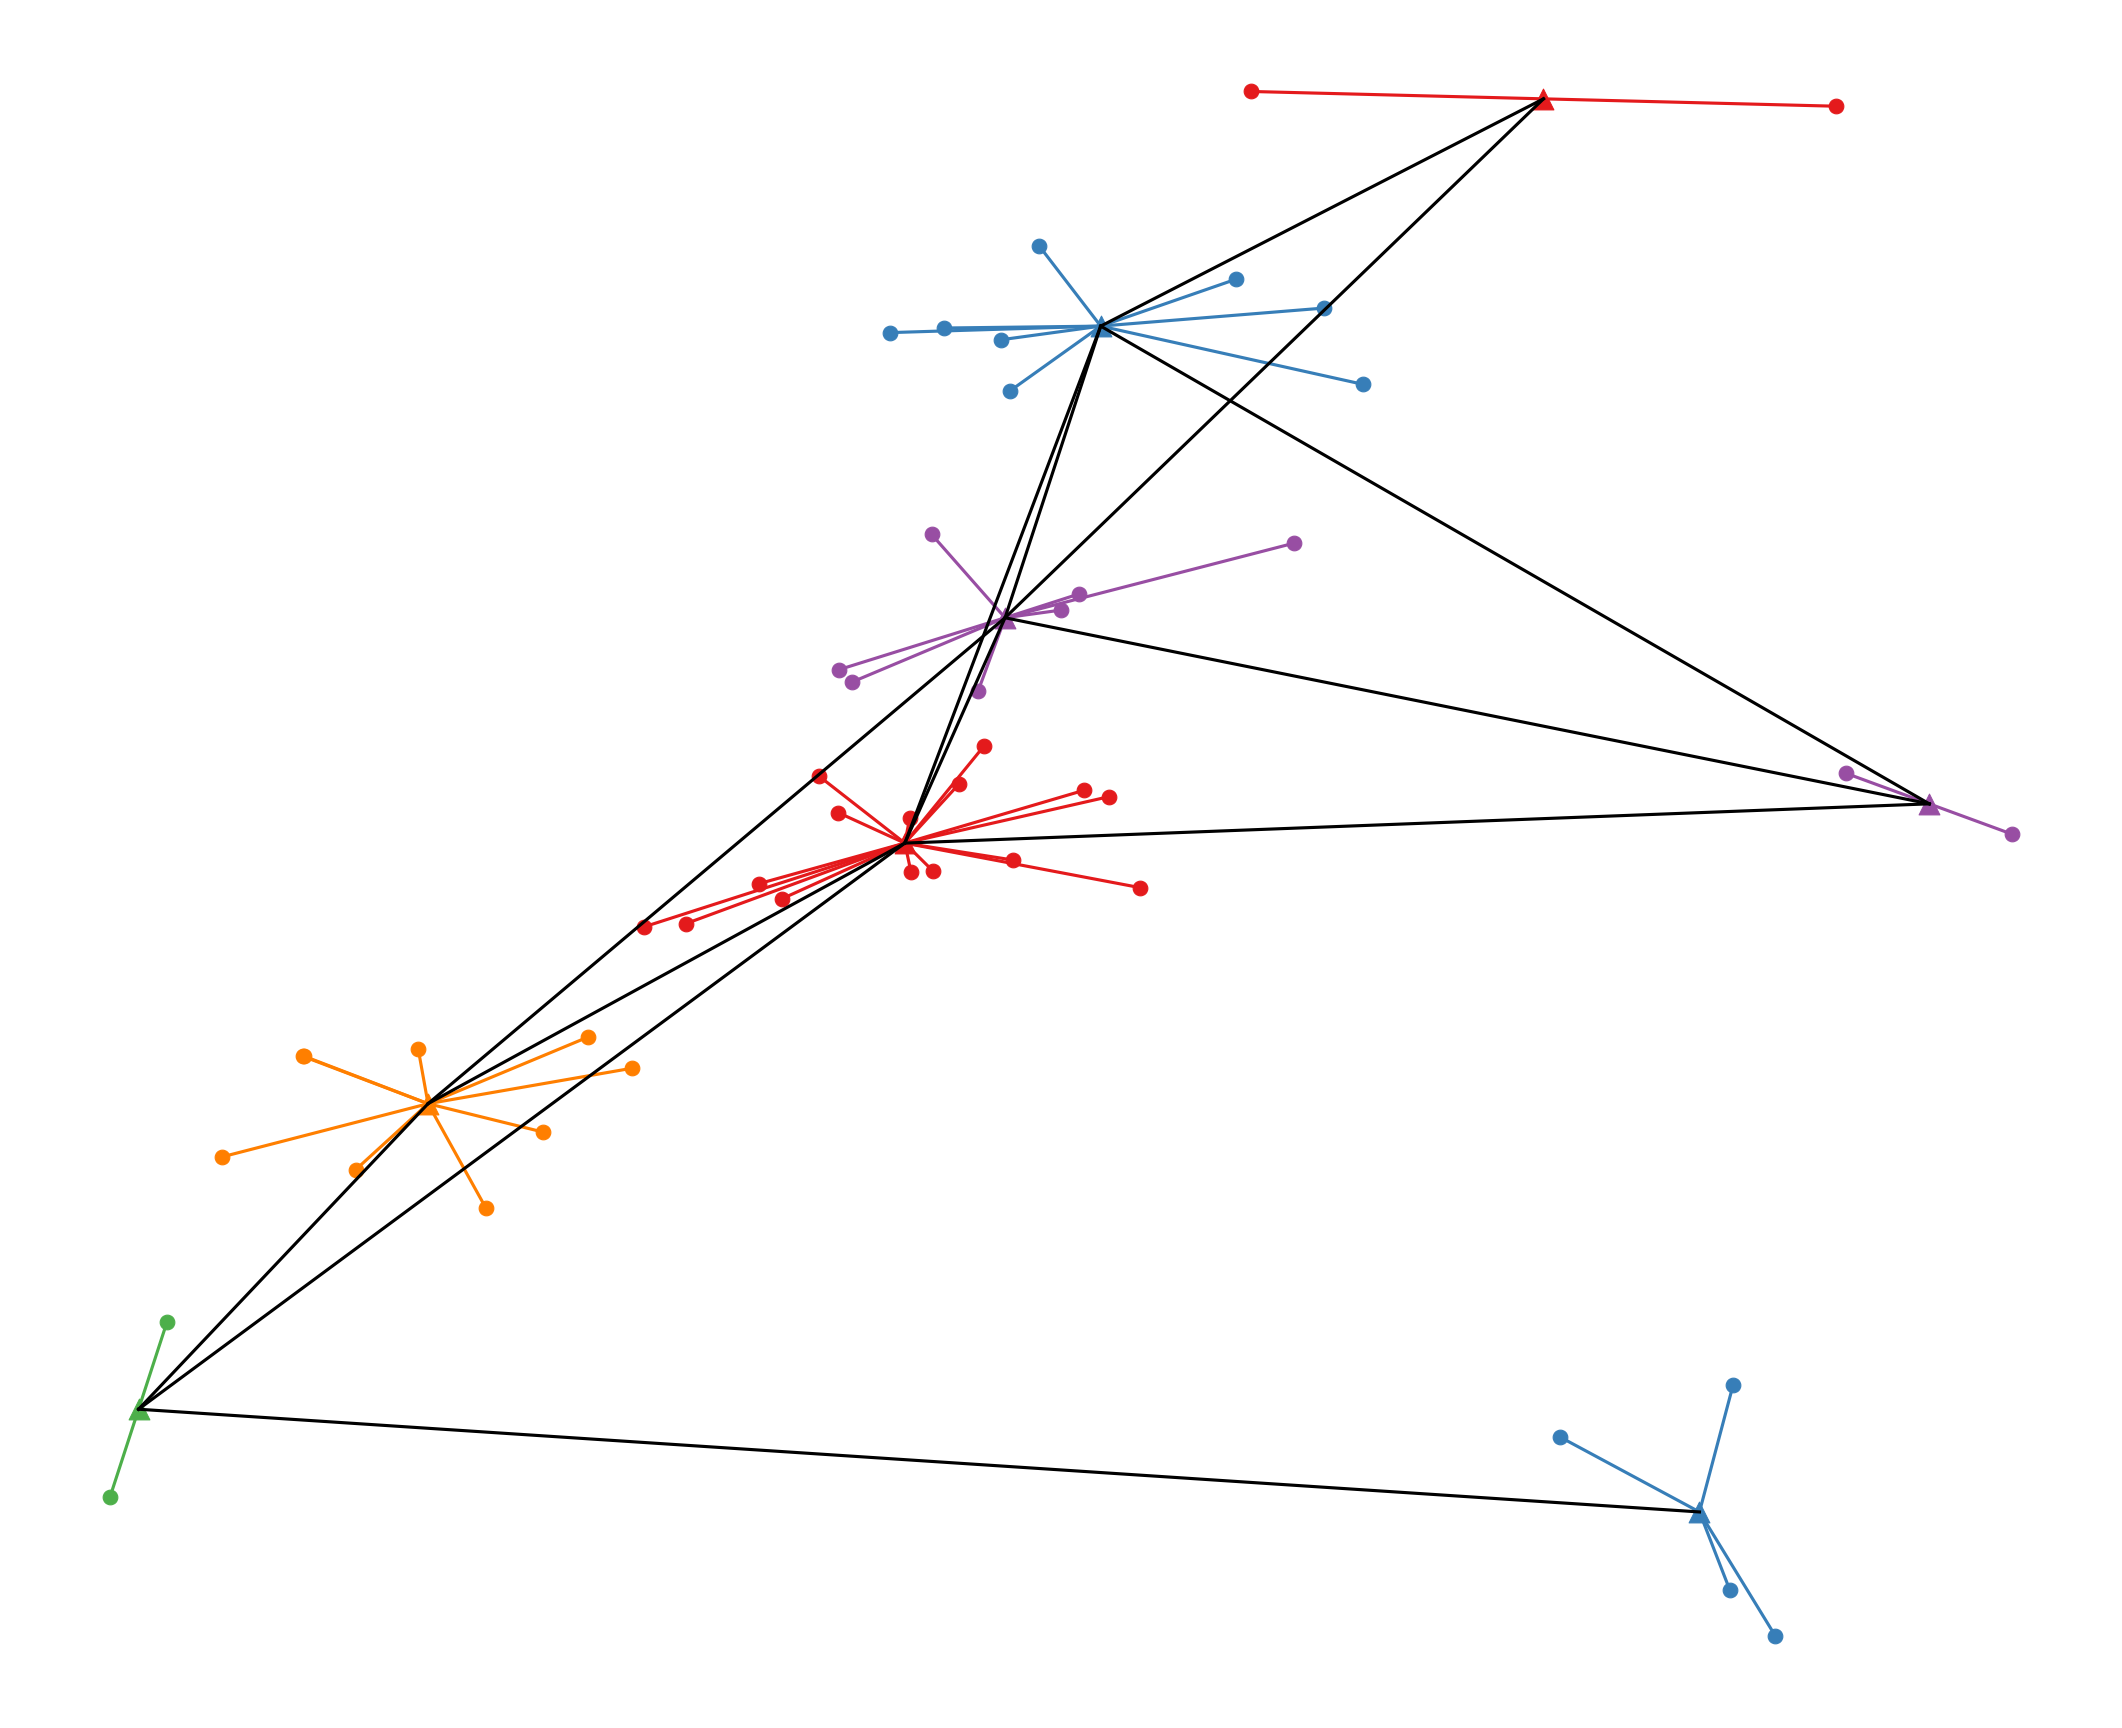

In [38]:
crear_clusters(8,12,df,"")

45.196781
93.157895
66.165278
29.673516
70.100046
53.910682
19.1749
71.351202
74.306048
20.317347
26.968384
90.164751
57.14436
52.4785
68.201869
82.376606
101.530883
88.957471
57.781778
97.979106
51.386182
52.455683
47.274414
69.911748
37.749461
117.126183
83.747367
35.296497


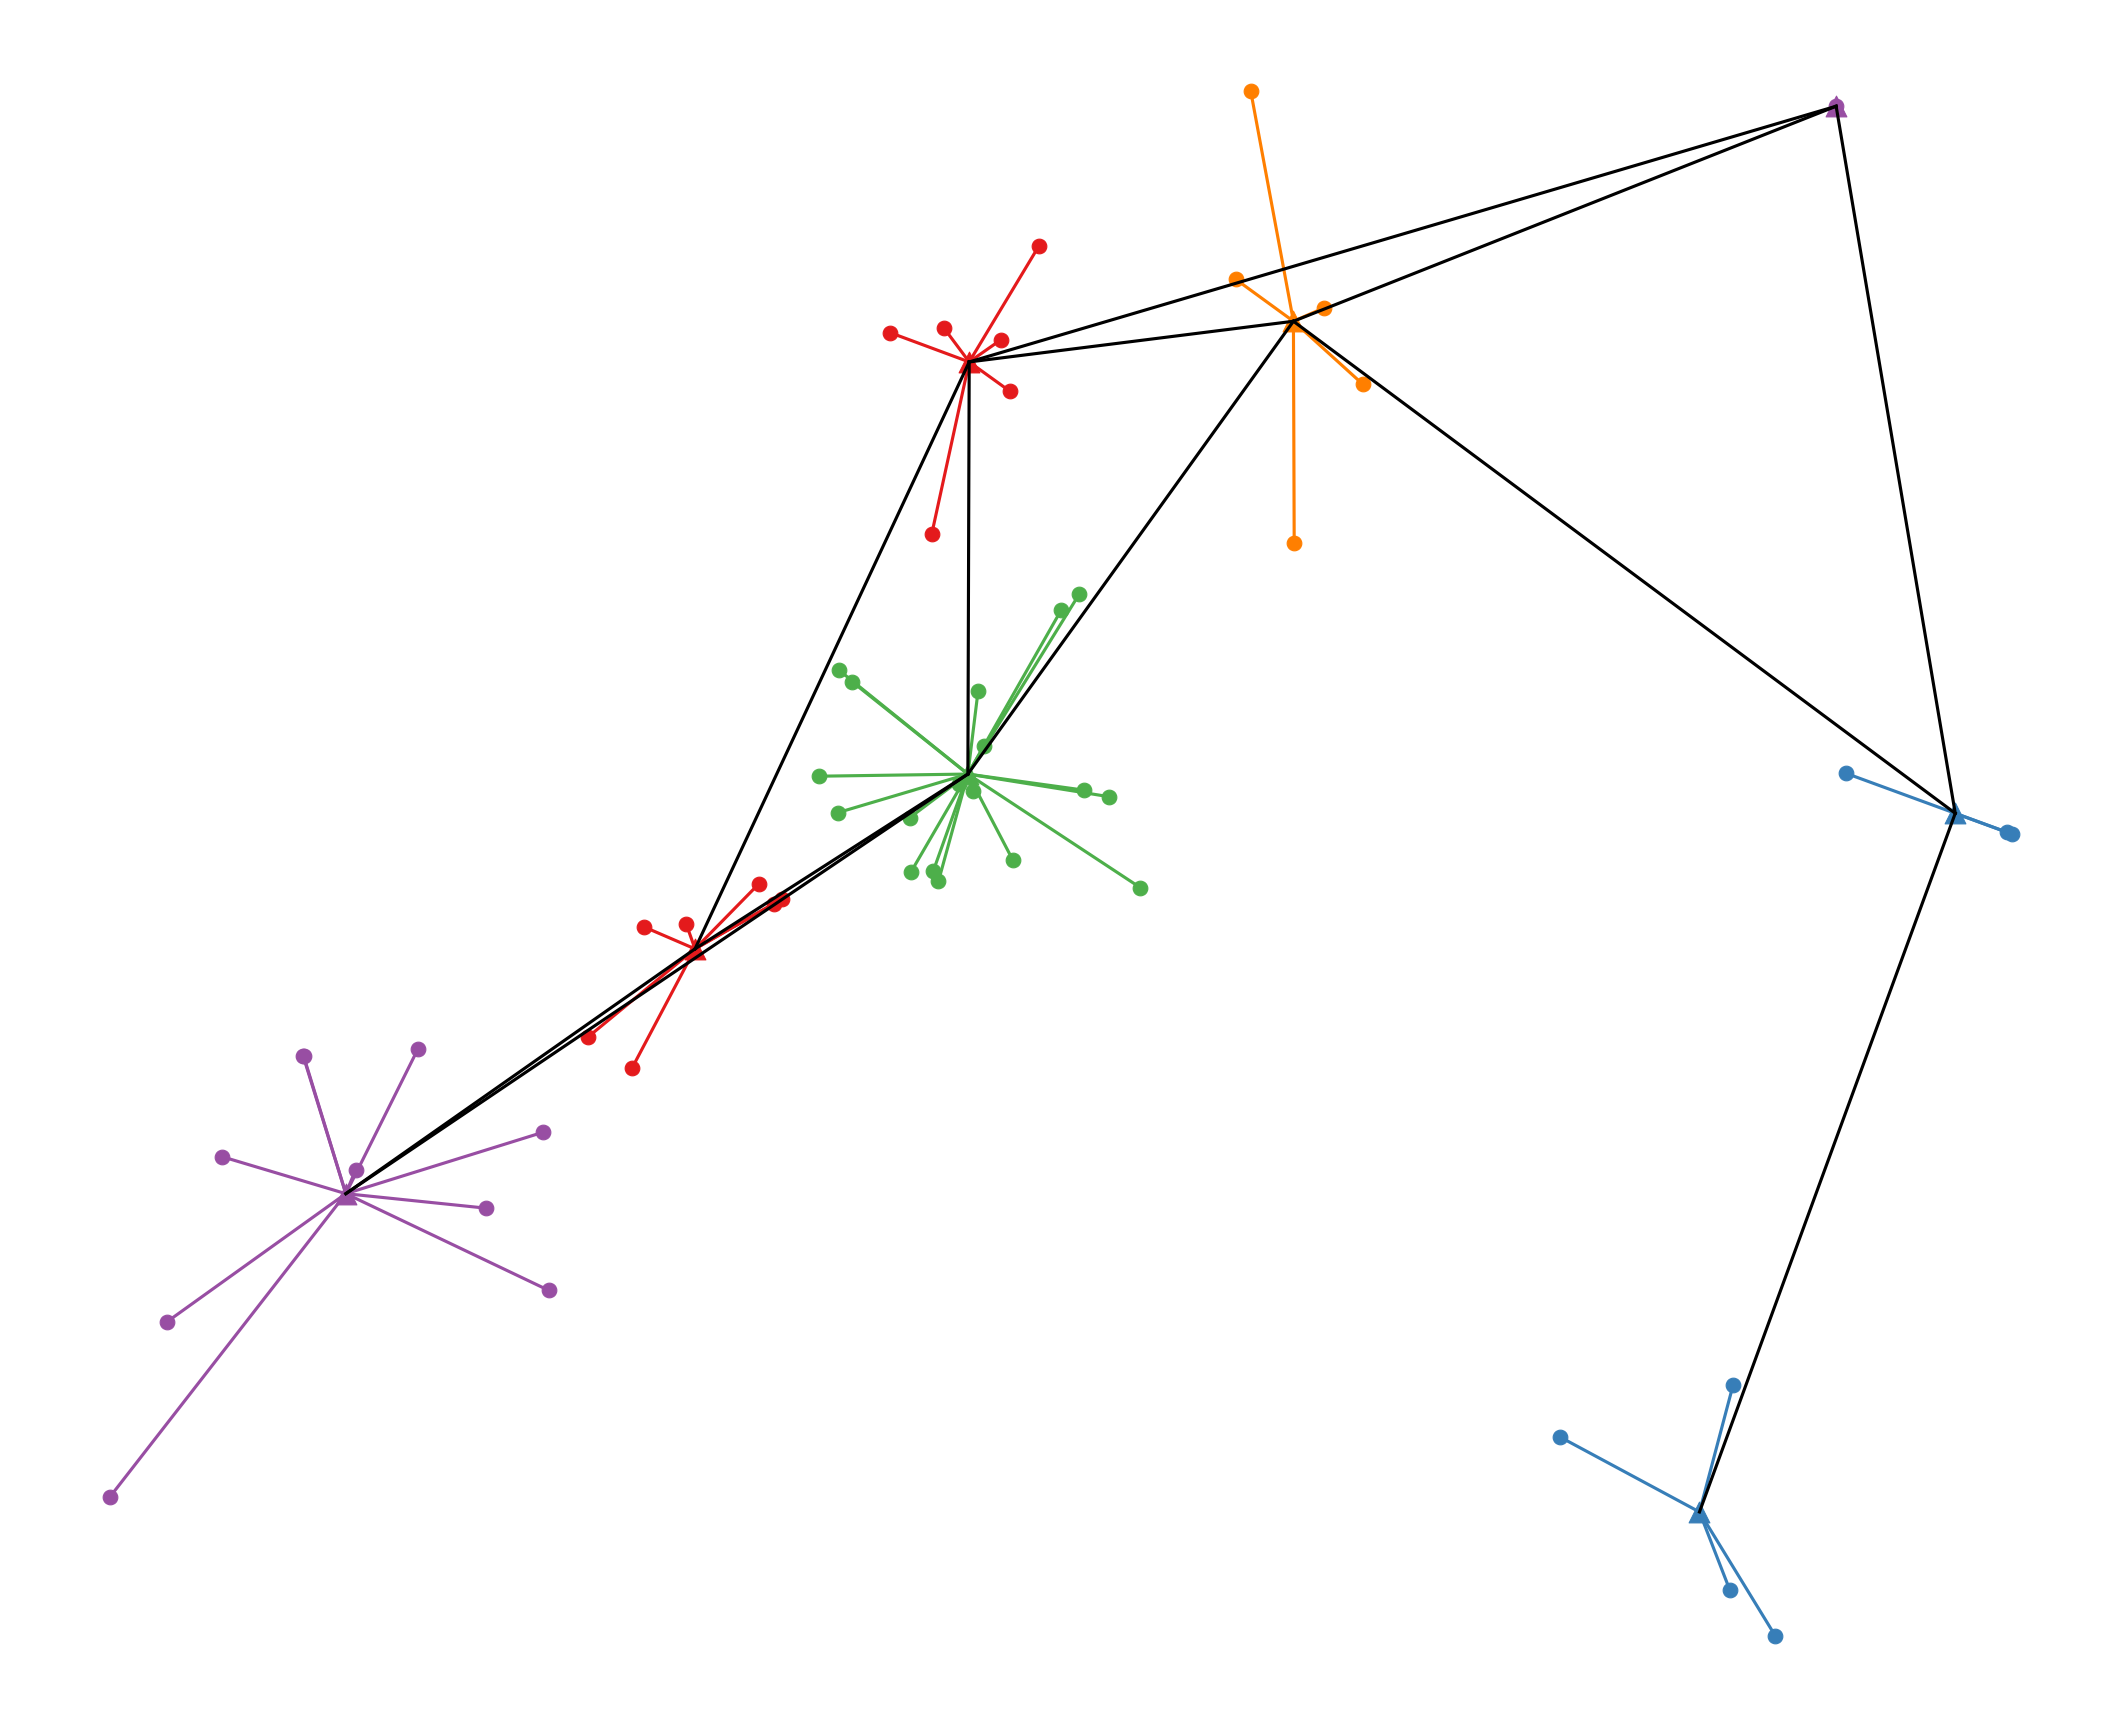

In [178]:
crear_clusters(8,55,df,"_norm")

298.721429
391.085614
128.06609
250.453631
183.670158
413.380243
185.078537
329.73101
183.30816
381.630929
462.615726
114.996544
120.602919
296.272247
224.198895
434.579855
381.856087
292.265042
234.476192
279.338132
297.535106
62.842316
219.879781
479.615117
277.999838
576.792844
342.157251
234.693231


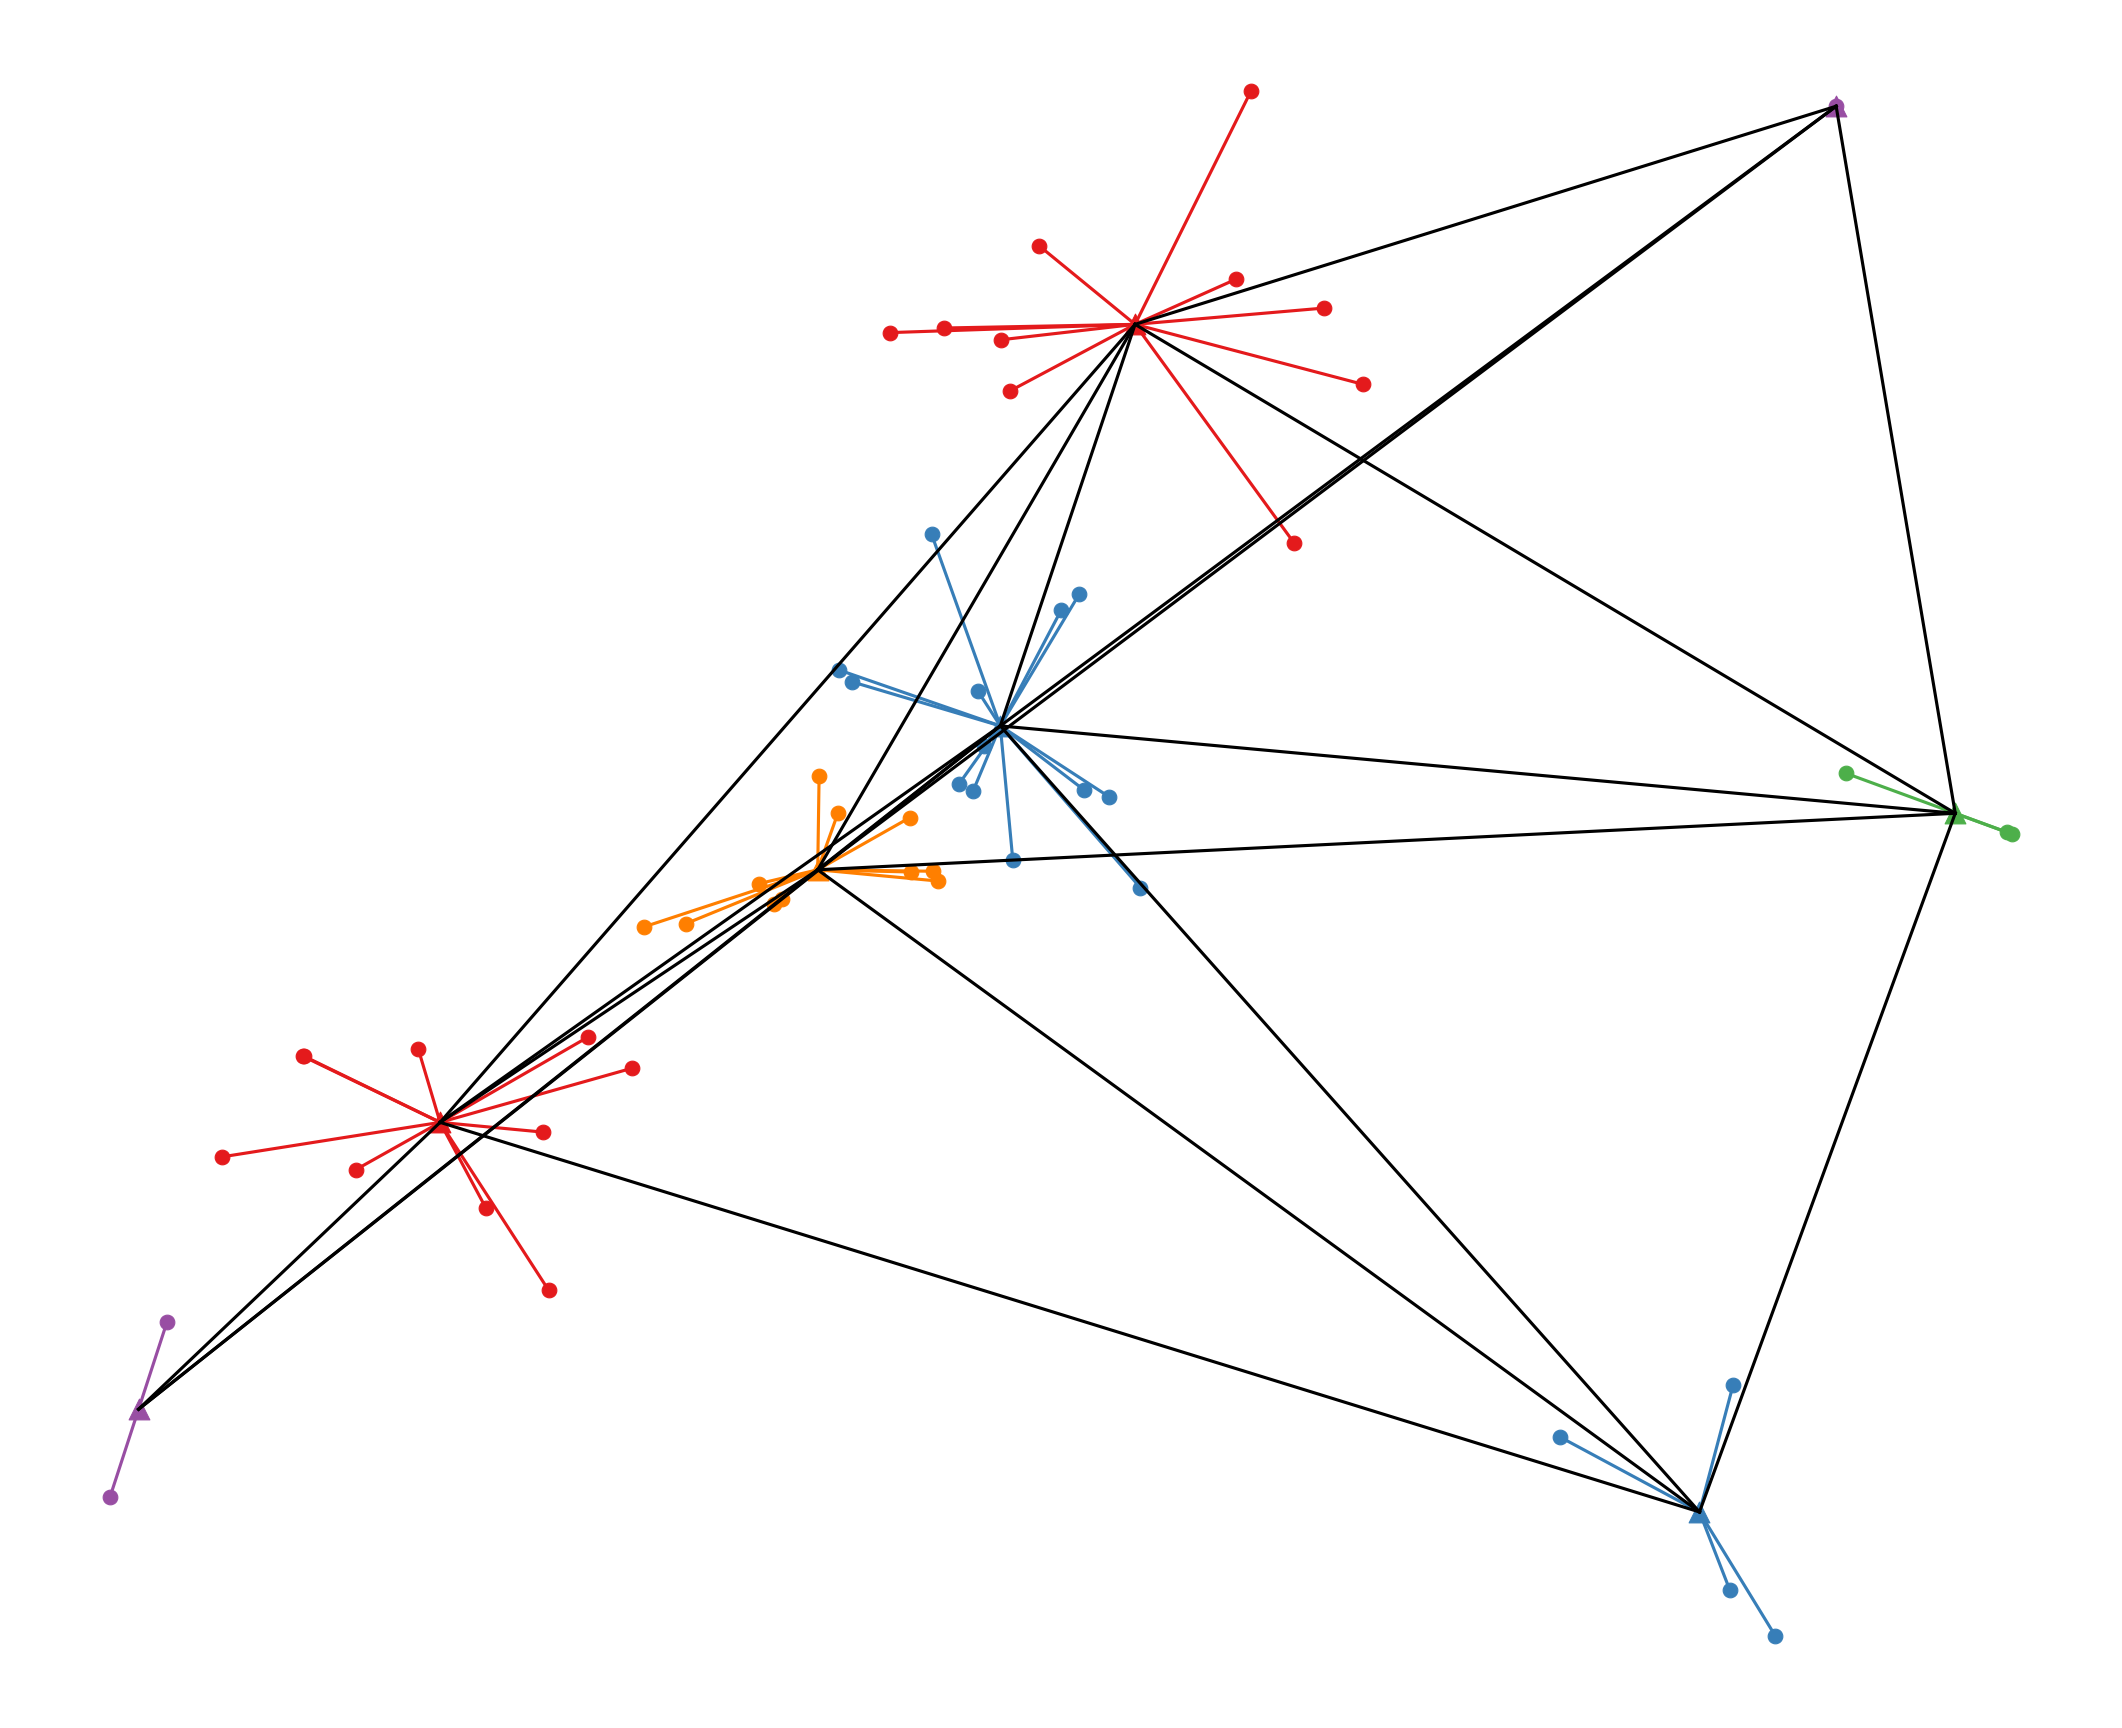

In [175]:
crear_clusters(8,350,df,"_std")